## **Deep Convolutional Neural Networks for Accurate Coronavirus Detection Using Chest CT Screening**

---





*   Pre-processing Steps

1.   Segregate CT into open and closed folders
2.   Cropped the open Scans based on the threshold value and resized them to 224*224


*   Implemented CNN from Scratch (with 2 different Custom Models) uploaded the 2nd model on a separate file
*   5-Fold Cross Validation ( on both the custom models ) WIll show the Results soon as it takes a lot of time to get executed and our RAM crashes
*   Experimenting with Pre-trained Models ResNet50 and VGG 19 (Transfer Learning)-- Will show the complte results soon







**Pre-Processing (8 Steps)**

In [ ]:
#1  sample is the list of input of "object or string" which needs to convert into list of values
    #returns the list of int values
def objtolist(sample):
    onelist=[]
    finalist=[]
    strings=''
    for j in tqdm(range(len(sample))):
        for i in sample[j]:
            try:
                first = int(i)
                strings+=i
            except:
                if i==',' :
                    onelist.append(int(strings))
                    strings=''
                elif i==']'or i==')':
                    onelist.append(int(strings))
                    strings=''
                    finalist.append(onelist)
                    onelist=[]

    return finalist


#2 Now we calculate the average pixel intensity for all the CT Scans

def pixelslist(imglist,mode='central',normalization="True"):
    '''
    imglist : list of location of images to calculate the avg pixel intensity API
    mode : 
    'full' will calculate API for whole image
    'central' will calulate API for 25%-75% of images' size
    normalization:
    numpy/max value
    '''

    if mode=='full':
        percent = 1
    else:
        percent = 0.5        

    a, b = (1-percent)/2,(1+percent)/2

    counts   = 0
    countlist=[]
    for img in tqdm(imglist):
        if img[-3:] == 'tif':
            try: # imglist should have the loc of images only
                img  = Image.open(img)
                h,w  = img.height,img.width
                for y in range(int(a*h),int(b*h)):                                #looping the pixel location in image to get the pixel intensity
                    for x in range(int(a*w),int(b*w)):
                        pixels = img.getpixel((x, y))
                        if normalization:
                            max_val=np.amax(img)
                            pixels =pixels/max_val
                        counts+= pixels
                counts = counts/(h*percent*w*percent)
                countlist.append(counts)
                

                
            except:
                    print("something wrong in this image : " ,img)
                    pass 
    return countlist


#3 Here we have found out the Largest Lung in the Dataset as a reference for cropping out the other lungs

def findmaxlung(sizes,mode='maxside'):
    '''
    Args : Sizes : are the list of cropped sizes of the lungs after we have passed the images to cropping function which works on avg pixel intensity maxima
            Mode : has three types 1) "area" : lung with largest area covered 2) "peri" : largest perimeter covered 3) "maxside" : largest width and height (can be from different lungs)

    return : index : location(s) of the largest lung
             ModeValue : largest Value as per the Mode

    '''

    if mode == 'peri':
        perilist = []
        for i in tqdm(range(len(sizes))):
            perilist.append(sizes[i][0] + sizes[i][1])
        index,ModeValue = perilist.index(max(perilist)),max(perilist)
        # print("Largest perimeter lung ",index,ModeValue)

        return index,ModeValue

    elif mode == 'area':
        arealist = []
        for i in tqdm(range(len(sizes))):
            arealist.append(sizes[i][0] * sizes[i][1])
            index,ModeValue = arealist.index(max(arealist)),max(arealist)
            # print("Largest area lung ",index,ModeValue)
            
        return index,ModeValue

    else:
        mode = 'maxside'
        widthlist =[]
        heightlist =[]
        for i in tqdm(range(len(sizes))):
            widthlist.append(sizes[i][1]) 
            heightlist.append(sizes[i][0]) 
        maxwidth  = max(widthlist)
        maxheight = max(heightlist)    
        index,ModeValue   = [heightlist.index(maxheight),widthlist.index(maxwidth)],[maxheight,maxwidth]

        return index,ModeValue

#4 Now we find out the threshold value by considering small sample of both open and closed CT scans

def threshold(openlist,closedlist,normalization="True"):
    '''
    Args   : openlist   = list of folder containing sample open   lungs
             closedlist = list of folder containing sample closed lungs   
    returns: openpixels = list containing average pixel 
            ,closepixels,threshold
    '''
    openpixels  = pixelslist(openlist,normalization=normalization)                 
    closepixels = pixelslist(closedlist,normalization=normalization)

    openmean   = sum(openpixels)/len(openpixels)
    closedmean = sum(closepixels)/len(closepixels)
    threshold  = (openmean+closedmean)/2                # One way to calculate the threshold         89 %
    threshold  =  min(threshold,max(openpixels))        # Second way to calculate the threshold      92 %
                                                        # Third way is to median                     94 %
    return openpixels,closepixels,threshold



#5 Now based on the obtained threhold value we crop the lungs accurately

def cropping (imglist,destfold='', view='False',croptype = 'False',):
    '''
    Args    
    imglist =  
    
    croptype ="True" will save the cropped images
                "False" will keep the size same and blackout rest part
    
    destfold = Destination folder where you want to save the cropped images
    viewcrop = Do you want to see the cropped images.. might hang the system

    return : A list of index and "location of the cropped images"
    '''
    AllTiff   = list(covid['loc'])
    for j in (imglist):
        
        try: 
            i         = AllTiff.index(j)
            img       = Image.open(j)                                                 # Loading the image
            img       = np.array(img)                                                 # Converting the image into numpy
            maximal2r = covid['maximal2r'][i]
            maximat2b = covid['maximat2b'][i]
            maximal2r = objtolist(maximal2r)
            maximal2r = maximal2r[0]
            maximat2b = objtolist(maximat2b)
            maximat2b = maximat2b[0]
            X = (w//2)- maximal2r[1]
            Y = 0 #(h//2)- maximat2b[1]                                         # dislocation of center : X,',',Y

        except:
            print('Images are problematic')
        if croptype:
            mask          = np.zeros(img.shape[:2], np.uint8)                   # create a mask
            mask[maximal2r[0]:maximal2r[2],maximat2b[0]:maximat2b[2]] = 255     # check this 
            masked_img   = cv2.bitwise_and(img,img,mask = mask)                 # cropping only part
            # shiftingby = np.float32([[1,0,X], [0,1,Y]])                       # shifting
            # shiftedimg = cv2.warpAffine(masked_img, shiftingby,(X, Y))        # check this
            
        else:
            masked_img= img[maximal2r[0]:maximal2r[2],maximat2b[0]:maximat2b[2]] # cropping and check this 
            mask      = np.zeros(img.shape[:2], np.uint8)  
            # shiftingby = np.float32([[1,0,X], [0,1,Y]]) 
            # shiftedimg = cv2.warpAffine(masked_img, shiftingby,(X, Y))        # check this
            

        if view:
            plt.subplot(221), plt.imshow(img, 'gray'),
            plt.subplot(222), plt.imshow(mask,'gray'),
            plt.subplot(223), plt.imshow(masked_img, 'gray'),
            # plt.subplot(224), plt.imshow(shiftedimg, 'gray')
            plt.xlim([0,512])

            plt.show()

        if destfold:

            try:
                
                # cv2.imwrite(imglist[i][-7:-3]+str(jpeg), masked_img)                         # save in jpeg format
                cropimg = Image.fromarray(masked_img)
                cropimg.save(imglist[i][-7:]) 
                shutil.move(imglist[i][-7:],destfold)
                Outputlist =list(os.listdir(destfold))
            except:
                print("something wrong in destination folder")
                print("images saved at current workind directory")
                Outputlist =os.getcwd()
        else:
            Outputlist =os.getcwd()

        
    return Outputlist
#6 Here we create two list for open and closed segregated CT scans since we intend to train our model only on open CT scans
def segregate (pixellist,threshold):
    '''
    Args : pixellist is the list of avg pixel intensity count of all tif images
            threshold is the value which will be considered to bifurcate
    return: two list open and closed with index values in each 

    '''
    openseg = []
    closedseg=[]
    for j,i in tqdm(enumerate(pixellist)):
        if i<threshold:
            openseg.append([j,i])
        else:
            closedseg.append([j,i])
    
    return openseg,closedseg


#7 Getting the exact location for the saved folders
def listinfolder (folderloc):
    '''
    Args  : folderloc
    return: A list of exact location of each file inside the folder 
    '''
    out   = []
    items = os.listdir(folderloc)
    for i in items:
        out.append(str(folderloc)+'/'+str(i))

    return out

#8 Now here we create a separate Dataset of open and closed CT scans and save it
def savelist (listopen,listclosed,destfold=''):
    '''
    Args  : listopen list of all open images listclosed list of all closed images
            destfold folder where to put open and closed scans
    return: copy images from AllTiff into two folders named open and closed
    '''
    if destfold:
        pass
    else:
        destfold = os.getcwd()

    for i in listopen:
        shutil.copy(i,str(destfold)+'/'+'OPEN')
    for j in listclosed:
        shutil.copy(j,str(destfold)+'/'+'CLOSED')

    counto = len(str(destfold)+'/'+'OPEN')
    countc = len(str(destfold)+'/'+'CLOSED')
    return {"Open":counto , "Closed":countc } 



**1st Custom Model**

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *

from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *

from sklearn.metrics import classification_report
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import tensorflow as tf

In [ ]:
# run the first cell for all libraries

import numpy as np
import pandas as pd
from PIL import Image 
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from google.colab.patches import cv2_imshow
import os,io,cv2,shutil

from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive'

c = pd.read_csv('/content/drive/MyDrive/Final.csv')
covid = c.copy()
covid.head()

Mounted at /content/drive
 allcentralpixel.csv	       model
 AllTiff		       PNG
 balanced_test.npy	       resized_balanced_test.npy
 balanced_train.npy	       resized_balanced_train.npy
 balanced_valid.npy	       resized_balanced_valid.npy
 checkpoint		       resizedcp.ckpt.data-00000-of-00001
'Colab Notebooks'	       resizedcp.ckpt.index
 cp.ckpt.data-00000-of-00001   resizedmodel
 cp.ckpt.index		       test.npy
 CroppedOpenLungs	       train11.npy
 Final.csv		       train22.npy
 Full.csv		       train.npy
 local.csv		       valid.npy


,Unnamed: 0,index,loc,img,maximat2b,maximal2r,colsavg,rowsavg,croppedshape,maxnpfull,FullAvgPxlDen,CrpdAvgPxlDen,CentAvgPxlDen,OpenClose,label
0,0,0,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(99, 245, 427)","(152, 235, 378)",[ 42.36914062 43.45117188 44.63671875 46.08...,[ 20.10351562 20.0703125 20.02148438 20.02...,"(226, 328)",2191,439,622,672,Open,0
1,1,1,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(101, 244, 424)","(160, 263, 374)",[ 41.29101562 42.37695312 43.78125 45.46...,[ 20.45703125 20.61523438 20.64257812 20.85...,"(214, 323)",3039,475,583,634,Open,0
2,2,2,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(169, 274, 343)","(151, 249, 375)",[ 41.86914062 42.98632812 44.26171875 45.70...,[ 19.7109375 19.89257812 19.96875 20.38...,"(224, 174)",2212,424,885,895,Close,0
3,3,3,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(169, 254, 378)","(150, 271, 369)",[ 41.3515625 42.203125 43.56640625 45.07...,[ 19.66992188 19.734375 20.0703125 20.19...,"(219, 209)",2291,476,1031,1031,Close,0
4,4,4,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,[0 0 0 ... 0 0 0],"(93, 261, 434)","(148, 218, 379)",[ 43.41601562 44.4375 45.24023438 46.55...,[ 18.31835938 18.38476562 18.59179688 18.67...,"(231, 341)",2246,348,623,688,Open,0


In [ ]:
data = covid.drop(columns=['Unnamed: 0', 'img', 'maximat2b', 'maximal2r',
       'colsavg', 'rowsavg', 'croppedshape', 'maxnpfull', 'FullAvgPxlDen',
       'CrpdAvgPxlDen', 'CentAvgPxlDen'])
data.head(8)

,index,loc,OpenClose,label
0,0,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Open,0
1,1,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Open,0
2,2,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Close,0
3,3,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Close,0
4,4,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Open,0
5,5,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Open,0
6,6,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Close,0
7,7,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Close,0


In [ ]:
data.head()

,index,loc,OpenClose,label
0,0,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Open,0
1,1,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Open,0
2,2,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Close,0
3,3,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Close,0
4,4,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Open,0


**Balance the Dataset**

since our dataset was highly imbalanced, we had around 15k scans of covid patients and 48k of normal, we decided to only work on the total open CT scans of Covid patients

In [ ]:
#Normal and Covid CT now being segregated
X = data.drop('label',axis=1)
y = data['label']

n=[]
c=[]
for j,i in enumerate(data['label']):
    if i==0:
        n.append(j)
    else:
        c.append(j)


**Considering Only Open COVID Cases for Classification**

In [ ]:
OpenCovid=[]
for j,i in enumerate(data['label']):
    if data['OpenClose'].iloc[j]=="Open" and i == 1:
        OpenCovid.append(data['index'].iloc[j])

print(len(OpenCovid),'Open Covid out of',len(data))

8774 Open Covid out of 63849


In [ ]:
len(OpenCovid)

8774

In [ ]:
CovidOpen = data.iloc[OpenCovid]
X_normal = data.drop('label',axis=1).iloc[n]
y_normal = data['label'].iloc[n]
X_normal = X_normal.sample(len(OpenCovid),random_state=1)
y_normal = y_normal.sample(len(OpenCovid),random_state=1)

X_covid  = CovidOpen.drop('label',axis=1)
y_covid  = CovidOpen['label']

X=X_normal.append(X_covid)
y=y_normal.append(y_covid)
X=X.sample(frac=1)
y=y.sample(frac=1)


X_train, X_test, y_train, y_test     = train_test_split(X, y, test_size=0.2, random_state=42 , stratify = y)
X_train, X_val, y_train, y_val       = train_test_split(X_train, y_train, test_size=0.25, random_state=42,stratify = y_train)

print("Input : ",len(X))
print(" Normal : ",y.value_counts()[0])
print(" Covid  : ",y.value_counts()[1])
print("1   Train  : ",len(X_train))
print("     Normal: ",y_train.value_counts()[0])
print("     Covid : ",y_train.value_counts()[1])
print("2   Test   : ",len(X_test))
print("     Normal: ",y_test.value_counts()[0])
print("     Covid : ",y_test.value_counts()[1])
print("3   Valid. : ",len(X_val))
print("     Normal: ",y_val.value_counts()[0])
print("     Covid : ",y_val.value_counts()[1])

Input :  17548
 Normal :  8774
 Covid  :  8774
1   Train  :  10528
     Normal:  5264
     Covid :  5264
2   Test   :  3510
     Normal:  1755
     Covid :  1755
3   Valid. :  3510
     Normal:  1755
     Covid :  1755


In [ ]:
def load(primary_keys):
    datas=[]
    for key in tqdm(primary_keys):
        key = int(key)
        if data['OpenClose'][key]=='Open':
            try:
                img = Image.open(data['loc'][key])       
                npar= np.array(img)
                res = cv2.resize(npar,(224, 224), interpolation = cv2.INTER_CUBIC)
                datas.append([res, data['label'][key]])
            except Exception as e:
                print(e)
        else:
            print("Closed?",data['index'][key])
    return np.array(datas)

In [ ]:
X_train.head()

,index,loc,OpenClose
12046,12046,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Open
56627,56627,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Close
23699,23699,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Open
15336,15336,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Open
22504,22504,/content/drive/MyDrive/AllTiff/COVID-CTset/nor...,Open


In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

10528
3510
3510


**Function for Loading the created Dataset**

In [ ]:
#TIME CONSUMING

X_train_mini = X_train #[:8000] #X_train.sample(frac=.65)
X_val_mini   = X_val  #[:2000] 
X_test_mini  = X_test #[:2000] 
train = load(list((X_train_mini['index'])))
valid = load(list(X_val_mini['index']))
test  = load(list(X_test_mini['index']))

  0%|          | 1/10528 [00:02<8:02:48,  2.75s/it]

Closed? 56627


  0%|          | 5/10528 [00:05<4:00:16,  1.37s/it]

Closed? 63286


  0%|          | 24/10528 [00:25<2:07:57,  1.37it/s]

Closed? 36320
Closed? 6277


  0%|          | 28/10528 [00:26<1:52:45,  1.55it/s]

Closed? 7182


  0%|          | 44/10528 [00:42<2:21:56,  1.23it/s]

Closed? 60669


  1%|          | 53/10528 [00:50<2:51:49,  1.02it/s]

Closed? 59457


  1%|          | 56/10528 [00:51<2:10:47,  1.33it/s]

Closed? 3329


  1%|          | 73/10528 [01:04<2:05:13,  1.39it/s]

Closed? 11329


  1%|          | 76/10528 [01:05<1:25:21,  2.04it/s]

Closed? 33376
Closed? 30567


  1%|          | 84/10528 [01:09<1:51:40,  1.56it/s]

Closed? 17706


  1%|          | 86/10528 [01:10<1:38:23,  1.77it/s]

Closed? 5260


  1%|          | 90/10528 [01:12<1:36:02,  1.81it/s]

Closed? 22246
Closed? 14650


  1%|          | 93/10528 [01:13<1:22:30,  2.11it/s]

Closed? 8051


  1%|          | 100/10528 [01:17<1:57:18,  1.48it/s]

Closed? 19632


  1%|          | 104/10528 [01:19<2:20:40,  1.24it/s]

Closed? 7737


  1%|          | 109/10528 [01:22<1:47:41,  1.61it/s]

Closed? 12333
Closed? 3661


  1%|          | 119/10528 [01:27<1:35:37,  1.81it/s]

Closed? 20119


  1%|          | 123/10528 [01:28<55:45,  3.11it/s]  

Closed? 6670


  1%|          | 128/10528 [01:32<2:00:39,  1.44it/s]

Closed? 59147


  1%|▏         | 135/10528 [01:36<2:10:34,  1.33it/s]

Closed? 58075


  1%|▏         | 137/10528 [01:37<1:51:43,  1.55it/s]

Closed? 5874


  1%|▏         | 146/10528 [01:45<2:02:10,  1.42it/s]

Closed? 31709


  1%|▏         | 152/10528 [01:47<1:00:54,  2.84it/s]

Closed? 20205


  1%|▏         | 157/10528 [01:50<1:56:42,  1.48it/s]

Closed? 13784


  2%|▏         | 164/10528 [01:56<2:40:18,  1.08it/s]

Closed? 1928


  2%|▏         | 169/10528 [01:57<1:09:37,  2.48it/s]

Closed? 31174


  2%|▏         | 170/10528 [01:58<1:28:34,  1.95it/s]

Closed? 33720


  2%|▏         | 172/10528 [01:59<1:24:00,  2.05it/s]

Closed? 14128


  2%|▏         | 178/10528 [02:00<59:51,  2.88it/s]  

Closed? 16308


  2%|▏         | 180/10528 [02:01<1:01:29,  2.80it/s]

Closed? 61628
Closed? 57352


  2%|▏         | 189/10528 [02:05<1:29:45,  1.92it/s]

Closed? 23056


  2%|▏         | 198/10528 [02:10<1:43:27,  1.66it/s]

Closed? 13689


  2%|▏         | 203/10528 [02:13<2:07:52,  1.35it/s]

Closed? 3831


  2%|▏         | 205/10528 [02:13<1:38:07,  1.75it/s]

Closed? 36359


  2%|▏         | 218/10528 [02:19<1:03:00,  2.73it/s]

Closed? 55409


  2%|▏         | 222/10528 [02:21<1:27:57,  1.95it/s]

Closed? 7896


  2%|▏         | 230/10528 [02:25<1:36:56,  1.77it/s]

Closed? 59604
Closed? 1264


  2%|▏         | 237/10528 [02:28<1:26:25,  1.98it/s]

Closed? 391


  2%|▏         | 254/10528 [02:39<2:59:42,  1.05s/it]

Closed? 24044


  2%|▏         | 260/10528 [02:41<1:43:21,  1.66it/s]

Closed? 16450


  2%|▏         | 263/10528 [02:42<1:13:00,  2.34it/s]

Closed? 844
Closed? 24215


  3%|▎         | 267/10528 [02:43<1:15:01,  2.28it/s]

Closed? 63146


  3%|▎         | 274/10528 [02:46<1:14:09,  2.30it/s]

Closed? 29720


  3%|▎         | 282/10528 [02:51<1:35:22,  1.79it/s]

Closed? 34187


  3%|▎         | 285/10528 [02:52<1:33:46,  1.82it/s]

Closed? 59957


  3%|▎         | 296/10528 [02:57<1:40:49,  1.69it/s]

Closed? 7565
Closed? 54509


  3%|▎         | 304/10528 [03:00<1:24:05,  2.03it/s]

Closed? 14651
Closed? 61203


  3%|▎         | 317/10528 [03:05<1:16:56,  2.21it/s]

Closed? 54024


  3%|▎         | 319/10528 [03:07<1:41:57,  1.67it/s]

Closed? 19229


  3%|▎         | 326/10528 [03:10<1:40:14,  1.70it/s]

Closed? 31939


  3%|▎         | 328/10528 [03:10<1:15:29,  2.25it/s]

Closed? 24170


  3%|▎         | 334/10528 [03:11<43:37,  3.89it/s]

Closed? 21886
Closed? 21406


  3%|▎         | 343/10528 [03:14<55:13,  3.07it/s]  

Closed? 24840


  3%|▎         | 347/10528 [03:15<48:16,  3.52it/s]

Closed? 59308


  3%|▎         | 356/10528 [03:20<2:10:36,  1.30it/s]

Closed? 23826


  3%|▎         | 365/10528 [03:24<1:42:00,  1.66it/s]

Closed? 55812


  3%|▎         | 367/10528 [03:25<1:18:45,  2.15it/s]

Closed? 16967


  4%|▎         | 372/10528 [03:27<1:04:52,  2.61it/s]

Closed? 30880


  4%|▎         | 382/10528 [03:30<1:23:12,  2.03it/s]

Closed? 7082


  4%|▎         | 389/10528 [03:33<54:14,  3.12it/s]  

Closed? 54869


  4%|▎         | 392/10528 [03:34<1:12:43,  2.32it/s]

Closed? 57085


  4%|▍         | 397/10528 [03:35<41:19,  4.09it/s]

Closed? 1230


  4%|▍         | 410/10528 [03:40<1:00:13,  2.80it/s]

Closed? 33383


  4%|▍         | 416/10528 [03:44<1:24:29,  1.99it/s]

Closed? 59940


  4%|▍         | 419/10528 [03:45<1:05:00,  2.59it/s]

Closed? 10352


  4%|▍         | 422/10528 [03:45<47:32,  3.54it/s]

Closed? 23330


  4%|▍         | 426/10528 [03:47<52:06,  3.23it/s]

Closed? 3285


  4%|▍         | 429/10528 [03:48<1:01:18,  2.75it/s]

Closed? 23051


  4%|▍         | 456/10528 [03:58<58:21,  2.88it/s]  

Closed? 4913


  4%|▍         | 462/10528 [04:00<40:58,  4.09it/s]

Closed? 52610


  4%|▍         | 464/10528 [04:00<44:03,  3.81it/s]

Closed? 30752


  4%|▍         | 469/10528 [04:01<37:16,  4.50it/s]

Closed? 59913


  5%|▍         | 475/10528 [04:03<1:08:19,  2.45it/s]

Closed? 31015


  5%|▍         | 498/10528 [04:23<1:46:22,  1.57it/s]

Closed? 1745


  5%|▍         | 500/10528 [04:23<1:21:59,  2.04it/s]

Closed? 16479


  5%|▍         | 503/10528 [04:24<1:02:49,  2.66it/s]

Closed? 52600


  5%|▍         | 505/10528 [04:25<1:05:12,  2.56it/s]

Closed? 16108


  5%|▍         | 513/10528 [04:28<1:00:49,  2.74it/s]

Closed? 26215
Closed? 35964
Closed? 53534


  5%|▍         | 515/10528 [04:29<1:08:00,  2.45it/s]

Closed? 2878


  5%|▍         | 518/10528 [04:30<1:20:51,  2.06it/s]

Closed? 6852
Closed? 3069


  5%|▍         | 526/10528 [04:32<40:57,  4.07it/s]

Closed? 55008


  5%|▌         | 528/10528 [04:32<33:54,  4.92it/s]

Closed? 23917


  5%|▌         | 536/10528 [04:34<36:09,  4.61it/s]

Closed? 20493


  5%|▌         | 542/10528 [04:35<38:09,  4.36it/s]

Closed? 5856


  5%|▌         | 548/10528 [04:36<33:39,  4.94it/s]

Closed? 31766


  5%|▌         | 555/10528 [04:39<52:31,  3.16it/s]  

Closed? 28164
Closed? 9817
Closed? 30699


  5%|▌         | 562/10528 [04:41<1:30:12,  1.84it/s]

Closed? 4183


  5%|▌         | 576/10528 [04:45<1:14:43,  2.22it/s]

Closed? 84
Closed? 7822
Closed? 25491


  6%|▌         | 595/10528 [04:52<58:46,  2.82it/s]  

Closed? 21559


  6%|▌         | 605/10528 [04:55<1:01:38,  2.68it/s]

Closed? 17365
Closed? 6888


  6%|▌         | 610/10528 [04:55<37:49,  4.37it/s]

Closed? 23570


  6%|▌         | 621/10528 [04:59<47:06,  3.51it/s]

Closed? 32430


  6%|▌         | 633/10528 [05:04<1:10:35,  2.34it/s]

Closed? 19009


  6%|▌         | 639/10528 [05:07<1:33:41,  1.76it/s]

Closed? 25508


  6%|▌         | 650/10528 [05:11<51:15,  3.21it/s]

Closed? 54777


  6%|▌         | 655/10528 [05:13<1:35:49,  1.72it/s]

Closed? 16973


  6%|▋         | 658/10528 [05:14<1:26:27,  1.90it/s]

Closed? 35846


  6%|▋         | 674/10528 [05:20<1:02:32,  2.63it/s]

Closed? 29851


  7%|▋         | 697/10528 [05:27<44:16,  3.70it/s]

Closed? 25726


  7%|▋         | 711/10528 [05:31<40:01,  4.09it/s]

Closed? 4398
Closed? 35342


  7%|▋         | 712/10528 [05:31<38:35,  4.24it/s]

Closed? 60028


  7%|▋         | 721/10528 [05:34<59:35,  2.74it/s]  

Closed? 973


  7%|▋         | 733/10528 [05:39<55:55,  2.92it/s]  

Closed? 27274


  7%|▋         | 735/10528 [05:39<44:21,  3.68it/s]

Closed? 32639


  7%|▋         | 738/10528 [05:40<48:08,  3.39it/s]

Closed? 30934


  7%|▋         | 754/10528 [05:46<1:07:12,  2.42it/s]

Closed? 18045


  7%|▋         | 773/10528 [05:52<44:09,  3.68it/s]

Closed? 61812


  7%|▋         | 778/10528 [05:53<34:31,  4.71it/s]

Closed? 7254


  7%|▋         | 783/10528 [05:54<32:54,  4.94it/s]

Closed? 7921


  7%|▋         | 786/10528 [05:55<29:05,  5.58it/s]

Closed? 13122


  8%|▊         | 795/10528 [05:57<37:28,  4.33it/s]

Closed? 54251


  8%|▊         | 811/10528 [06:03<41:59,  3.86it/s]

Closed? 32022
Closed? 56515


  8%|▊         | 816/10528 [06:04<35:18,  4.59it/s]

Closed? 7460
Closed? 19242


  8%|▊         | 827/10528 [06:08<41:39,  3.88it/s]

Closed? 13257


  8%|▊         | 835/10528 [06:10<1:02:12,  2.60it/s]

Closed? 11102
Closed? 54309
Closed? 61773
Closed? 25386
Closed? 61601


  8%|▊         | 847/10528 [06:13<1:29:18,  1.81it/s]

Closed? 61252


  8%|▊         | 850/10528 [06:14<1:28:21,  1.83it/s]

Closed? 61685


  8%|▊         | 855/10528 [06:15<1:00:29,  2.66it/s]

Closed? 52703
Closed? 5795


  8%|▊         | 862/10528 [06:17<1:08:13,  2.36it/s]

Closed? 21547


  8%|▊         | 870/10528 [06:19<42:42,  3.77it/s]

Closed? 29586
Closed? 62780
Closed? 18607
Closed? 33938


  8%|▊         | 880/10528 [06:21<40:31,  3.97it/s]

Closed? 20276


  8%|▊         | 881/10528 [06:21<40:23,  3.98it/s]

Closed? 36698


  8%|▊         | 883/10528 [06:21<34:40,  4.64it/s]

Closed? 14149


  8%|▊         | 887/10528 [06:22<32:45,  4.91it/s]

Closed? 26258


  9%|▊         | 906/10528 [06:28<36:31,  4.39it/s]

Closed? 1205


  9%|▊         | 914/10528 [06:30<39:03,  4.10it/s]

Closed? 18558


  9%|▊         | 918/10528 [06:31<32:24,  4.94it/s]

Closed? 13141


  9%|▊         | 920/10528 [06:31<30:29,  5.25it/s]

Closed? 15000


  9%|▉         | 930/10528 [06:34<46:56,  3.41it/s]

Closed? 34342


  9%|▉         | 943/10528 [06:37<38:37,  4.14it/s]

Closed? 5364
Closed? 54018
Closed? 62079


  9%|▉         | 947/10528 [06:38<27:36,  5.78it/s]

Closed? 10039
Closed? 35520
Closed? 59562


  9%|▉         | 954/10528 [06:39<25:52,  6.17it/s]

Closed? 59159


  9%|▉         | 958/10528 [06:42<1:25:55,  1.86it/s]

Closed? 36692


  9%|▉         | 968/10528 [06:44<38:41,  4.12it/s]

Closed? 28782


  9%|▉         | 977/10528 [06:47<59:14,  2.69it/s]  

Closed? 52741


  9%|▉         | 986/10528 [06:49<45:29,  3.50it/s]

Closed? 36097


  9%|▉         | 990/10528 [06:51<56:29,  2.81it/s]  

Closed? 54505


 10%|▉         | 1008/10528 [07:03<2:44:32,  1.04s/it]

Closed? 17812


 10%|▉         | 1012/10528 [07:04<1:29:41,  1.77it/s]

Closed? 17811


 10%|▉         | 1029/10528 [07:11<45:08,  3.51it/s]

Closed? 25781


 10%|▉         | 1031/10528 [07:11<38:40,  4.09it/s]

Closed? 3490


 10%|▉         | 1051/10528 [07:19<51:47,  3.05it/s]

Closed? 31594


 10%|█         | 1059/10528 [07:22<47:05,  3.35it/s]

Closed? 15853


 10%|█         | 1064/10528 [07:23<35:58,  4.38it/s]

Closed? 4043


 10%|█         | 1066/10528 [07:23<30:32,  5.16it/s]

Closed? 1917
Closed? 15564


 10%|█         | 1071/10528 [07:24<33:39,  4.68it/s]

Closed? 27587


 10%|█         | 1090/10528 [07:28<36:05,  4.36it/s]

Closed? 189
Closed? 8581


 10%|█         | 1091/10528 [07:28<33:51,  4.65it/s]

Closed? 59635


 10%|█         | 1094/10528 [07:30<57:34,  2.73it/s]  

Closed? 62188


 10%|█         | 1098/10528 [07:31<42:12,  3.72it/s]

Closed? 59509


 11%|█         | 1109/10528 [07:34<51:25,  3.05it/s]

Closed? 20121


 11%|█         | 1122/10528 [07:39<1:46:55,  1.47it/s]

Closed? 2721


 11%|█         | 1125/10528 [07:40<1:17:27,  2.02it/s]

Closed? 30494


 11%|█         | 1137/10528 [07:43<36:04,  4.34it/s]

Closed? 5209
Closed? 24588


 11%|█         | 1144/10528 [07:44<28:52,  5.42it/s]

Closed? 11802


 11%|█         | 1149/10528 [07:45<28:13,  5.54it/s]

Closed? 27872
Closed? 36032
Closed? 7536


 11%|█         | 1151/10528 [07:45<26:05,  5.99it/s]

Closed? 34692


 11%|█         | 1160/10528 [07:48<39:46,  3.93it/s]

Closed? 34823


 11%|█         | 1170/10528 [07:50<47:51,  3.26it/s]  

Closed? 10814
Closed? 6715
Closed? 27820


 11%|█         | 1171/10528 [07:50<43:39,  3.57it/s]

Closed? 22919


 11%|█         | 1175/10528 [07:52<45:16,  3.44it/s]

Closed? 11724


 11%|█         | 1177/10528 [07:52<38:27,  4.05it/s]

Closed? 4928


 11%|█         | 1184/10528 [07:53<28:58,  5.37it/s]

Closed? 24043


 11%|█▏        | 1189/10528 [07:55<39:53,  3.90it/s]

Closed? 7599
Closed? 31807


 11%|█▏        | 1197/10528 [07:56<45:27,  3.42it/s]

Closed? 16925


 11%|█▏        | 1202/10528 [07:57<32:05,  4.84it/s]

Closed? 6981


 11%|█▏        | 1210/10528 [08:00<39:19,  3.95it/s]

Closed? 8808


 12%|█▏        | 1217/10528 [08:01<35:49,  4.33it/s]

Closed? 17127


 12%|█▏        | 1219/10528 [08:01<30:49,  5.03it/s]

Closed? 35741


 12%|█▏        | 1224/10528 [08:02<25:41,  6.04it/s]

Closed? 12532


 12%|█▏        | 1235/10528 [08:06<1:10:28,  2.20it/s]

Closed? 503


 12%|█▏        | 1239/10528 [08:07<42:24,  3.65it/s]

Closed? 61652


 12%|█▏        | 1242/10528 [08:09<1:23:05,  1.86it/s]

Closed? 24780


 12%|█▏        | 1256/10528 [08:13<37:05,  4.17it/s]

Closed? 32995
Closed? 2055


 12%|█▏        | 1259/10528 [08:13<29:15,  5.28it/s]

Closed? 3067


 12%|█▏        | 1267/10528 [08:14<31:11,  4.95it/s]

Closed? 6665


 12%|█▏        | 1270/10528 [08:15<29:06,  5.30it/s]

Closed? 33459


 12%|█▏        | 1276/10528 [08:17<48:45,  3.16it/s]

Closed? 57504


 12%|█▏        | 1280/10528 [08:17<33:03,  4.66it/s]

Closed? 142


 12%|█▏        | 1295/10528 [08:20<25:25,  6.05it/s]

Closed? 58612


 12%|█▏        | 1296/10528 [08:20<31:22,  4.90it/s]

Closed? 11544


 12%|█▏        | 1302/10528 [08:21<31:43,  4.85it/s]

Closed? 31598


 12%|█▏        | 1304/10528 [08:22<39:38,  3.88it/s]

Closed? 8981


 12%|█▏        | 1311/10528 [08:23<25:57,  5.92it/s]

Closed? 19396


 13%|█▎        | 1320/10528 [08:26<33:13,  4.62it/s]

Closed? 36104


 13%|█▎        | 1323/10528 [08:26<30:28,  5.03it/s]

Closed? 54868


 13%|█▎        | 1333/10528 [08:28<33:25,  4.58it/s]

Closed? 26686
Closed? 59982


 13%|█▎        | 1338/10528 [08:29<23:24,  6.54it/s]

Closed? 9607
Closed? 31763


 13%|█▎        | 1342/10528 [08:30<32:28,  4.72it/s]

Closed? 19892
Closed? 13014


 13%|█▎        | 1353/10528 [08:33<57:55,  2.64it/s]  

Closed? 30506


 13%|█▎        | 1369/10528 [08:38<47:22,  3.22it/s]

Closed? 10378


 13%|█▎        | 1373/10528 [08:39<30:57,  4.93it/s]

Closed? 24417


 13%|█▎        | 1386/10528 [08:45<1:26:09,  1.77it/s]

Closed? 2207
Closed? 8914


 13%|█▎        | 1391/10528 [08:46<47:57,  3.18it/s]

Closed? 16144


 13%|█▎        | 1397/10528 [08:49<1:48:25,  1.40it/s]

Closed? 54636


 13%|█▎        | 1402/10528 [08:50<1:04:30,  2.36it/s]

Closed? 11597


 13%|█▎        | 1405/10528 [08:51<48:45,  3.12it/s]

Closed? 52623
Closed? 31476


 13%|█▎        | 1412/10528 [08:52<35:33,  4.27it/s]

Closed? 35818


 14%|█▎        | 1428/10528 [08:56<33:46,  4.49it/s]

Closed? 27867


 14%|█▎        | 1436/10528 [08:58<38:20,  3.95it/s]

Closed? 956


 14%|█▎        | 1439/10528 [08:59<32:28,  4.67it/s]

Closed? 36708


 14%|█▎        | 1443/10528 [08:59<29:06,  5.20it/s]

Closed? 34172


 14%|█▎        | 1446/10528 [09:00<39:19,  3.85it/s]

Closed? 5330
Closed? 14242


 14%|█▍        | 1453/10528 [09:02<40:22,  3.75it/s]

Closed? 53841


 14%|█▍        | 1469/10528 [09:06<32:32,  4.64it/s]

Closed? 56536
Closed? 10958


 14%|█▍        | 1470/10528 [09:07<36:26,  4.14it/s]

Closed? 8307


 14%|█▍        | 1474/10528 [09:07<33:20,  4.53it/s]

Closed? 24013


 14%|█▍        | 1475/10528 [09:08<35:04,  4.30it/s]

Closed? 11953


 14%|█▍        | 1491/10528 [09:11<33:58,  4.43it/s]

Closed? 17618


 14%|█▍        | 1497/10528 [09:12<24:12,  6.22it/s]

Closed? 25935


 14%|█▍        | 1506/10528 [09:15<42:30,  3.54it/s]

Closed? 6475


 15%|█▍        | 1538/10528 [09:25<43:45,  3.42it/s]

Closed? 8678


 15%|█▍        | 1540/10528 [09:25<36:14,  4.13it/s]

Closed? 22163


 15%|█▍        | 1548/10528 [09:28<44:47,  3.34it/s]

Closed? 57171


 15%|█▍        | 1554/10528 [09:29<41:29,  3.60it/s]

Closed? 54478


 15%|█▍        | 1568/10528 [09:33<35:41,  4.18it/s]

Closed? 62677


 15%|█▍        | 1574/10528 [09:34<27:09,  5.49it/s]

Closed? 21286


 15%|█▌        | 1581/10528 [09:37<55:01,  2.71it/s]  

Closed? 29858


 15%|█▌        | 1589/10528 [09:39<30:48,  4.84it/s]

Closed? 9213


 15%|█▌        | 1606/10528 [09:42<33:16,  4.47it/s]

Closed? 34905


 15%|█▌        | 1608/10528 [09:43<33:54,  4.39it/s]

Closed? 26677


 15%|█▌        | 1617/10528 [09:46<56:09,  2.64it/s]  

Closed? 25705


 16%|█▌        | 1642/10528 [09:52<39:44,  3.73it/s]

Closed? 10895


 16%|█▌        | 1654/10528 [09:55<29:15,  5.05it/s]

Closed? 6718
Closed? 15233
Closed? 56983


 16%|█▌        | 1662/10528 [09:56<32:27,  4.55it/s]

Closed? 35359


 16%|█▌        | 1666/10528 [09:57<25:22,  5.82it/s]

Closed? 54615


 16%|█▌        | 1668/10528 [09:57<28:07,  5.25it/s]

Closed? 22148


 16%|█▌        | 1673/10528 [09:58<23:16,  6.34it/s]

Closed? 33271


 16%|█▌        | 1682/10528 [10:00<32:09,  4.58it/s]

Closed? 7030


 16%|█▌        | 1695/10528 [10:04<41:54,  3.51it/s]

Closed? 28282


 16%|█▌        | 1697/10528 [10:05<35:29,  4.15it/s]

Closed? 5226


 16%|█▌        | 1699/10528 [10:05<39:35,  3.72it/s]

Closed? 29338


 16%|█▌        | 1702/10528 [10:06<31:24,  4.68it/s]

Closed? 12821


 16%|█▌        | 1708/10528 [10:06<22:38,  6.49it/s]

Closed? 7712
Closed? 31975
Closed? 17067


 16%|█▋        | 1711/10528 [10:07<23:20,  6.30it/s]

Closed? 53770
Closed? 31558


 16%|█▋        | 1713/10528 [10:07<21:44,  6.76it/s]

Closed? 21842


 16%|█▋        | 1721/10528 [10:09<27:04,  5.42it/s]

Closed? 2219


 16%|█▋        | 1733/10528 [10:12<35:25,  4.14it/s]

Closed? 8598
Closed? 15407


 17%|█▋        | 1741/10528 [10:14<31:08,  4.70it/s]

Closed? 61878


 17%|█▋        | 1745/10528 [10:15<28:13,  5.19it/s]

Closed? 23403


 17%|█▋        | 1755/10528 [10:18<38:57,  3.75it/s]

Closed? 61900


 17%|█▋        | 1766/10528 [10:20<28:45,  5.08it/s]

Closed? 36086
Closed? 19189


 17%|█▋        | 1778/10528 [10:22<25:36,  5.70it/s]

Closed? 55772


 17%|█▋        | 1782/10528 [10:23<37:56,  3.84it/s]

Closed? 59016


 17%|█▋        | 1801/10528 [10:28<36:36,  3.97it/s]

Closed? 30814


 17%|█▋        | 1815/10528 [10:32<33:30,  4.33it/s]

Closed? 6929
Closed? 31036


 17%|█▋        | 1824/10528 [10:34<32:51,  4.42it/s]

Closed? 14938


 17%|█▋        | 1832/10528 [10:35<21:29,  6.75it/s]

Closed? 59712
Closed? 61489
Closed? 59963
Closed? 6997


 17%|█▋        | 1838/10528 [10:36<19:21,  7.48it/s]

Closed? 25802
Closed? 11746


 17%|█▋        | 1840/10528 [10:36<18:03,  8.02it/s]

Closed? 55564


 18%|█▊        | 1849/10528 [10:38<37:33,  3.85it/s]

Closed? 15172
Closed? 52935
Closed? 27331


 18%|█▊        | 1854/10528 [10:38<23:53,  6.05it/s]

Closed? 53549
Closed? 55561


 18%|█▊        | 1871/10528 [10:44<41:36,  3.47it/s]

Closed? 61644


 18%|█▊        | 1875/10528 [10:44<27:51,  5.18it/s]

Closed? 62772


 18%|█▊        | 1898/10528 [10:50<35:08,  4.09it/s]

Closed? 31506
Closed? 57376


 18%|█▊        | 1906/10528 [10:51<24:42,  5.81it/s]

Closed? 34945


 18%|█▊        | 1908/10528 [10:52<1:00:56,  2.36it/s]

Closed? 59515


 18%|█▊        | 1914/10528 [10:53<32:01,  4.48it/s]

Closed? 53501


 18%|█▊        | 1916/10528 [10:53<32:38,  4.40it/s]

Closed? 53887


 18%|█▊        | 1936/10528 [10:58<31:08,  4.60it/s]

Closed? 34469


 18%|█▊        | 1940/10528 [10:59<30:24,  4.71it/s]

Closed? 62276


 19%|█▊        | 1953/10528 [11:02<52:02,  2.75it/s]

Closed? 61919
Closed? 23335


 19%|█▊        | 1961/10528 [11:04<39:00,  3.66it/s]

Closed? 54180


 19%|█▉        | 1979/10528 [11:07<21:50,  6.52it/s]

Closed? 28191
Closed? 36649


 19%|█▉        | 1983/10528 [11:08<51:50,  2.75it/s]

Closed? 6300
Closed? 15992


 19%|█▉        | 2000/10528 [11:14<1:04:25,  2.21it/s]

Closed? 59490


 19%|█▉        | 2005/10528 [11:15<34:39,  4.10it/s]

Closed? 7213


 19%|█▉        | 2009/10528 [11:15<26:02,  5.45it/s]

Closed? 2901
Closed? 63615
Closed? 13566


 19%|█▉        | 2025/10528 [11:18<25:12,  5.62it/s]

Closed? 22424
Closed? 33533


 19%|█▉        | 2030/10528 [11:19<27:14,  5.20it/s]

Closed? 53442
Closed? 30942


 19%|█▉        | 2033/10528 [11:19<22:44,  6.23it/s]

Closed? 21458


 19%|█▉        | 2039/10528 [11:20<35:32,  3.98it/s]

Closed? 35980


 19%|█▉        | 2041/10528 [11:21<42:03,  3.36it/s]

Closed? 62160


 19%|█▉        | 2043/10528 [11:21<33:54,  4.17it/s]

Closed? 14717
Closed? 25955


 20%|█▉        | 2055/10528 [11:23<26:18,  5.37it/s]

Closed? 14092


 20%|█▉        | 2057/10528 [11:24<26:18,  5.37it/s]

Closed? 53631
Closed? 54364


 20%|█▉        | 2062/10528 [11:25<38:45,  3.64it/s]

Closed? 3808
Closed? 26624


 20%|█▉        | 2078/10528 [11:28<33:17,  4.23it/s]

Closed? 33365


 20%|█▉        | 2085/10528 [11:30<29:59,  4.69it/s]

Closed? 60630


 20%|█▉        | 2091/10528 [11:31<28:26,  4.94it/s]

Closed? 23912


 20%|█▉        | 2095/10528 [11:31<21:31,  6.53it/s]

Closed? 10320


 20%|█▉        | 2096/10528 [11:32<27:59,  5.02it/s]

Closed? 33562
Closed? 36960


 20%|█▉        | 2103/10528 [11:33<26:20,  5.33it/s]

Closed? 30037


 20%|██        | 2107/10528 [11:33<24:14,  5.79it/s]

Closed? 6230


 20%|██        | 2116/10528 [11:35<32:33,  4.31it/s]

Closed? 5524


 20%|██        | 2119/10528 [11:36<26:19,  5.32it/s]

Closed? 26691
Closed? 26401
Closed? 22131


 20%|██        | 2124/10528 [11:36<22:04,  6.35it/s]

Closed? 25511


 20%|██        | 2131/10528 [11:37<22:00,  6.36it/s]

Closed? 62447


 20%|██        | 2139/10528 [11:39<34:02,  4.11it/s]

Closed? 33064


 20%|██        | 2142/10528 [11:40<36:48,  3.80it/s]

Closed? 63226
Closed? 23207


 20%|██        | 2154/10528 [11:42<31:59,  4.36it/s]

Closed? 53552
Closed? 55139


 21%|██        | 2173/10528 [11:46<25:13,  5.52it/s]

Closed? 25092


 21%|██        | 2176/10528 [11:47<31:08,  4.47it/s]

Closed? 24377
Closed? 20914


 21%|██        | 2190/10528 [11:49<26:39,  5.21it/s]

Closed? 27683


 21%|██        | 2199/10528 [11:51<26:04,  5.32it/s]

Closed? 21811


 21%|██        | 2201/10528 [11:51<29:16,  4.74it/s]

Closed? 11541


 21%|██        | 2208/10528 [11:52<23:57,  5.79it/s]

Closed? 13858


 21%|██        | 2210/10528 [11:53<23:40,  5.86it/s]

Closed? 6103


 21%|██        | 2219/10528 [11:55<30:51,  4.49it/s]

Closed? 9716


 21%|██        | 2226/10528 [11:56<22:35,  6.12it/s]

Closed? 62870


 21%|██        | 2229/10528 [11:56<20:18,  6.81it/s]

Closed? 60632


 21%|██▏       | 2241/10528 [11:58<26:21,  5.24it/s]

Closed? 63785


 21%|██▏       | 2247/10528 [11:59<22:41,  6.08it/s]

Closed? 36217


 21%|██▏       | 2256/10528 [12:01<28:27,  4.84it/s]

Closed? 14572


 22%|██▏       | 2268/10528 [12:04<26:24,  5.21it/s]

Closed? 16185


 22%|██▏       | 2271/10528 [12:04<25:56,  5.31it/s]

Closed? 32371


 22%|██▏       | 2274/10528 [12:04<22:42,  6.06it/s]

Closed? 36333
Closed? 35093


 22%|██▏       | 2280/10528 [12:05<15:50,  8.68it/s]

Closed? 30840
Closed? 34388


 22%|██▏       | 2286/10528 [12:06<19:01,  7.22it/s]

Closed? 34390
Closed? 2602


 22%|██▏       | 2293/10528 [12:07<27:15,  5.03it/s]

Closed? 29354


 22%|██▏       | 2296/10528 [12:07<22:18,  6.15it/s]

Closed? 36628


 22%|██▏       | 2301/10528 [12:08<26:59,  5.08it/s]

Closed? 5902


 22%|██▏       | 2310/10528 [12:10<22:30,  6.08it/s]

Closed? 29286


 22%|██▏       | 2318/10528 [12:12<28:38,  4.78it/s]

Closed? 26766


 22%|██▏       | 2327/10528 [12:14<30:00,  4.55it/s]

Closed? 15111


 22%|██▏       | 2338/10528 [12:16<24:03,  5.67it/s]

Closed? 35662
Closed? 6960


 22%|██▏       | 2344/10528 [12:17<20:13,  6.75it/s]

Closed? 53716
Closed? 12376


 22%|██▏       | 2346/10528 [12:17<18:03,  7.55it/s]

Closed? 31442


 22%|██▏       | 2350/10528 [12:17<17:28,  7.80it/s]

Closed? 63473


 22%|██▏       | 2356/10528 [12:18<23:31,  5.79it/s]

Closed? 53916


 22%|██▏       | 2365/10528 [12:20<25:07,  5.42it/s]

Closed? 61839


 22%|██▏       | 2366/10528 [12:20<24:46,  5.49it/s]

Closed? 55366


 23%|██▎       | 2371/10528 [12:21<22:28,  6.05it/s]

Closed? 23652


 23%|██▎       | 2373/10528 [12:21<21:12,  6.41it/s]

Closed? 14842


 23%|██▎       | 2377/10528 [12:22<18:05,  7.51it/s]

Closed? 53302


 23%|██▎       | 2379/10528 [12:22<21:52,  6.21it/s]

Closed? 676


 23%|██▎       | 2381/10528 [12:22<20:32,  6.61it/s]

Closed? 23600


 23%|██▎       | 2385/10528 [12:23<23:09,  5.86it/s]

Closed? 32887


 23%|██▎       | 2392/10528 [12:24<20:35,  6.58it/s]

Closed? 7376


 23%|██▎       | 2397/10528 [12:25<29:26,  4.60it/s]

Closed? 32891
Closed? 25027


 23%|██▎       | 2403/10528 [12:26<20:29,  6.61it/s]

Closed? 35292


 23%|██▎       | 2407/10528 [12:27<20:13,  6.69it/s]

Closed? 22261


 23%|██▎       | 2409/10528 [12:28<49:02,  2.76it/s]

Closed? 60019


 23%|██▎       | 2411/10528 [12:28<38:29,  3.52it/s]

Closed? 9322


 23%|██▎       | 2419/10528 [12:30<27:39,  4.89it/s]

Closed? 21498


 23%|██▎       | 2424/10528 [12:31<26:12,  5.15it/s]

Closed? 20564


 23%|██▎       | 2427/10528 [12:31<28:16,  4.77it/s]

Closed? 60415


 23%|██▎       | 2438/10528 [12:34<28:13,  4.78it/s]

Closed? 1850


 23%|██▎       | 2441/10528 [12:34<27:44,  4.86it/s]

Closed? 59254


 23%|██▎       | 2445/10528 [12:35<26:34,  5.07it/s]

Closed? 57333


 23%|██▎       | 2450/10528 [12:36<28:09,  4.78it/s]

Closed? 26390


 23%|██▎       | 2458/10528 [12:38<29:08,  4.62it/s]

Closed? 31786


 23%|██▎       | 2474/10528 [12:41<22:06,  6.07it/s]

Closed? 7735
Closed? 22479


 24%|██▎       | 2482/10528 [12:43<41:01,  3.27it/s]

Closed? 6089


 24%|██▎       | 2486/10528 [12:44<33:04,  4.05it/s]

Closed? 15663


 24%|██▎       | 2489/10528 [12:44<26:34,  5.04it/s]

Closed? 21714


 24%|██▎       | 2492/10528 [12:44<22:39,  5.91it/s]

Closed? 3491


 24%|██▎       | 2493/10528 [12:45<24:01,  5.57it/s]

Closed? 13919


 24%|██▎       | 2497/10528 [12:45<18:44,  7.14it/s]

Closed? 17472


 24%|██▎       | 2500/10528 [12:46<22:16,  6.01it/s]

Closed? 27913


 24%|██▍       | 2513/10528 [12:48<28:44,  4.65it/s]

Closed? 63147


 24%|██▍       | 2517/10528 [12:50<1:23:55,  1.59it/s]

Closed? 55486


 24%|██▍       | 2524/10528 [12:52<33:48,  3.95it/s]

Closed? 26682


 24%|██▍       | 2532/10528 [12:53<21:34,  6.18it/s]

Closed? 1646
Closed? 22599


 24%|██▍       | 2537/10528 [12:54<26:48,  4.97it/s]

Closed? 31210
Closed? 23149
Closed? 10064


 24%|██▍       | 2542/10528 [12:55<43:12,  3.08it/s]

Closed? 12231


 24%|██▍       | 2548/10528 [12:56<25:13,  5.27it/s]

Closed? 17851


 24%|██▍       | 2550/10528 [12:56<25:03,  5.31it/s]

Closed? 1751


 24%|██▍       | 2564/10528 [12:59<27:30,  4.82it/s]

Closed? 19577


 24%|██▍       | 2566/10528 [12:59<23:46,  5.58it/s]

Closed? 62736
Closed? 8854


 24%|██▍       | 2572/10528 [13:00<20:12,  6.56it/s]

Closed? 26752


 24%|██▍       | 2574/10528 [13:00<22:39,  5.85it/s]

Closed? 60446


 25%|██▍       | 2586/10528 [13:03<30:44,  4.31it/s]

Closed? 16381


 25%|██▍       | 2591/10528 [13:04<24:23,  5.42it/s]

Closed? 13695


 25%|██▍       | 2602/10528 [13:07<40:50,  3.23it/s]

Closed? 19211


 25%|██▍       | 2609/10528 [13:09<35:23,  3.73it/s]

Closed? 17442


 25%|██▍       | 2617/10528 [13:10<22:44,  5.80it/s]

Closed? 26699


 25%|██▍       | 2620/10528 [13:10<19:42,  6.69it/s]

Closed? 29916


 25%|██▍       | 2628/10528 [13:13<40:09,  3.28it/s]

Closed? 33048


 25%|██▌       | 2633/10528 [13:14<26:33,  4.95it/s]

Closed? 29559


 25%|██▌       | 2642/10528 [13:17<35:37,  3.69it/s]

Closed? 16262


 25%|██▌       | 2647/10528 [13:17<24:24,  5.38it/s]

Closed? 24066
Closed? 61006
Closed? 58154


 25%|██▌       | 2651/10528 [13:18<22:12,  5.91it/s]

Closed? 11795


 25%|██▌       | 2658/10528 [13:19<28:10,  4.66it/s]

Closed? 19744


 25%|██▌       | 2666/10528 [13:21<25:50,  5.07it/s]

Closed? 18690


 25%|██▌       | 2667/10528 [13:22<25:21,  5.17it/s]

Closed? 32260
Closed? 11711


 25%|██▌       | 2675/10528 [13:23<22:44,  5.76it/s]

Closed? 6845
Closed? 7707


 26%|██▌       | 2685/10528 [13:25<23:38,  5.53it/s]

Closed? 19583


 26%|██▌       | 2691/10528 [13:26<29:24,  4.44it/s]

Closed? 20047


 26%|██▌       | 2700/10528 [13:28<21:07,  6.18it/s]

Closed? 10041


 26%|██▌       | 2712/10528 [13:31<44:23,  2.93it/s]

Closed? 29154


 26%|██▌       | 2714/10528 [13:32<35:34,  3.66it/s]

Closed? 19544
Closed? 60456


 26%|██▌       | 2719/10528 [13:32<28:15,  4.60it/s]

Closed? 21149
Closed? 58377


 26%|██▌       | 2723/10528 [13:33<25:28,  5.11it/s]

Closed? 14214
Closed? 2450


 26%|██▌       | 2733/10528 [13:34<20:26,  6.36it/s]

Closed? 2002


 26%|██▌       | 2745/10528 [13:36<21:18,  6.09it/s]

Closed? 34489
Closed? 33958


 26%|██▌       | 2752/10528 [13:38<31:12,  4.15it/s]

Closed? 207


 26%|██▌       | 2759/10528 [13:39<22:09,  5.84it/s]

Closed? 30029


 26%|██▋       | 2772/10528 [13:43<28:05,  4.60it/s]

Closed? 15330


 26%|██▋       | 2776/10528 [13:44<42:39,  3.03it/s]

Closed? 4436


 26%|██▋       | 2784/10528 [13:45<23:39,  5.46it/s]

Closed? 21021
Closed? 30921


 26%|██▋       | 2786/10528 [13:45<23:54,  5.40it/s]

Closed? 55512
Closed? 28618


 27%|██▋       | 2795/10528 [13:48<25:32,  5.04it/s]

Closed? 7455
Closed? 12993
Closed? 14673
Closed? 31198


 27%|██▋       | 2809/10528 [13:50<23:36,  5.45it/s]

Closed? 6444
Closed? 59925


 27%|██▋       | 2812/10528 [13:50<19:16,  6.67it/s]

Closed? 61818


 27%|██▋       | 2821/10528 [13:51<22:10,  5.79it/s]

Closed? 7350


 27%|██▋       | 2823/10528 [13:52<24:44,  5.19it/s]

Closed? 57468


 27%|██▋       | 2828/10528 [13:53<24:08,  5.32it/s]

Closed? 17859


 27%|██▋       | 2833/10528 [13:53<21:45,  5.90it/s]

Closed? 6835
Closed? 15447


 27%|██▋       | 2835/10528 [13:54<18:44,  6.84it/s]

Closed? 3841


 27%|██▋       | 2841/10528 [13:54<19:01,  6.74it/s]

Closed? 22208


 27%|██▋       | 2846/10528 [13:55<19:31,  6.56it/s]

Closed? 20458


 27%|██▋       | 2863/10528 [14:00<25:02,  5.10it/s]

Closed? 20532


 27%|██▋       | 2869/10528 [14:02<34:06,  3.74it/s]

Closed? 3903


 27%|██▋       | 2872/10528 [14:02<25:23,  5.03it/s]

Closed? 11896


 27%|██▋       | 2883/10528 [14:04<25:29,  5.00it/s]

Closed? 61627


 27%|██▋       | 2885/10528 [14:06<47:01,  2.71it/s]

Closed? 33662


 28%|██▊       | 2896/10528 [14:08<26:04,  4.88it/s]

Closed? 53378


 28%|██▊       | 2907/10528 [14:11<34:12,  3.71it/s]

Closed? 20138
Closed? 61972


 28%|██▊       | 2917/10528 [14:14<41:29,  3.06it/s]

Closed? 14611


 28%|██▊       | 2925/10528 [14:15<26:31,  4.78it/s]

Closed? 8666


 28%|██▊       | 2948/10528 [14:20<37:38,  3.36it/s]

Closed? 4100


 28%|██▊       | 2958/10528 [14:22<29:09,  4.33it/s]

Closed? 11076


 28%|██▊       | 2965/10528 [14:24<30:06,  4.19it/s]

Closed? 12681


 28%|██▊       | 2974/10528 [14:27<36:18,  3.47it/s]

Closed? 35193
Closed? 35577


 28%|██▊       | 2978/10528 [14:27<29:29,  4.27it/s]

Closed? 3085


 28%|██▊       | 2984/10528 [14:28<21:59,  5.72it/s]

Closed? 55650
Closed? 36170


 28%|██▊       | 2987/10528 [14:29<26:13,  4.79it/s]

Closed? 26094


 29%|██▊       | 3006/10528 [14:34<36:31,  3.43it/s]

Closed? 23935


 29%|██▊       | 3013/10528 [14:36<39:27,  3.17it/s]

Closed? 3298


 29%|██▊       | 3022/10528 [14:38<26:49,  4.66it/s]

Closed? 8532


 29%|██▊       | 3025/10528 [14:38<29:52,  4.19it/s]

Closed? 30180


 29%|██▉       | 3029/10528 [14:39<22:23,  5.58it/s]

Closed? 26724


 29%|██▉       | 3031/10528 [14:39<26:24,  4.73it/s]

Closed? 55613


 29%|██▉       | 3036/10528 [14:40<24:47,  5.04it/s]

Closed? 32973


 29%|██▉       | 3039/10528 [14:41<32:05,  3.89it/s]

Closed? 11297


 29%|██▉       | 3060/10528 [14:47<31:44,  3.92it/s]

Closed? 4540
Closed? 61074


 29%|██▉       | 3066/10528 [14:48<25:17,  4.92it/s]

Closed? 61882


 29%|██▉       | 3070/10528 [14:49<26:29,  4.69it/s]

Closed? 33320


 29%|██▉       | 3082/10528 [14:52<36:06,  3.44it/s]

Closed? 53715
Closed? 1417


 29%|██▉       | 3089/10528 [14:53<34:35,  3.58it/s]

Closed? 31133
Closed? 30444


 29%|██▉       | 3092/10528 [14:53<27:30,  4.51it/s]

Closed? 59428


 29%|██▉       | 3097/10528 [14:54<21:57,  5.64it/s]

Closed? 34854


 29%|██▉       | 3102/10528 [14:56<35:32,  3.48it/s]

Closed? 30638


 30%|██▉       | 3107/10528 [14:57<34:59,  3.53it/s]

Closed? 3272


 30%|██▉       | 3109/10528 [14:57<30:08,  4.10it/s]

Closed? 10


 30%|██▉       | 3119/10528 [15:00<43:01,  2.87it/s]

Closed? 6652
Closed? 9298
Closed? 14356


 30%|██▉       | 3130/10528 [15:02<25:05,  4.91it/s]

Closed? 26355


 30%|██▉       | 3132/10528 [15:02<23:35,  5.22it/s]

Closed? 4339


 30%|██▉       | 3139/10528 [15:03<18:41,  6.59it/s]

Closed? 10014


 30%|██▉       | 3144/10528 [15:04<30:20,  4.06it/s]

Closed? 36940


 30%|██▉       | 3152/10528 [15:07<34:21,  3.58it/s]

Closed? 63066


 30%|███       | 3163/10528 [15:10<36:33,  3.36it/s]

Closed? 5589


 30%|███       | 3184/10528 [15:16<28:10,  4.34it/s]

Closed? 26239


 30%|███       | 3200/10528 [15:20<28:01,  4.36it/s]

Closed? 60903
Closed? 22974


 30%|███       | 3205/10528 [15:22<32:24,  3.77it/s]

Closed? 6137


 31%|███       | 3212/10528 [15:23<35:47,  3.41it/s]

Closed? 25870


 31%|███       | 3214/10528 [15:24<30:41,  3.97it/s]

Closed? 16487
Closed? 53742


 31%|███       | 3218/10528 [15:24<27:32,  4.42it/s]

Closed? 56133


 31%|███       | 3220/10528 [15:25<24:06,  5.05it/s]

Closed? 54079


 31%|███       | 3226/10528 [15:26<27:35,  4.41it/s]

Closed? 20639


 31%|███       | 3229/10528 [15:26<30:12,  4.03it/s]

Closed? 63737
Closed? 20425


 31%|███       | 3237/10528 [15:28<29:55,  4.06it/s]

Closed? 13623


 31%|███       | 3244/10528 [15:30<32:58,  3.68it/s]

Closed? 32163
Closed? 10031


 31%|███       | 3249/10528 [15:31<41:04,  2.95it/s]

Closed? 36848
Closed? 29936
Closed? 17300
Closed? 23322
Closed? 59330


 31%|███       | 3255/10528 [15:31<30:32,  3.97it/s]

Closed? 60656


 31%|███       | 3261/10528 [15:33<34:42,  3.49it/s]

Closed? 6555


 31%|███       | 3272/10528 [15:36<34:31,  3.50it/s]

Closed? 34954


 31%|███       | 3277/10528 [15:36<29:45,  4.06it/s]

Closed? 22073


 31%|███       | 3285/10528 [15:38<23:40,  5.10it/s]

Closed? 25410
Closed? 19926


 31%|███▏      | 3294/10528 [15:40<32:57,  3.66it/s]

Closed? 55088


 31%|███▏      | 3306/10528 [15:43<27:04,  4.45it/s]

Closed? 20323


 31%|███▏      | 3311/10528 [15:44<23:31,  5.11it/s]

Closed? 56551


 32%|███▏      | 3322/10528 [15:47<43:08,  2.78it/s]

Closed? 30430


 32%|███▏      | 3327/10528 [15:48<27:27,  4.37it/s]

Closed? 35399


 32%|███▏      | 3330/10528 [15:49<23:10,  5.18it/s]

Closed? 26225


 32%|███▏      | 3361/10528 [16:06<38:12,  3.13it/s]

Closed? 5030


 32%|███▏      | 3363/10528 [16:06<32:19,  3.70it/s]

Closed? 27511


 32%|███▏      | 3369/10528 [16:07<26:53,  4.44it/s]

Closed? 59135


 32%|███▏      | 3375/10528 [16:09<30:23,  3.92it/s]

Closed? 32077


 32%|███▏      | 3384/10528 [16:12<43:23,  2.74it/s]

Closed? 36854


 32%|███▏      | 3388/10528 [16:12<29:33,  4.03it/s]

Closed? 18945
Closed? 24120


 32%|███▏      | 3412/10528 [16:18<28:20,  4.18it/s]

Closed? 59371


 32%|███▏      | 3415/10528 [16:19<26:26,  4.48it/s]

Closed? 12353


 32%|███▏      | 3417/10528 [16:19<23:00,  5.15it/s]

Closed? 29735


 32%|███▏      | 3419/10528 [16:20<32:16,  3.67it/s]

Closed? 35908


 32%|███▏      | 3421/10528 [16:20<26:13,  4.52it/s]

Closed? 58913


 33%|███▎      | 3429/10528 [16:22<33:36,  3.52it/s]

Closed? 34724


 33%|███▎      | 3433/10528 [16:23<30:54,  3.83it/s]

Closed? 19823


 33%|███▎      | 3442/10528 [16:25<27:06,  4.36it/s]

Closed? 9943


 33%|███▎      | 3455/10528 [16:31<1:12:55,  1.62it/s]

Closed? 11811
Closed? 55185


 33%|███▎      | 3463/10528 [16:32<32:02,  3.67it/s]

Closed? 21291


 33%|███▎      | 3464/10528 [16:32<32:17,  3.65it/s]

Closed? 21495


 33%|███▎      | 3476/10528 [16:35<23:01,  5.10it/s]

Closed? 34470


 33%|███▎      | 3482/10528 [16:36<21:30,  5.46it/s]

Closed? 54054


 33%|███▎      | 3485/10528 [16:37<22:49,  5.14it/s]

Closed? 26100


 33%|███▎      | 3486/10528 [16:37<23:08,  5.07it/s]

Closed? 30949
Closed? 30594
Closed? 22532
Closed? 54069


 33%|███▎      | 3492/10528 [16:38<38:08,  3.07it/s]

Closed? 30117


 33%|███▎      | 3494/10528 [16:38<33:12,  3.53it/s]

Closed? 58907


 33%|███▎      | 3496/10528 [16:38<27:38,  4.24it/s]

Closed? 18970
Closed? 28487


 33%|███▎      | 3505/10528 [16:40<23:21,  5.01it/s]

Closed? 16232
Closed? 1228


 33%|███▎      | 3510/10528 [16:41<22:49,  5.12it/s]

Closed? 31157


 33%|███▎      | 3513/10528 [16:41<22:31,  5.19it/s]

Closed? 32656


 33%|███▎      | 3516/10528 [16:42<19:11,  6.09it/s]

Closed? 30094
Closed? 25911


 33%|███▎      | 3520/10528 [16:42<17:42,  6.60it/s]

Closed? 58325


 33%|███▎      | 3523/10528 [16:42<20:10,  5.79it/s]

Closed? 9609


 34%|███▎      | 3529/10528 [16:44<25:34,  4.56it/s]

Closed? 34491
Closed? 22506
Closed? 14664


 34%|███▎      | 3541/10528 [16:46<25:48,  4.51it/s]

Closed? 34072


 34%|███▎      | 3550/10528 [16:48<25:06,  4.63it/s]

Closed? 9086
Closed? 15015


 34%|███▍      | 3558/10528 [16:49<23:08,  5.02it/s]

Closed? 14405


 34%|███▍      | 3562/10528 [16:50<20:31,  5.66it/s]

Closed? 15775


 34%|███▍      | 3577/10528 [16:54<28:28,  4.07it/s]

Closed? 29116


 34%|███▍      | 3585/10528 [16:56<24:58,  4.63it/s]

Closed? 14054


 34%|███▍      | 3586/10528 [16:56<32:05,  3.60it/s]

Closed? 20193
Closed? 5861
Closed? 13389


 34%|███▍      | 3590/10528 [16:56<24:41,  4.68it/s]

Closed? 32550


 34%|███▍      | 3602/10528 [16:59<20:55,  5.52it/s]

Closed? 28110


 34%|███▍      | 3607/10528 [17:00<24:26,  4.72it/s]

Closed? 15626


 34%|███▍      | 3612/10528 [17:01<19:18,  5.97it/s]

Closed? 21472


 34%|███▍      | 3615/10528 [17:01<22:31,  5.12it/s]

Closed? 13548


 34%|███▍      | 3618/10528 [17:02<21:11,  5.44it/s]

Closed? 28662


 34%|███▍      | 3627/10528 [17:04<25:43,  4.47it/s]

Closed? 63772


 35%|███▍      | 3635/10528 [17:05<21:34,  5.33it/s]

Closed? 20638
Closed? 21104
Closed? 1892


 35%|███▍      | 3640/10528 [17:06<24:58,  4.60it/s]

Closed? 30963


 35%|███▍      | 3650/10528 [17:07<19:08,  5.99it/s]

Closed? 22354


 35%|███▍      | 3652/10528 [17:08<16:41,  6.87it/s]

Closed? 18557


 35%|███▍      | 3663/10528 [17:10<23:59,  4.77it/s]

Closed? 62265


 35%|███▍      | 3667/10528 [17:10<17:24,  6.57it/s]

Closed? 36581
Closed? 63600


 35%|███▍      | 3671/10528 [17:11<14:23,  7.94it/s]

Closed? 27245


 35%|███▍      | 3676/10528 [17:12<19:32,  5.84it/s]

Closed? 54945


 35%|███▌      | 3694/10528 [17:15<19:16,  5.91it/s]

Closed? 19158


 35%|███▌      | 3697/10528 [17:16<15:35,  7.30it/s]

Closed? 19390
Closed? 25045


 35%|███▌      | 3700/10528 [17:17<44:41,  2.55it/s]

Closed? 56082


 35%|███▌      | 3709/10528 [17:19<26:11,  4.34it/s]

Closed? 14551
Closed? 16594


 35%|███▌      | 3715/10528 [17:20<19:00,  5.97it/s]

Closed? 30788


 35%|███▌      | 3720/10528 [17:21<21:27,  5.29it/s]

Closed? 25836
Closed? 33306


 35%|███▌      | 3729/10528 [17:22<19:18,  5.87it/s]

Closed? 24874


 35%|███▌      | 3731/10528 [17:23<20:17,  5.58it/s]

Closed? 31156


 35%|███▌      | 3733/10528 [17:23<19:05,  5.93it/s]

Closed? 36127


 36%|███▌      | 3744/10528 [17:24<16:22,  6.90it/s]

Closed? 58591
Closed? 17721
Closed? 597


 36%|███▌      | 3760/10528 [17:28<20:45,  5.44it/s]

Closed? 9679


 36%|███▌      | 3764/10528 [17:28<21:54,  5.15it/s]

Closed? 21415
Closed? 13574


 36%|███▌      | 3773/10528 [17:30<21:15,  5.30it/s]

Closed? 13230


 36%|███▌      | 3777/10528 [17:31<19:24,  5.80it/s]

Closed? 29110


 36%|███▌      | 3785/10528 [17:32<20:34,  5.46it/s]

Closed? 23097


 36%|███▌      | 3792/10528 [17:34<19:56,  5.63it/s]

Closed? 27647


 36%|███▌      | 3794/10528 [17:35<35:54,  3.13it/s]

Closed? 11340


 36%|███▌      | 3797/10528 [17:35<28:31,  3.93it/s]

Closed? 33357


 36%|███▌      | 3799/10528 [17:35<24:59,  4.49it/s]

Closed? 6746


 36%|███▌      | 3807/10528 [17:37<20:23,  5.49it/s]

Closed? 55043


 36%|███▌      | 3816/10528 [17:39<28:27,  3.93it/s]

Closed? 23337


 36%|███▋      | 3818/10528 [17:39<27:20,  4.09it/s]

Closed? 28302


 36%|███▋      | 3830/10528 [17:42<26:07,  4.27it/s]

Closed? 17689


 37%|███▋      | 3845/10528 [17:46<30:33,  3.64it/s]

Closed? 7507
Closed? 57156


 37%|███▋      | 3854/10528 [17:47<18:03,  6.16it/s]

Closed? 3176
Closed? 10047


 37%|███▋      | 3858/10528 [17:47<18:29,  6.01it/s]

Closed? 1839


 37%|███▋      | 3863/10528 [17:48<22:12,  5.00it/s]

Closed? 30710


 37%|███▋      | 3868/10528 [17:50<25:59,  4.27it/s]

Closed? 60558


 37%|███▋      | 3871/10528 [17:51<27:14,  4.07it/s]

Closed? 16516
Closed? 527


 37%|███▋      | 3884/10528 [17:53<23:22,  4.74it/s]

Closed? 22984


 37%|███▋      | 3887/10528 [17:54<31:53,  3.47it/s]

Closed? 26709


 37%|███▋      | 3890/10528 [17:54<24:23,  4.53it/s]

Closed? 1325
Closed? 34071


 37%|███▋      | 3911/10528 [17:59<23:17,  4.73it/s]

Closed? 1533


 37%|███▋      | 3917/10528 [17:59<18:22,  6.00it/s]

Closed? 2194
Closed? 54971


 37%|███▋      | 3919/10528 [18:00<16:38,  6.62it/s]

Closed? 825


 37%|███▋      | 3922/10528 [18:00<17:20,  6.35it/s]

Closed? 20151


 37%|███▋      | 3930/10528 [18:01<16:33,  6.64it/s]

Closed? 61311


 37%|███▋      | 3936/10528 [18:02<17:43,  6.20it/s]

Closed? 54815


 37%|███▋      | 3941/10528 [18:03<20:51,  5.26it/s]

Closed? 59458


 38%|███▊      | 3955/10528 [18:06<25:36,  4.28it/s]

Closed? 55727


 38%|███▊      | 3963/10528 [18:08<23:21,  4.68it/s]

Closed? 31162


 38%|███▊      | 3964/10528 [18:08<22:26,  4.87it/s]

Closed? 59567


 38%|███▊      | 3970/10528 [18:09<17:11,  6.36it/s]

Closed? 24808


 38%|███▊      | 3973/10528 [18:10<22:13,  4.92it/s]

Closed? 9746
Closed? 24438


 38%|███▊      | 3980/10528 [18:11<15:44,  6.93it/s]

Closed? 18791


 38%|███▊      | 3990/10528 [18:12<17:35,  6.20it/s]

Closed? 28897
Closed? 24645
Closed? 6747


 38%|███▊      | 4000/10528 [18:14<25:59,  4.19it/s]

Closed? 11894


 38%|███▊      | 4007/10528 [18:15<25:06,  4.33it/s]

Closed? 5823


 38%|███▊      | 4011/10528 [18:16<18:33,  5.85it/s]

Closed? 543


 38%|███▊      | 4015/10528 [18:17<19:55,  5.45it/s]

Closed? 10572


 38%|███▊      | 4027/10528 [18:20<22:03,  4.91it/s]

Closed? 31942


 38%|███▊      | 4032/10528 [18:21<23:57,  4.52it/s]

Closed? 16603
Closed? 60889


 38%|███▊      | 4043/10528 [18:23<22:58,  4.71it/s]

Closed? 63188


 38%|███▊      | 4050/10528 [18:24<26:00,  4.15it/s]

Closed? 28173


 38%|███▊      | 4053/10528 [18:25<25:53,  4.17it/s]

Closed? 21748


 39%|███▊      | 4058/10528 [18:26<21:07,  5.10it/s]

Closed? 12220


 39%|███▊      | 4063/10528 [18:26<18:19,  5.88it/s]

Closed? 8804


 39%|███▊      | 4067/10528 [18:27<16:48,  6.40it/s]

Closed? 12935
Closed? 12225


 39%|███▊      | 4068/10528 [18:27<18:11,  5.92it/s]

Closed? 6082
Closed? 24219


 39%|███▊      | 4079/10528 [18:29<19:58,  5.38it/s]

Closed? 63042


 39%|███▉      | 4081/10528 [18:29<17:27,  6.15it/s]

Closed? 23582


 39%|███▉      | 4084/10528 [18:29<20:44,  5.18it/s]

Closed? 8387


 39%|███▉      | 4096/10528 [18:32<20:42,  5.18it/s]

Closed? 16913


 39%|███▉      | 4099/10528 [18:32<21:13,  5.05it/s]

Closed? 1689


 39%|███▉      | 4102/10528 [18:32<17:28,  6.13it/s]

Closed? 22556


 39%|███▉      | 4109/10528 [18:34<19:52,  5.38it/s]

Closed? 10424


 39%|███▉      | 4115/10528 [18:35<16:59,  6.29it/s]

Closed? 18652
Closed? 33213


 39%|███▉      | 4118/10528 [18:36<21:39,  4.93it/s]

Closed? 53492


 39%|███▉      | 4126/10528 [18:37<22:05,  4.83it/s]

Closed? 58976


 39%|███▉      | 4128/10528 [18:37<19:48,  5.39it/s]

Closed? 11440


 39%|███▉      | 4135/10528 [18:38<16:29,  6.46it/s]

Closed? 19960


 39%|███▉      | 4144/10528 [18:44<2:14:04,  1.26s/it]

Closed? 30961


 39%|███▉      | 4151/10528 [18:45<59:28,  1.79it/s]  

Closed? 15846
Closed? 417
Closed? 23581


 39%|███▉      | 4157/10528 [18:46<31:21,  3.39it/s]

Closed? 36638


 40%|███▉      | 4167/10528 [18:48<22:53,  4.63it/s]

Closed? 34000


 40%|███▉      | 4172/10528 [18:49<19:54,  5.32it/s]

Closed? 26707


 40%|███▉      | 4176/10528 [18:49<17:36,  6.01it/s]

Closed? 3883
Closed? 29467


 40%|███▉      | 4184/10528 [18:51<18:36,  5.68it/s]

Closed? 25274
Closed? 14952


 40%|███▉      | 4188/10528 [18:52<22:58,  4.60it/s]

Closed? 36264


 40%|███▉      | 4194/10528 [18:53<18:35,  5.68it/s]

Closed? 7206


 40%|███▉      | 4204/10528 [18:55<21:17,  4.95it/s]

Closed? 58657


 40%|███▉      | 4211/10528 [18:56<24:30,  4.30it/s]

Closed? 9064
Closed? 30406
Closed? 17847


 40%|████      | 4217/10528 [18:57<20:02,  5.25it/s]

Closed? 24065


 40%|████      | 4226/10528 [18:59<20:14,  5.19it/s]

Closed? 23110


 40%|████      | 4242/10528 [19:02<21:15,  4.93it/s]

Closed? 14638


 40%|████      | 4246/10528 [19:03<15:48,  6.62it/s]

Closed? 29753
Closed? 13429


 40%|████      | 4253/10528 [19:04<19:40,  5.32it/s]

Closed? 33918


 40%|████      | 4259/10528 [19:05<22:18,  4.68it/s]

Closed? 3076


 41%|████      | 4270/10528 [19:07<19:58,  5.22it/s]

Closed? 28673


 41%|████      | 4275/10528 [19:08<21:13,  4.91it/s]

Closed? 28215
Closed? 12969
Closed? 21063


 41%|████      | 4282/10528 [19:09<24:28,  4.25it/s]

Closed? 28479


 41%|████      | 4304/10528 [19:14<21:29,  4.83it/s]

Closed? 31025


 41%|████      | 4307/10528 [19:15<26:30,  3.91it/s]

Closed? 56710


 41%|████      | 4317/10528 [19:16<19:53,  5.20it/s]

Closed? 7244
Closed? 7342
Closed? 63036


 41%|████      | 4321/10528 [19:17<19:28,  5.31it/s]

Closed? 23194
Closed? 6217


 41%|████      | 4326/10528 [19:18<20:28,  5.05it/s]

Closed? 24566


 41%|████      | 4335/10528 [19:19<18:21,  5.62it/s]

Closed? 6004


 41%|████      | 4336/10528 [19:19<19:07,  5.39it/s]

Closed? 24416


 41%|████      | 4342/10528 [19:20<16:09,  6.38it/s]

Closed? 19867


 41%|████▏     | 4343/10528 [19:20<17:28,  5.90it/s]

Closed? 26233


 41%|████▏     | 4348/10528 [19:22<20:59,  4.91it/s]

Closed? 23434
Closed? 2887


 41%|████▏     | 4350/10528 [19:22<17:37,  5.84it/s]

Closed? 12812


 41%|████▏     | 4353/10528 [19:22<16:53,  6.09it/s]

Closed? 31007


 41%|████▏     | 4364/10528 [19:25<23:32,  4.36it/s]

Closed? 35608


 41%|████▏     | 4368/10528 [19:25<19:38,  5.23it/s]

Closed? 27904


 42%|████▏     | 4373/10528 [19:26<21:48,  4.70it/s]

Closed? 59585


 42%|████▏     | 4375/10528 [19:26<19:07,  5.36it/s]

Closed? 63116


 42%|████▏     | 4382/10528 [19:28<20:36,  4.97it/s]

Closed? 27452


 42%|████▏     | 4389/10528 [19:29<14:57,  6.84it/s]

Closed? 53195
Closed? 13521


 42%|████▏     | 4397/10528 [19:30<19:17,  5.29it/s]

Closed? 5163


 42%|████▏     | 4399/10528 [19:31<19:24,  5.26it/s]

Closed? 36386


 42%|████▏     | 4404/10528 [19:31<14:05,  7.24it/s]

Closed? 59907
Closed? 10710


 42%|████▏     | 4411/10528 [19:33<22:54,  4.45it/s]

Closed? 4921


 42%|████▏     | 4430/10528 [19:37<19:48,  5.13it/s]

Closed? 16321


 42%|████▏     | 4437/10528 [19:37<16:15,  6.25it/s]

Closed? 58443
Closed? 53530
Closed? 28015
Closed? 55901


 42%|████▏     | 4443/10528 [19:38<18:45,  5.41it/s]

Closed? 2781


 42%|████▏     | 4451/10528 [19:41<26:29,  3.82it/s]

Closed? 22496


 42%|████▏     | 4458/10528 [19:42<20:23,  4.96it/s]

Closed? 851


 42%|████▏     | 4459/10528 [19:42<23:03,  4.39it/s]

Closed? 54752
Closed? 10171


 42%|████▏     | 4462/10528 [19:43<22:35,  4.48it/s]

Closed? 22925


 42%|████▏     | 4469/10528 [19:44<26:14,  3.85it/s]

Closed? 6760


 42%|████▏     | 4471/10528 [19:44<21:46,  4.64it/s]

Closed? 16828


 42%|████▏     | 4473/10528 [19:45<19:12,  5.25it/s]

Closed? 26735


 43%|████▎     | 4477/10528 [19:45<14:45,  6.83it/s]

Closed? 9435


 43%|████▎     | 4482/10528 [19:46<19:01,  5.30it/s]

Closed? 36068
Closed? 29995


 43%|████▎     | 4488/10528 [19:47<15:33,  6.47it/s]

Closed? 10874


 43%|████▎     | 4496/10528 [19:48<20:36,  4.88it/s]

Closed? 12030
Closed? 12238
Closed? 55773


 43%|████▎     | 4505/10528 [19:50<19:36,  5.12it/s]

Closed? 63068


 43%|████▎     | 4515/10528 [19:52<20:33,  4.87it/s]

Closed? 52837


 43%|████▎     | 4519/10528 [19:53<21:50,  4.58it/s]

Closed? 54549


 43%|████▎     | 4529/10528 [19:55<24:35,  4.07it/s]

Closed? 9005


 43%|████▎     | 4545/10528 [19:59<40:01,  2.49it/s]

Closed? 32252
Closed? 9426
Closed? 32513


 43%|████▎     | 4551/10528 [20:00<27:40,  3.60it/s]

Closed? 31032


 43%|████▎     | 4554/10528 [20:01<21:55,  4.54it/s]

Closed? 35075


 43%|████▎     | 4560/10528 [20:02<19:53,  5.00it/s]

Closed? 27515


 43%|████▎     | 4567/10528 [20:03<16:35,  5.99it/s]

Closed? 9603
Closed? 6396
Closed? 18561
Closed? 557


 43%|████▎     | 4579/10528 [20:05<22:09,  4.47it/s]

Closed? 56241


 44%|████▎     | 4583/10528 [20:06<15:26,  6.42it/s]

Closed? 34056


 44%|████▎     | 4587/10528 [20:06<15:16,  6.48it/s]

Closed? 6700


 44%|████▍     | 4608/10528 [20:12<23:43,  4.16it/s]

Closed? 26942


 44%|████▍     | 4614/10528 [20:13<19:58,  4.93it/s]

Closed? 28608


 44%|████▍     | 4618/10528 [20:14<23:05,  4.27it/s]

Closed? 13255


 44%|████▍     | 4622/10528 [20:14<17:03,  5.77it/s]

Closed? 23449


 44%|████▍     | 4627/10528 [20:15<20:50,  4.72it/s]

Closed? 63683


 44%|████▍     | 4643/10528 [20:19<28:47,  3.41it/s]

Closed? 15289


 44%|████▍     | 4660/10528 [20:23<19:26,  5.03it/s]

Closed? 1077


 44%|████▍     | 4662/10528 [20:23<17:59,  5.43it/s]

Closed? 54708


 44%|████▍     | 4670/10528 [20:25<18:24,  5.31it/s]

Closed? 24538
Closed? 21375
Closed? 53190


 44%|████▍     | 4682/10528 [20:26<16:13,  6.01it/s]

Closed? 62286


 45%|████▍     | 4690/10528 [20:28<15:46,  6.17it/s]

Closed? 33580


 45%|████▍     | 4698/10528 [20:30<22:02,  4.41it/s]

Closed? 10100


 45%|████▍     | 4703/10528 [20:30<19:09,  5.07it/s]

Closed? 21296


 45%|████▍     | 4706/10528 [20:31<17:21,  5.59it/s]

Closed? 24886


 45%|████▍     | 4714/10528 [20:33<21:19,  4.54it/s]

Closed? 57800


 45%|████▍     | 4726/10528 [20:35<18:42,  5.17it/s]

Closed? 7462
Closed? 9060


 45%|████▍     | 4730/10528 [20:36<18:07,  5.33it/s]

Closed? 63115


 45%|████▌     | 4749/10528 [20:40<17:08,  5.62it/s]

Closed? 3914


 45%|████▌     | 4759/10528 [20:43<32:33,  2.95it/s]

Closed? 11096


 45%|████▌     | 4765/10528 [20:44<25:43,  3.73it/s]

Closed? 11034


 45%|████▌     | 4768/10528 [20:44<20:34,  4.67it/s]

Closed? 28821


 45%|████▌     | 4773/10528 [20:45<16:50,  5.69it/s]

Closed? 18669


 45%|████▌     | 4774/10528 [20:45<18:58,  5.05it/s]

Closed? 12942


 45%|████▌     | 4782/10528 [20:47<20:33,  4.66it/s]

Closed? 59471


 45%|████▌     | 4788/10528 [20:48<18:37,  5.14it/s]

Closed? 60005


 46%|████▌     | 4792/10528 [20:49<22:05,  4.33it/s]

Closed? 6689
Closed? 26797
Closed? 58442


 46%|████▌     | 4804/10528 [20:52<23:31,  4.05it/s]

Closed? 56292


 46%|████▌     | 4809/10528 [20:52<16:44,  5.69it/s]

Closed? 53894
Closed? 9822


 46%|████▌     | 4826/10528 [20:56<20:19,  4.68it/s]

Closed? 18453


 46%|████▌     | 4835/10528 [20:57<17:16,  5.49it/s]

Closed? 13294


 46%|████▌     | 4838/10528 [20:58<18:10,  5.22it/s]

Closed? 23563


 46%|████▌     | 4843/10528 [20:59<14:49,  6.39it/s]

Closed? 19985


 46%|████▌     | 4849/10528 [21:00<19:27,  4.86it/s]

Closed? 32345


 46%|████▌     | 4857/10528 [21:01<16:00,  5.90it/s]

Closed? 20157


 46%|████▌     | 4861/10528 [21:02<16:38,  5.68it/s]

Closed? 6243


 46%|████▌     | 4867/10528 [21:04<20:40,  4.56it/s]

Closed? 21201


 46%|████▋     | 4871/10528 [21:04<19:47,  4.76it/s]

Closed? 13685
Closed? 15360


 46%|████▋     | 4882/10528 [21:06<17:28,  5.38it/s]

Closed? 54208


 46%|████▋     | 4889/10528 [21:07<16:19,  5.76it/s]

Closed? 18967
Closed? 9401


 46%|████▋     | 4895/10528 [21:08<14:37,  6.42it/s]

Closed? 388
Closed? 4371


 47%|████▋     | 4900/10528 [21:09<16:17,  5.76it/s]

Closed? 31716
Closed? 53196


 47%|████▋     | 4902/10528 [21:09<13:56,  6.73it/s]

Closed? 63126


 47%|████▋     | 4922/10528 [21:13<15:12,  6.15it/s]

Closed? 19415
Closed? 29420


 47%|████▋     | 4925/10528 [21:14<15:39,  5.97it/s]

Closed? 13668


 47%|████▋     | 4937/10528 [21:16<18:35,  5.01it/s]

Closed? 204


 47%|████▋     | 4959/10528 [21:21<15:15,  6.08it/s]

Closed? 29357


 47%|████▋     | 4965/10528 [21:22<24:43,  3.75it/s]

Closed? 32777


 47%|████▋     | 4970/10528 [21:23<18:08,  5.11it/s]

Closed? 13061


 47%|████▋     | 4981/10528 [21:25<18:41,  4.94it/s]

Closed? 54588
Closed? 655


 47%|████▋     | 4990/10528 [21:27<17:37,  5.24it/s]

Closed? 24532


 47%|████▋     | 4996/10528 [21:28<15:45,  5.85it/s]

Closed? 5106
Closed? 6175


 48%|████▊     | 5001/10528 [21:29<13:56,  6.61it/s]

Closed? 28004


 48%|████▊     | 5006/10528 [21:30<18:51,  4.88it/s]

Closed? 19096


 48%|████▊     | 5010/10528 [21:30<14:09,  6.50it/s]

Closed? 2953
Closed? 3564


 48%|████▊     | 5017/10528 [21:31<14:01,  6.55it/s]

Closed? 62546


 48%|████▊     | 5022/10528 [21:32<13:44,  6.68it/s]

Closed? 56251
Closed? 32016


 48%|████▊     | 5027/10528 [21:33<13:59,  6.55it/s]

Closed? 18586


 48%|████▊     | 5045/10528 [21:36<17:11,  5.32it/s]

Closed? 34313


 48%|████▊     | 5050/10528 [21:38<20:58,  4.35it/s]

Closed? 63562


 48%|████▊     | 5058/10528 [21:39<18:45,  4.86it/s]

Closed? 9670
Closed? 15733


 48%|████▊     | 5064/10528 [21:40<16:27,  5.54it/s]

Closed? 15799


 48%|████▊     | 5069/10528 [21:41<17:43,  5.13it/s]

Closed? 54732
Closed? 54716


 48%|████▊     | 5079/10528 [21:42<14:29,  6.27it/s]

Closed? 60795
Closed? 7592


 48%|████▊     | 5086/10528 [21:44<22:10,  4.09it/s]

Closed? 35566


 48%|████▊     | 5094/10528 [21:45<19:22,  4.67it/s]

Closed? 34942


 48%|████▊     | 5099/10528 [21:47<22:07,  4.09it/s]

Closed? 24380


 48%|████▊     | 5106/10528 [21:48<20:44,  4.36it/s]

Closed? 27800
Closed? 53776


 49%|████▊     | 5115/10528 [21:50<16:38,  5.42it/s]

Closed? 23537


 49%|████▊     | 5118/10528 [21:50<17:25,  5.17it/s]

Closed? 835


 49%|████▊     | 5122/10528 [21:51<17:34,  5.13it/s]

Closed? 61771


 49%|████▊     | 5125/10528 [21:51<15:49,  5.69it/s]

Closed? 8175


 49%|████▊     | 5130/10528 [21:52<16:43,  5.38it/s]

Closed? 53976


 49%|████▉     | 5137/10528 [21:53<13:08,  6.84it/s]

Closed? 52688


 49%|████▉     | 5147/10528 [21:54<13:00,  6.90it/s]

Closed? 26834
Closed? 52746
Closed? 58129
Closed? 58836
Closed? 34837


 49%|████▉     | 5151/10528 [21:55<12:38,  7.09it/s]

Closed? 12997


 49%|████▉     | 5156/10528 [21:56<13:47,  6.49it/s]

Closed? 18290
Closed? 11901


 49%|████▉     | 5160/10528 [21:56<15:27,  5.79it/s]

Closed? 60385


 49%|████▉     | 5166/10528 [21:57<13:42,  6.52it/s]

Closed? 21950


 49%|████▉     | 5170/10528 [21:58<16:49,  5.31it/s]

Closed? 10984


 49%|████▉     | 5184/10528 [22:01<17:43,  5.03it/s]

Closed? 14654


 49%|████▉     | 5186/10528 [22:01<18:12,  4.89it/s]

Closed? 56545


 49%|████▉     | 5196/10528 [22:02<13:42,  6.48it/s]

Closed? 29556
Closed? 4691
Closed? 8626


 49%|████▉     | 5198/10528 [22:02<11:51,  7.49it/s]

Closed? 61440


 49%|████▉     | 5201/10528 [22:03<14:48,  6.00it/s]

Closed? 30084


 49%|████▉     | 5208/10528 [22:04<13:49,  6.41it/s]

Closed? 20573


 50%|████▉     | 5212/10528 [22:05<14:32,  6.09it/s]

Closed? 17413


 50%|████▉     | 5215/10528 [22:06<17:56,  4.93it/s]

Closed? 36025


 50%|████▉     | 5220/10528 [22:06<14:08,  6.26it/s]

Closed? 1941


 50%|████▉     | 5239/10528 [22:11<21:45,  4.05it/s]

Closed? 14643


 50%|████▉     | 5250/10528 [22:13<17:40,  4.98it/s]

Closed? 32868


 50%|█████     | 5265/10528 [22:16<14:08,  6.20it/s]

Closed? 20471
Closed? 63675


 50%|█████     | 5275/10528 [22:18<14:35,  6.00it/s]

Closed? 17016


 50%|█████     | 5283/10528 [22:20<19:23,  4.51it/s]

Closed? 36629


 50%|█████     | 5295/10528 [22:22<16:44,  5.21it/s]

Closed? 13932


 50%|█████     | 5298/10528 [22:22<13:38,  6.39it/s]

Closed? 18206


 50%|█████     | 5299/10528 [22:22<14:06,  6.18it/s]

Closed? 35736


 50%|█████     | 5313/10528 [22:25<17:14,  5.04it/s]

Closed? 12980


 51%|█████     | 5319/10528 [22:26<18:00,  4.82it/s]

Closed? 63352


 51%|█████     | 5321/10528 [22:26<15:52,  5.47it/s]

Closed? 56425


 51%|█████     | 5323/10528 [22:27<15:22,  5.64it/s]

Closed? 10068


 51%|█████     | 5327/10528 [22:27<16:53,  5.13it/s]

Closed? 4571


 51%|█████     | 5337/10528 [22:29<15:12,  5.69it/s]

Closed? 34988
Closed? 36123
Closed? 57671


 51%|█████     | 5362/10528 [22:35<16:09,  5.33it/s]

Closed? 63540


 51%|█████     | 5369/10528 [22:36<14:35,  5.89it/s]

Closed? 24471


 51%|█████     | 5378/10528 [22:37<14:16,  6.01it/s]

Closed? 25704
Closed? 23018


 51%|█████     | 5388/10528 [22:40<20:32,  4.17it/s]

Closed? 63829
Closed? 33833


 51%|█████     | 5394/10528 [22:41<24:18,  3.52it/s]

Closed? 3750


 51%|█████▏    | 5396/10528 [22:41<22:22,  3.82it/s]

Closed? 30803


 51%|█████▏    | 5414/10528 [22:45<16:42,  5.10it/s]

Closed? 14867


 51%|█████▏    | 5416/10528 [22:45<15:18,  5.56it/s]

Closed? 11606
Closed? 11313


 51%|█████▏    | 5419/10528 [22:46<12:35,  6.76it/s]

Closed? 7520
Closed? 55233


 52%|█████▏    | 5426/10528 [22:47<14:51,  5.72it/s]

Closed? 29592
Closed? 8559


 52%|█████▏    | 5431/10528 [22:47<11:10,  7.61it/s]

Closed? 61869


 52%|█████▏    | 5440/10528 [22:49<18:15,  4.64it/s]

Closed? 59640


 52%|█████▏    | 5442/10528 [22:50<15:34,  5.44it/s]

Closed? 4386


 52%|█████▏    | 5449/10528 [22:51<14:55,  5.67it/s]

Closed? 26342


 52%|█████▏    | 5453/10528 [22:51<12:57,  6.52it/s]

Closed? 22477
Closed? 12723


 52%|█████▏    | 5461/10528 [22:52<12:02,  7.01it/s]

Closed? 20849


 52%|█████▏    | 5465/10528 [22:53<12:40,  6.66it/s]

Closed? 20983


 52%|█████▏    | 5471/10528 [22:54<16:32,  5.09it/s]

Closed? 54184
Closed? 10261


 52%|█████▏    | 5491/10528 [22:59<15:56,  5.27it/s]

Closed? 34684
Closed? 63834


 52%|█████▏    | 5492/10528 [22:59<19:36,  4.28it/s]

Closed? 10494


 52%|█████▏    | 5497/10528 [23:00<22:42,  3.69it/s]

Closed? 22317


 52%|█████▏    | 5499/10528 [23:01<18:54,  4.43it/s]

Closed? 54074
Closed? 60211


 52%|█████▏    | 5503/10528 [23:01<17:46,  4.71it/s]

Closed? 18186


 52%|█████▏    | 5520/10528 [23:05<16:47,  4.97it/s]

Closed? 25945


 52%|█████▏    | 5522/10528 [23:05<18:12,  4.58it/s]

Closed? 61874


 53%|█████▎    | 5534/10528 [23:08<17:38,  4.72it/s]

Closed? 19685


 53%|█████▎    | 5541/10528 [23:09<18:42,  4.44it/s]

Closed? 15185


 53%|█████▎    | 5545/10528 [23:10<19:57,  4.16it/s]

Closed? 27291
Closed? 10020


 53%|█████▎    | 5549/10528 [23:11<16:15,  5.11it/s]

Closed? 4738


 53%|█████▎    | 5562/10528 [23:14<32:53,  2.52it/s]

Closed? 60361


 53%|█████▎    | 5573/10528 [23:16<19:19,  4.27it/s]

Closed? 4115


 53%|█████▎    | 5577/10528 [23:17<17:52,  4.62it/s]

Closed? 6650


 53%|█████▎    | 5579/10528 [23:17<15:45,  5.24it/s]

Closed? 5024


 53%|█████▎    | 5586/10528 [23:19<19:10,  4.29it/s]

Closed? 62220


 53%|█████▎    | 5593/10528 [23:20<13:55,  5.91it/s]

Closed? 5555


 53%|█████▎    | 5603/10528 [23:22<16:15,  5.05it/s]

Closed? 35328


 53%|█████▎    | 5608/10528 [23:23<16:14,  5.05it/s]

Closed? 30971


 53%|█████▎    | 5613/10528 [23:23<12:37,  6.49it/s]

Closed? 31321
Closed? 13143


 53%|█████▎    | 5615/10528 [23:24<10:57,  7.47it/s]

Closed? 25033


 53%|█████▎    | 5625/10528 [23:25<14:59,  5.45it/s]

Closed? 62380


 53%|█████▎    | 5628/10528 [23:26<15:46,  5.17it/s]

Closed? 21536


 54%|█████▎    | 5657/10528 [23:34<13:03,  6.22it/s]

Closed? 17684


 54%|█████▍    | 5661/10528 [23:34<16:59,  4.77it/s]

Closed? 17275


 54%|█████▍    | 5666/10528 [23:35<12:39,  6.40it/s]

Closed? 32051


 54%|█████▍    | 5672/10528 [23:36<15:07,  5.35it/s]

Closed? 25782
Closed? 60633


 54%|█████▍    | 5692/10528 [23:41<18:19,  4.40it/s]

Closed? 26847


 54%|█████▍    | 5701/10528 [23:43<17:13,  4.67it/s]

Closed? 11370
Closed? 23569


 54%|█████▍    | 5706/10528 [23:44<17:08,  4.69it/s]

Closed? 63535


 54%|█████▍    | 5710/10528 [23:45<17:46,  4.52it/s]

Closed? 30264


 54%|█████▍    | 5717/10528 [23:46<17:48,  4.50it/s]

Closed? 4373


 54%|█████▍    | 5723/10528 [23:47<16:11,  4.94it/s]

Closed? 22949


 54%|█████▍    | 5728/10528 [23:48<13:29,  5.93it/s]

Closed? 17243


 54%|█████▍    | 5731/10528 [23:49<15:36,  5.12it/s]

Closed? 27891


 55%|█████▍    | 5741/10528 [23:51<14:48,  5.39it/s]

Closed? 15586


 55%|█████▍    | 5747/10528 [23:52<24:03,  3.31it/s]

Closed? 10615
Closed? 9175


 55%|█████▍    | 5752/10528 [23:53<17:05,  4.66it/s]

Closed? 19355


 55%|█████▍    | 5756/10528 [23:54<17:40,  4.50it/s]

Closed? 53839


 55%|█████▍    | 5761/10528 [23:55<18:53,  4.20it/s]

Closed? 24934


 55%|█████▍    | 5768/10528 [23:57<35:34,  2.23it/s]

Closed? 54172


 55%|█████▍    | 5775/10528 [23:59<17:16,  4.59it/s]

Closed? 34989


 55%|█████▍    | 5783/10528 [24:01<23:25,  3.38it/s]

Closed? 61956
Closed? 33846


 55%|█████▍    | 5790/10528 [24:02<21:27,  3.68it/s]

Closed? 24038


 55%|█████▌    | 5810/10528 [24:06<12:55,  6.08it/s]

Closed? 12508


 55%|█████▌    | 5816/10528 [24:07<17:07,  4.59it/s]

Closed? 55487


 55%|█████▌    | 5824/10528 [24:09<16:09,  4.85it/s]

Closed? 21056


 55%|█████▌    | 5835/10528 [24:11<16:51,  4.64it/s]

Closed? 55955


 55%|█████▌    | 5842/10528 [24:12<13:56,  5.60it/s]

Closed? 36287


 56%|█████▌    | 5848/10528 [24:14<15:27,  5.05it/s]

Closed? 8316


 56%|█████▌    | 5853/10528 [24:14<12:04,  6.46it/s]

Closed? 31358


 56%|█████▌    | 5855/10528 [24:15<15:39,  4.97it/s]

Closed? 60074


 56%|█████▌    | 5857/10528 [24:15<13:57,  5.58it/s]

Closed? 58422


 56%|█████▌    | 5878/10528 [24:19<12:08,  6.38it/s]

Closed? 26852
Closed? 23909


 56%|█████▌    | 5891/10528 [24:22<15:11,  5.09it/s]

Closed? 56455


 56%|█████▌    | 5915/10528 [24:27<14:36,  5.26it/s]

Closed? 27658


 56%|█████▋    | 5929/10528 [24:30<14:26,  5.31it/s]

Closed? 62166


 56%|█████▋    | 5933/10528 [24:30<13:53,  5.51it/s]

Closed? 35431
Closed? 20073
Closed? 35320


 56%|█████▋    | 5940/10528 [24:31<14:31,  5.27it/s]

Closed? 12768


 57%|█████▋    | 5959/10528 [24:36<16:25,  4.64it/s]

Closed? 62861


 57%|█████▋    | 5961/10528 [24:36<19:27,  3.91it/s]

Closed? 28902


 57%|█████▋    | 5969/10528 [24:38<20:36,  3.69it/s]

Closed? 25094


 57%|█████▋    | 5972/10528 [24:39<18:06,  4.19it/s]

Closed? 8911


 57%|█████▋    | 5984/10528 [24:41<14:34,  5.19it/s]

Closed? 3219


 57%|█████▋    | 5986/10528 [24:42<17:44,  4.27it/s]

Closed? 12740


 57%|█████▋    | 5991/10528 [24:43<18:01,  4.20it/s]

Closed? 33885


 57%|█████▋    | 6002/10528 [24:45<14:03,  5.37it/s]

Closed? 17663


 57%|█████▋    | 6008/10528 [24:46<14:19,  5.26it/s]

Closed? 57993


 57%|█████▋    | 6011/10528 [24:47<16:53,  4.46it/s]

Closed? 3079


 57%|█████▋    | 6013/10528 [24:47<14:07,  5.33it/s]

Closed? 19970


 57%|█████▋    | 6031/10528 [24:51<16:08,  4.64it/s]

Closed? 3078


 57%|█████▋    | 6039/10528 [24:52<11:08,  6.72it/s]

Closed? 23593
Closed? 63571


 57%|█████▋    | 6042/10528 [24:52<14:30,  5.15it/s]

Closed? 22999


 57%|█████▋    | 6046/10528 [24:53<11:00,  6.79it/s]

Closed? 11046


 57%|█████▋    | 6053/10528 [24:54<15:12,  4.90it/s]

Closed? 16686


 58%|█████▊    | 6066/10528 [25:00<20:24,  3.64it/s]

Closed? 5037


 58%|█████▊    | 6069/10528 [25:01<18:02,  4.12it/s]

Closed? 59358


 58%|█████▊    | 6077/10528 [25:02<15:07,  4.90it/s]

Closed? 32623


 58%|█████▊    | 6087/10528 [25:04<17:30,  4.23it/s]

Closed? 31043


 58%|█████▊    | 6099/10528 [25:06<11:28,  6.44it/s]

Closed? 59357
Closed? 61025


 58%|█████▊    | 6112/10528 [25:09<15:21,  4.79it/s]

Closed? 14122
Closed? 35322


 58%|█████▊    | 6118/10528 [25:10<12:35,  5.84it/s]

Closed? 31639


 58%|█████▊    | 6120/10528 [25:10<11:13,  6.54it/s]

Closed? 31242


 58%|█████▊    | 6125/10528 [25:11<10:10,  7.21it/s]

Closed? 16186


 58%|█████▊    | 6128/10528 [25:11<09:59,  7.33it/s]

Closed? 2886


 58%|█████▊    | 6133/10528 [25:12<15:54,  4.60it/s]

Closed? 54714


 58%|█████▊    | 6141/10528 [25:14<14:50,  4.92it/s]

Closed? 62017


 58%|█████▊    | 6143/10528 [25:14<16:18,  4.48it/s]

Closed? 20977
Closed? 54034


 58%|█████▊    | 6146/10528 [25:14<12:53,  5.66it/s]

Closed? 25822
Closed? 24510


 58%|█████▊    | 6155/10528 [25:16<14:48,  4.92it/s]

Closed? 13716


 59%|█████▊    | 6166/10528 [25:18<17:41,  4.11it/s]

Closed? 28136


 59%|█████▊    | 6171/10528 [25:19<12:47,  5.67it/s]

Closed? 6414
Closed? 36694


 59%|█████▊    | 6185/10528 [25:23<16:07,  4.49it/s]

Closed? 63385


 59%|█████▉    | 6189/10528 [25:24<22:31,  3.21it/s]

Closed? 53341
Closed? 15634


 59%|█████▉    | 6192/10528 [25:24<18:42,  3.86it/s]

Closed? 20689


 59%|█████▉    | 6196/10528 [25:25<15:54,  4.54it/s]

Closed? 20939


 59%|█████▉    | 6198/10528 [25:25<15:53,  4.54it/s]

Closed? 31546
Closed? 59224


 59%|█████▉    | 6203/10528 [25:26<18:44,  3.84it/s]

Closed? 62571
Closed? 8353


 59%|█████▉    | 6208/10528 [25:27<12:46,  5.63it/s]

Closed? 3707


 59%|█████▉    | 6211/10528 [25:27<11:53,  6.05it/s]

Closed? 26096


 59%|█████▉    | 6212/10528 [25:28<12:23,  5.81it/s]

Closed? 11243


 59%|█████▉    | 6215/10528 [25:28<11:58,  6.00it/s]

Closed? 61280
Closed? 15088


 59%|█████▉    | 6237/10528 [25:32<11:42,  6.11it/s]

Closed? 2000


 59%|█████▉    | 6244/10528 [25:33<11:51,  6.02it/s]

Closed? 9809


 59%|█████▉    | 6246/10528 [25:34<13:04,  5.46it/s]

Closed? 62494


 59%|█████▉    | 6256/10528 [25:36<15:58,  4.46it/s]

Closed? 28605


 59%|█████▉    | 6264/10528 [25:38<16:44,  4.24it/s]

Closed? 16411


 60%|█████▉    | 6268/10528 [25:38<11:55,  5.95it/s]

Closed? 9189


 60%|█████▉    | 6270/10528 [25:39<15:00,  4.73it/s]

Closed? 2774


 60%|█████▉    | 6279/10528 [25:39<09:52,  7.17it/s]

Closed? 20160
Closed? 18001
Closed? 56757
Closed? 15012
Closed? 10633


 60%|█████▉    | 6285/10528 [25:40<11:17,  6.26it/s]

Closed? 12211
Closed? 20027


 60%|█████▉    | 6306/10528 [25:45<14:40,  4.80it/s]

Closed? 14633
Closed? 30846


 60%|█████▉    | 6316/10528 [25:46<11:31,  6.09it/s]

Closed? 60793
Closed? 20078


 60%|██████    | 6321/10528 [25:47<11:55,  5.88it/s]

Closed? 29833


 60%|██████    | 6327/10528 [25:48<14:48,  4.73it/s]

Closed? 17793


 60%|██████    | 6329/10528 [25:48<15:38,  4.47it/s]

Closed? 18975
Closed? 18049


 60%|██████    | 6334/10528 [25:49<12:58,  5.39it/s]

Closed? 7322
Closed? 12675


 60%|██████    | 6348/10528 [25:52<17:05,  4.08it/s]

Closed? 18401


 60%|██████    | 6351/10528 [25:52<14:57,  4.66it/s]

Closed? 18488


 60%|██████    | 6358/10528 [25:54<15:18,  4.54it/s]

Closed? 17062


 60%|██████    | 6361/10528 [25:54<13:10,  5.27it/s]

Closed? 27426
Closed? 55320
Closed? 18640
Closed? 14622


 61%|██████    | 6370/10528 [25:56<17:23,  3.98it/s]

Closed? 31255


 61%|██████    | 6375/10528 [25:57<14:46,  4.68it/s]

Closed? 36795


 61%|██████    | 6384/10528 [25:58<15:39,  4.41it/s]

Closed? 34309
Closed? 62979


 61%|██████    | 6388/10528 [25:59<13:18,  5.19it/s]

Closed? 14853


 61%|██████    | 6398/10528 [26:02<24:13,  2.84it/s]

Closed? 21113


 61%|██████    | 6401/10528 [26:03<20:36,  3.34it/s]

Closed? 20556


 61%|██████    | 6408/10528 [26:04<15:48,  4.34it/s]

Closed? 26234


 61%|██████    | 6414/10528 [26:06<14:03,  4.88it/s]

Closed? 61361


 61%|██████    | 6418/10528 [26:06<10:23,  6.59it/s]

Closed? 9461


 61%|██████    | 6436/10528 [26:10<13:57,  4.89it/s]

Closed? 10008
Closed? 34371


 61%|██████    | 6447/10528 [26:12<15:43,  4.33it/s]

Closed? 62666


 61%|██████▏   | 6463/10528 [26:15<11:58,  5.66it/s]

Closed? 16891


 61%|██████▏   | 6465/10528 [26:16<13:08,  5.16it/s]

Closed? 33310


 62%|██████▏   | 6476/10528 [26:18<13:11,  5.12it/s]

Closed? 4497
Closed? 7314


 62%|██████▏   | 6479/10528 [26:18<11:07,  6.07it/s]

Closed? 32732


 62%|██████▏   | 6490/10528 [26:20<11:25,  5.89it/s]

Closed? 13739
Closed? 8303


 62%|██████▏   | 6497/10528 [26:22<14:36,  4.60it/s]

Closed? 25758


 62%|██████▏   | 6502/10528 [26:22<10:18,  6.51it/s]

Closed? 63596


 62%|██████▏   | 6506/10528 [26:23<10:52,  6.17it/s]

Closed? 13744


 62%|██████▏   | 6507/10528 [26:23<11:24,  5.87it/s]

Closed? 27220


 62%|██████▏   | 6512/10528 [26:24<10:17,  6.50it/s]

Closed? 54319


 62%|██████▏   | 6548/10528 [26:34<15:28,  4.29it/s]

Closed? 34613


 62%|██████▏   | 6554/10528 [26:35<11:44,  5.64it/s]

Closed? 32194
Closed? 62729


 62%|██████▏   | 6566/10528 [26:37<13:35,  4.86it/s]

Closed? 36106


 62%|██████▏   | 6567/10528 [26:37<14:28,  4.56it/s]

Closed? 19497


 62%|██████▏   | 6570/10528 [26:38<15:29,  4.26it/s]

Closed? 7000


 62%|██████▏   | 6572/10528 [26:38<14:09,  4.65it/s]

Closed? 4496


 62%|██████▏   | 6577/10528 [26:39<13:05,  5.03it/s]

Closed? 8075


 62%|██████▏   | 6579/10528 [26:40<13:36,  4.84it/s]

Closed? 5194


 63%|██████▎   | 6584/10528 [26:40<10:13,  6.43it/s]

Closed? 791
Closed? 61482
Closed? 8934


 63%|██████▎   | 6588/10528 [26:41<10:53,  6.03it/s]

Closed? 22695


 63%|██████▎   | 6593/10528 [26:41<09:30,  6.89it/s]

Closed? 21128


 63%|██████▎   | 6598/10528 [26:42<11:49,  5.54it/s]

Closed? 6218


 63%|██████▎   | 6606/10528 [26:44<10:47,  6.06it/s]

Closed? 26299
Closed? 1281


 63%|██████▎   | 6615/10528 [26:45<10:59,  5.94it/s]

Closed? 36319


 63%|██████▎   | 6637/10528 [26:52<13:16,  4.88it/s]

Closed? 33413


 63%|██████▎   | 6641/10528 [26:54<21:40,  2.99it/s]

Closed? 9807


 63%|██████▎   | 6644/10528 [26:54<15:52,  4.08it/s]

Closed? 26471


 63%|██████▎   | 6651/10528 [26:55<11:10,  5.79it/s]

Closed? 31596
Closed? 7918
Closed? 8863


 63%|██████▎   | 6655/10528 [26:56<12:57,  4.98it/s]

Closed? 24832


 63%|██████▎   | 6659/10528 [26:56<09:25,  6.84it/s]

Closed? 17024


 63%|██████▎   | 6665/10528 [26:57<09:47,  6.57it/s]

Closed? 55213
Closed? 58561


 63%|██████▎   | 6669/10528 [26:58<10:07,  6.35it/s]

Closed? 2419


 63%|██████▎   | 6676/10528 [27:00<23:23,  2.74it/s]

Closed? 4356


 63%|██████▎   | 6684/10528 [27:01<14:15,  4.49it/s]

Closed? 55828
Closed? 59575


 64%|██████▎   | 6702/10528 [27:06<15:35,  4.09it/s]

Closed? 35140
Closed? 16126


 64%|██████▍   | 6714/10528 [27:09<16:22,  3.88it/s]

Closed? 24089


 64%|██████▍   | 6717/10528 [27:10<20:19,  3.13it/s]

Closed? 56201


 64%|██████▍   | 6719/10528 [27:10<17:10,  3.70it/s]

Closed? 12506


 64%|██████▍   | 6722/10528 [27:11<14:54,  4.25it/s]

Closed? 62902


 64%|██████▍   | 6724/10528 [27:11<13:10,  4.81it/s]

Closed? 18804


 64%|██████▍   | 6726/10528 [27:11<11:12,  5.65it/s]

Closed? 19403


 64%|██████▍   | 6732/10528 [27:12<11:37,  5.44it/s]

Closed? 32085


 64%|██████▍   | 6738/10528 [27:14<21:03,  3.00it/s]

Closed? 63055


 64%|██████▍   | 6740/10528 [27:14<17:42,  3.56it/s]

Closed? 8732


 64%|██████▍   | 6755/10528 [27:18<14:55,  4.21it/s]

Closed? 11718


 64%|██████▍   | 6762/10528 [27:19<13:07,  4.78it/s]

Closed? 55696


 64%|██████▍   | 6764/10528 [27:19<11:34,  5.42it/s]

Closed? 53802


 64%|██████▍   | 6768/10528 [27:20<08:56,  7.01it/s]

Closed? 36417


 64%|██████▍   | 6790/10528 [27:25<11:59,  5.19it/s]

Closed? 26844
Closed? 62904


 65%|██████▍   | 6794/10528 [27:26<08:47,  7.08it/s]

Closed? 457


 65%|██████▍   | 6798/10528 [27:26<12:29,  4.98it/s]

Closed? 34106
Closed? 52847


 65%|██████▍   | 6811/10528 [27:29<13:16,  4.67it/s]

Closed? 30656


 65%|██████▍   | 6818/10528 [27:30<11:06,  5.57it/s]

Closed? 34730


 65%|██████▍   | 6827/10528 [27:32<10:44,  5.74it/s]

Closed? 16986


 65%|██████▌   | 6845/10528 [27:36<11:28,  5.35it/s]

Closed? 2655


 65%|██████▌   | 6848/10528 [27:36<10:04,  6.09it/s]

Closed? 33317


 65%|██████▌   | 6857/10528 [27:38<12:05,  5.06it/s]

Closed? 26697


 65%|██████▌   | 6860/10528 [27:38<11:28,  5.32it/s]

Closed? 3695


 65%|██████▌   | 6865/10528 [27:39<10:21,  5.90it/s]

Closed? 28841
Closed? 60861


 65%|██████▌   | 6868/10528 [27:40<11:06,  5.49it/s]

Closed? 2891


 66%|██████▌   | 6905/10528 [27:50<30:31,  1.98it/s]

Closed? 21569


 66%|██████▌   | 6909/10528 [27:51<24:06,  2.50it/s]

Closed? 62629


 66%|██████▌   | 6924/10528 [27:54<12:30,  4.80it/s]

Closed? 60297


 66%|██████▌   | 6929/10528 [27:55<12:43,  4.71it/s]

Closed? 33456
Closed? 19705


 66%|██████▌   | 6937/10528 [27:57<11:27,  5.22it/s]

Closed? 28682


 66%|██████▌   | 6940/10528 [27:57<11:40,  5.12it/s]

Closed? 24707


 66%|██████▌   | 6950/10528 [27:59<12:13,  4.88it/s]

Closed? 21046


 66%|██████▌   | 6951/10528 [28:00<11:57,  4.98it/s]

Closed? 23044
Closed? 498


 66%|██████▌   | 6966/10528 [28:02<12:34,  4.72it/s]

Closed? 7105


 66%|██████▋   | 6989/10528 [28:08<18:27,  3.19it/s]

Closed? 31323
Closed? 34820


 66%|██████▋   | 6992/10528 [28:08<14:14,  4.14it/s]

Closed? 14367


 66%|██████▋   | 6995/10528 [28:09<16:04,  3.66it/s]

Closed? 13263


 66%|██████▋   | 6997/10528 [28:09<13:58,  4.21it/s]

Closed? 24348


 66%|██████▋   | 7001/10528 [28:10<12:38,  4.65it/s]

Closed? 35611


 67%|██████▋   | 7010/10528 [28:12<15:02,  3.90it/s]

Closed? 22581


 67%|██████▋   | 7014/10528 [28:13<14:13,  4.12it/s]

Closed? 13403


 67%|██████▋   | 7021/10528 [28:14<09:41,  6.03it/s]

Closed? 25328


 67%|██████▋   | 7025/10528 [28:15<12:01,  4.85it/s]

Closed? 58069


 67%|██████▋   | 7030/10528 [28:15<09:03,  6.43it/s]

Closed? 3094


 67%|██████▋   | 7041/10528 [28:17<10:18,  5.63it/s]

Closed? 27803


 67%|██████▋   | 7049/10528 [28:20<17:21,  3.34it/s]

Closed? 19849


 67%|██████▋   | 7056/10528 [28:21<13:04,  4.43it/s]

Closed? 54298


 67%|██████▋   | 7061/10528 [28:23<16:03,  3.60it/s]

Closed? 14507


 67%|██████▋   | 7075/10528 [28:26<15:00,  3.84it/s]

Closed? 24660


 67%|██████▋   | 7079/10528 [28:26<10:48,  5.32it/s]

Closed? 52867


 67%|██████▋   | 7091/10528 [28:29<11:54,  4.81it/s]

Closed? 31997


 67%|██████▋   | 7093/10528 [28:30<16:30,  3.47it/s]

Closed? 55163


 67%|██████▋   | 7103/10528 [28:32<11:35,  4.93it/s]

Closed? 20528


 67%|██████▋   | 7106/10528 [28:32<09:59,  5.71it/s]

Closed? 9336


 68%|██████▊   | 7109/10528 [28:34<16:15,  3.50it/s]

Closed? 36199


 68%|██████▊   | 7120/10528 [28:36<16:54,  3.36it/s]

Closed? 9018
Closed? 28855


 68%|██████▊   | 7127/10528 [28:37<13:22,  4.24it/s]

Closed? 12279
Closed? 58197


 68%|██████▊   | 7142/10528 [28:41<13:04,  4.32it/s]

Closed? 16371


 68%|██████▊   | 7148/10528 [28:42<11:03,  5.09it/s]

Closed? 59951
Closed? 22911


 68%|██████▊   | 7155/10528 [28:43<11:28,  4.90it/s]

Closed? 1013


 68%|██████▊   | 7158/10528 [28:43<10:38,  5.28it/s]

Closed? 17839


 68%|██████▊   | 7164/10528 [28:44<10:13,  5.48it/s]

Closed? 4247


 68%|██████▊   | 7176/10528 [28:47<11:10,  5.00it/s]

Closed? 14887


 68%|██████▊   | 7177/10528 [28:47<13:37,  4.10it/s]

Closed? 219


 68%|██████▊   | 7185/10528 [28:49<11:58,  4.65it/s]

Closed? 2863
Closed? 59426
Closed? 36901


 68%|██████▊   | 7190/10528 [28:49<10:04,  5.52it/s]

Closed? 29017


 68%|██████▊   | 7205/10528 [28:52<09:53,  5.60it/s]

Closed? 14529


 68%|██████▊   | 7207/10528 [28:53<10:51,  5.10it/s]

Closed? 18549


 69%|██████▊   | 7212/10528 [28:54<10:24,  5.31it/s]

Closed? 34364


 69%|██████▊   | 7221/10528 [28:56<10:18,  5.35it/s]

Closed? 2382
Closed? 9995


 69%|██████▊   | 7228/10528 [28:57<13:51,  3.97it/s]

Closed? 20967


 69%|██████▊   | 7232/10528 [28:58<13:26,  4.09it/s]

Closed? 30348


 69%|██████▉   | 7253/10528 [29:03<10:33,  5.17it/s]

Closed? 10056


 69%|██████▉   | 7258/10528 [29:05<12:12,  4.46it/s]

Closed? 36314


 69%|██████▉   | 7264/10528 [29:05<09:04,  6.00it/s]

Closed? 30879


 69%|██████▉   | 7265/10528 [29:06<11:48,  4.61it/s]

Closed? 58195


 69%|██████▉   | 7267/10528 [29:06<10:27,  5.20it/s]

Closed? 16866
Closed? 14828


 69%|██████▉   | 7276/10528 [29:08<10:38,  5.09it/s]

Closed? 36480


 69%|██████▉   | 7283/10528 [29:09<08:58,  6.03it/s]

Closed? 5824
Closed? 56428


 69%|██████▉   | 7288/10528 [29:10<11:57,  4.52it/s]

Closed? 14674


 69%|██████▉   | 7294/10528 [29:11<11:51,  4.54it/s]

Closed? 32725


 69%|██████▉   | 7302/10528 [29:12<10:19,  5.21it/s]

Closed? 13514
Closed? 29100


 69%|██████▉   | 7311/10528 [29:14<13:09,  4.08it/s]

Closed? 55525
Closed? 31619


 70%|██████▉   | 7319/10528 [29:15<10:37,  5.04it/s]

Closed? 30782


 70%|██████▉   | 7320/10528 [29:16<18:48,  2.84it/s]

Closed? 24047


 70%|██████▉   | 7322/10528 [29:16<15:25,  3.46it/s]

Closed? 1840


 70%|██████▉   | 7346/10528 [29:23<17:31,  3.03it/s]

Closed? 24959


 70%|██████▉   | 7358/10528 [29:26<14:43,  3.59it/s]

Closed? 33228


 70%|██████▉   | 7361/10528 [29:27<14:55,  3.54it/s]

Closed? 59849
Closed? 26739


 70%|███████   | 7370/10528 [29:28<11:15,  4.67it/s]

Closed? 30269


 70%|███████   | 7374/10528 [29:29<08:19,  6.31it/s]

Closed? 26585


 70%|███████   | 7385/10528 [29:31<11:41,  4.48it/s]

Closed? 34555


 70%|███████   | 7390/10528 [29:32<08:44,  5.98it/s]

Closed? 15995


 70%|███████   | 7391/10528 [29:32<09:11,  5.69it/s]

Closed? 9948


 70%|███████   | 7410/10528 [29:36<10:34,  4.91it/s]

Closed? 18951


 70%|███████   | 7416/10528 [29:37<07:25,  6.98it/s]

Closed? 20162
Closed? 28495
Closed? 54260
Closed? 21120


 71%|███████   | 7423/10528 [29:38<07:59,  6.47it/s]

Closed? 1339


 71%|███████   | 7441/10528 [29:42<10:03,  5.11it/s]

Closed? 15644
Closed? 20533


 71%|███████   | 7467/10528 [29:47<08:56,  5.70it/s]

Closed? 6289
Closed? 24424


 71%|███████   | 7479/10528 [29:50<10:43,  4.74it/s]

Closed? 55452


 71%|███████   | 7496/10528 [29:55<14:41,  3.44it/s]

Closed? 28783


 71%|███████▏  | 7502/10528 [29:56<13:16,  3.80it/s]

Closed? 30676
Closed? 6018
Closed? 35485


 72%|███████▏  | 7531/10528 [30:04<10:20,  4.83it/s]

Closed? 14906


 72%|███████▏  | 7534/10528 [30:05<14:01,  3.56it/s]

Closed? 59703


 72%|███████▏  | 7539/10528 [30:06<10:42,  4.65it/s]

Closed? 34739


 72%|███████▏  | 7541/10528 [30:06<09:04,  5.49it/s]

Closed? 56861


 72%|███████▏  | 7545/10528 [30:07<13:52,  3.59it/s]

Closed? 696


 72%|███████▏  | 7553/10528 [30:09<09:26,  5.25it/s]

Closed? 59615


 72%|███████▏  | 7570/10528 [30:13<10:14,  4.81it/s]

Closed? 31491
Closed? 19255


 72%|███████▏  | 7578/10528 [30:14<08:22,  5.87it/s]

Closed? 2128
Closed? 31984


 72%|███████▏  | 7580/10528 [30:15<09:42,  5.06it/s]

Closed? 21784


 72%|███████▏  | 7594/10528 [30:17<11:23,  4.29it/s]

Closed? 802


 72%|███████▏  | 7597/10528 [30:18<10:32,  4.63it/s]

Closed? 23911


 72%|███████▏  | 7602/10528 [30:19<09:38,  5.06it/s]

Closed? 16168
Closed? 24135


 72%|███████▏  | 7611/10528 [30:21<12:02,  4.04it/s]

Closed? 14269


 72%|███████▏  | 7622/10528 [30:23<10:26,  4.64it/s]

Closed? 56716


 72%|███████▏  | 7628/10528 [30:24<10:37,  4.55it/s]

Closed? 17888


 73%|███████▎  | 7634/10528 [30:26<11:08,  4.33it/s]

Closed? 12322


 73%|███████▎  | 7642/10528 [30:28<12:21,  3.89it/s]

Closed? 27194


 73%|███████▎  | 7649/10528 [30:29<10:56,  4.38it/s]

Closed? 27325


 73%|███████▎  | 7655/10528 [30:30<09:21,  5.12it/s]

Closed? 3890


 73%|███████▎  | 7669/10528 [30:34<10:42,  4.45it/s]

Closed? 19291
Closed? 25084


 73%|███████▎  | 7672/10528 [30:34<11:24,  4.18it/s]

Closed? 20930


 73%|███████▎  | 7680/10528 [30:36<10:43,  4.43it/s]

Closed? 59584


 73%|███████▎  | 7685/10528 [30:37<13:24,  3.53it/s]

Closed? 33813


 73%|███████▎  | 7699/10528 [30:41<14:06,  3.34it/s]

Closed? 18581


 73%|███████▎  | 7707/10528 [30:43<11:08,  4.22it/s]

Closed? 20518


 73%|███████▎  | 7714/10528 [30:44<09:54,  4.73it/s]

Closed? 52628


 73%|███████▎  | 7722/10528 [30:46<09:45,  4.79it/s]

Closed? 29195
Closed? 31445


 74%|███████▎  | 7740/10528 [30:49<08:13,  5.65it/s]

Closed? 16906


 74%|███████▎  | 7743/10528 [30:50<10:36,  4.38it/s]

Closed? 34315


 74%|███████▎  | 7747/10528 [30:50<07:32,  6.14it/s]

Closed? 20747


 74%|███████▎  | 7748/10528 [30:50<07:59,  5.80it/s]

Closed? 21768


 74%|███████▎  | 7757/10528 [30:52<09:18,  4.96it/s]

Closed? 30939


 74%|███████▍  | 7772/10528 [30:55<07:42,  5.96it/s]

Closed? 13292


 74%|███████▍  | 7773/10528 [30:55<08:34,  5.35it/s]

Closed? 32339


 74%|███████▍  | 7775/10528 [30:56<08:04,  5.68it/s]

Closed? 57748


 74%|███████▍  | 7779/10528 [30:57<08:56,  5.12it/s]

Closed? 54735


 74%|███████▍  | 7781/10528 [30:57<07:42,  5.94it/s]

Closed? 55675


 74%|███████▍  | 7787/10528 [30:59<15:06,  3.02it/s]

Closed? 4593
Closed? 27868


 74%|███████▍  | 7792/10528 [30:59<10:04,  4.53it/s]

Closed? 32012


 74%|███████▍  | 7796/10528 [30:59<07:01,  6.48it/s]

Closed? 55906
Closed? 18723


 74%|███████▍  | 7799/10528 [31:00<08:02,  5.66it/s]

Closed? 8116
Closed? 14656


 74%|███████▍  | 7804/10528 [31:01<07:35,  5.98it/s]

Closed? 19135


 74%|███████▍  | 7808/10528 [31:01<06:17,  7.21it/s]

Closed? 19958


 74%|███████▍  | 7810/10528 [31:01<07:15,  6.24it/s]

Closed? 13874
Closed? 23797


 74%|███████▍  | 7823/10528 [31:04<10:16,  4.39it/s]

Closed? 59335
Closed? 26767


 74%|███████▍  | 7829/10528 [31:05<08:33,  5.26it/s]

Closed? 10124


 74%|███████▍  | 7836/10528 [31:06<06:53,  6.52it/s]

Closed? 17597


 75%|███████▍  | 7849/10528 [31:09<08:34,  5.20it/s]

Closed? 30675


 75%|███████▍  | 7861/10528 [31:11<07:47,  5.70it/s]

Closed? 28703
Closed? 5238


 75%|███████▍  | 7869/10528 [31:13<08:46,  5.06it/s]

Closed? 53326


 75%|███████▍  | 7873/10528 [31:13<08:43,  5.07it/s]

Closed? 8924


 75%|███████▍  | 7879/10528 [31:14<07:31,  5.87it/s]

Closed? 52742


 75%|███████▌  | 7896/10528 [31:18<09:26,  4.64it/s]

Closed? 60618


 75%|███████▌  | 7898/10528 [31:18<08:03,  5.44it/s]

Closed? 19063


 75%|███████▌  | 7902/10528 [31:19<08:16,  5.29it/s]

Closed? 33429


 75%|███████▌  | 7904/10528 [31:19<07:16,  6.02it/s]

Closed? 4286


 75%|███████▌  | 7910/10528 [31:20<08:32,  5.11it/s]

Closed? 20782


 75%|███████▌  | 7917/10528 [31:22<07:30,  5.79it/s]

Closed? 4621
Closed? 15250


 75%|███████▌  | 7920/10528 [31:22<07:02,  6.17it/s]

Closed? 63690


 75%|███████▌  | 7928/10528 [31:23<08:23,  5.17it/s]

Closed? 34278
Closed? 14589


 75%|███████▌  | 7935/10528 [31:25<08:44,  4.95it/s]

Closed? 22000


 75%|███████▌  | 7942/10528 [31:26<11:04,  3.89it/s]

Closed? 32556


 75%|███████▌  | 7944/10528 [31:27<09:04,  4.74it/s]

Closed? 60140


 75%|███████▌  | 7946/10528 [31:27<08:15,  5.21it/s]

Closed? 53825


 76%|███████▌  | 7959/10528 [31:30<09:11,  4.66it/s]

Closed? 6113


 76%|███████▌  | 7963/10528 [31:31<07:20,  5.82it/s]

Closed? 14601


 76%|███████▌  | 7967/10528 [31:31<08:16,  5.15it/s]

Closed? 54197
Closed? 505
Closed? 5164


 76%|███████▌  | 7973/10528 [31:32<07:22,  5.78it/s]

Closed? 5345
Closed? 23003


 76%|███████▌  | 7982/10528 [31:33<07:06,  5.97it/s]

Closed? 23480
Closed? 15779


 76%|███████▌  | 7985/10528 [31:34<06:08,  6.90it/s]

Closed? 28178
Closed? 14623
Closed? 55378
Closed? 20637


 76%|███████▌  | 8010/10528 [31:38<08:10,  5.14it/s]

Closed? 487


 76%|███████▌  | 8022/10528 [31:41<08:15,  5.06it/s]

Closed? 6990


 76%|███████▌  | 8024/10528 [31:41<09:01,  4.62it/s]

Closed? 23496


 76%|███████▋  | 8032/10528 [31:43<07:47,  5.34it/s]

Closed? 59492


 76%|███████▋  | 8037/10528 [31:43<06:14,  6.64it/s]

Closed? 29366
Closed? 4499


 76%|███████▋  | 8041/10528 [31:44<07:53,  5.26it/s]

Closed? 36077


 76%|███████▋  | 8044/10528 [31:44<07:16,  5.70it/s]

Closed? 22696


 77%|███████▋  | 8064/10528 [31:49<08:40,  4.73it/s]

Closed? 61168


 77%|███████▋  | 8078/10528 [31:51<07:05,  5.76it/s]

Closed? 13946


 77%|███████▋  | 8095/10528 [31:55<09:34,  4.23it/s]

Closed? 25948


 77%|███████▋  | 8108/10528 [31:58<08:42,  4.63it/s]

Closed? 35408
Closed? 4511


 77%|███████▋  | 8116/10528 [31:59<08:49,  4.56it/s]

Closed? 16291


 77%|███████▋  | 8118/10528 [32:00<07:25,  5.42it/s]

Closed? 19027
Closed? 27350


 77%|███████▋  | 8124/10528 [32:00<05:37,  7.12it/s]

Closed? 29074


 77%|███████▋  | 8129/10528 [32:01<07:06,  5.63it/s]

Closed? 24384


 77%|███████▋  | 8133/10528 [32:02<06:07,  6.52it/s]

Closed? 36954
Closed? 24679


 77%|███████▋  | 8138/10528 [32:04<13:49,  2.88it/s]

Closed? 24867


 77%|███████▋  | 8143/10528 [32:05<09:50,  4.04it/s]

Closed? 13352
Closed? 55295


 77%|███████▋  | 8146/10528 [32:05<08:03,  4.93it/s]

Closed? 30910


 77%|███████▋  | 8153/10528 [32:07<08:43,  4.54it/s]

Closed? 1298


 78%|███████▊  | 8161/10528 [32:09<08:38,  4.57it/s]

Closed? 17216


 78%|███████▊  | 8167/10528 [32:10<11:04,  3.55it/s]

Closed? 15090


 78%|███████▊  | 8170/10528 [32:11<09:52,  3.98it/s]

Closed? 2600


 78%|███████▊  | 8179/10528 [32:13<09:28,  4.13it/s]

Closed? 21240


 78%|███████▊  | 8182/10528 [32:14<10:38,  3.68it/s]

Closed? 56555


 78%|███████▊  | 8184/10528 [32:14<09:35,  4.07it/s]

Closed? 61288


 78%|███████▊  | 8191/10528 [32:15<07:19,  5.31it/s]

Closed? 16607


 78%|███████▊  | 8193/10528 [32:16<08:36,  4.52it/s]

Closed? 10093


 78%|███████▊  | 8201/10528 [32:17<08:49,  4.39it/s]

Closed? 23146


 78%|███████▊  | 8215/10528 [32:21<16:12,  2.38it/s]

Closed? 26384


 78%|███████▊  | 8220/10528 [32:22<10:39,  3.61it/s]

Closed? 21079


 78%|███████▊  | 8222/10528 [32:22<09:34,  4.02it/s]

Closed? 22536


 78%|███████▊  | 8230/10528 [32:24<09:23,  4.08it/s]

Closed? 559


 78%|███████▊  | 8246/10528 [32:28<09:31,  4.00it/s]

Closed? 23187
Closed? 27915


 78%|███████▊  | 8253/10528 [32:29<09:22,  4.04it/s]

Closed? 60912


 78%|███████▊  | 8255/10528 [32:30<09:00,  4.21it/s]

Closed? 13375


 78%|███████▊  | 8260/10528 [32:30<06:56,  5.44it/s]

Closed? 6450


 79%|███████▊  | 8272/10528 [32:34<10:36,  3.54it/s]

Closed? 60245


 79%|███████▊  | 8283/10528 [32:36<07:48,  4.79it/s]

Closed? 16003


 79%|███████▉  | 8292/10528 [32:37<06:07,  6.09it/s]

Closed? 36286
Closed? 23598


 79%|███████▉  | 8295/10528 [32:38<09:20,  3.98it/s]

Closed? 6830


 79%|███████▉  | 8305/10528 [32:41<08:57,  4.14it/s]

Closed? 54148


 79%|███████▉  | 8307/10528 [32:41<07:31,  4.91it/s]

Closed? 30086
Closed? 59345


 79%|███████▉  | 8312/10528 [32:42<07:22,  5.00it/s]

Closed? 62146


 79%|███████▉  | 8324/10528 [32:44<10:41,  3.43it/s]

Closed? 31337


 79%|███████▉  | 8326/10528 [32:45<08:42,  4.22it/s]

Closed? 7935


 79%|███████▉  | 8329/10528 [32:45<07:19,  5.00it/s]

Closed? 5186


 79%|███████▉  | 8335/10528 [32:46<07:12,  5.07it/s]

Closed? 54850


 79%|███████▉  | 8339/10528 [32:47<07:50,  4.65it/s]

Closed? 23487


 79%|███████▉  | 8344/10528 [32:48<05:43,  6.36it/s]

Closed? 14411


 79%|███████▉  | 8348/10528 [32:48<05:07,  7.10it/s]

Closed? 61144


 79%|███████▉  | 8353/10528 [32:49<05:47,  6.25it/s]

Closed? 33979
Closed? 25865
Closed? 56495


 79%|███████▉  | 8362/10528 [32:50<06:04,  5.94it/s]

Closed? 20059
Closed? 34007


 80%|███████▉  | 8382/10528 [32:55<08:57,  4.00it/s]

Closed? 60176


 80%|███████▉  | 8387/10528 [32:56<07:30,  4.76it/s]

Closed? 12302
Closed? 14607


 80%|███████▉  | 8393/10528 [32:57<05:32,  6.42it/s]

Closed? 34944


 80%|███████▉  | 8397/10528 [32:58<07:36,  4.67it/s]

Closed? 19589
Closed? 29635
Closed? 24626


 80%|███████▉  | 8410/10528 [33:00<08:35,  4.11it/s]

Closed? 14661


 80%|███████▉  | 8419/10528 [33:02<07:21,  4.77it/s]

Closed? 647


 80%|████████  | 8428/10528 [33:04<07:59,  4.38it/s]

Closed? 6024


 80%|████████  | 8431/10528 [33:04<07:13,  4.83it/s]

Closed? 30503
Closed? 34130


 80%|████████  | 8444/10528 [33:07<08:25,  4.13it/s]

Closed? 10441


 80%|████████  | 8449/10528 [33:09<11:16,  3.07it/s]

Closed? 26626


 81%|████████  | 8486/10528 [33:17<12:01,  2.83it/s]

Closed? 34203


 81%|████████  | 8495/10528 [33:18<06:00,  5.63it/s]

Closed? 12966
Closed? 52853
Closed? 2436


 81%|████████  | 8499/10528 [33:19<05:09,  6.55it/s]

Closed? 55611


 81%|████████  | 8502/10528 [33:19<05:45,  5.86it/s]

Closed? 26795


 81%|████████  | 8514/10528 [33:22<06:57,  4.82it/s]

Closed? 5100
Closed? 19860


 81%|████████  | 8519/10528 [33:22<04:52,  6.86it/s]

Closed? 63702
Closed? 6303


 81%|████████  | 8525/10528 [33:23<06:36,  5.05it/s]

Closed? 30255


 81%|████████  | 8527/10528 [33:24<05:46,  5.77it/s]

Closed? 33995


 81%|████████  | 8532/10528 [33:24<07:12,  4.61it/s]

Closed? 14678
Closed? 54110


 81%|████████  | 8547/10528 [33:27<05:53,  5.61it/s]

Closed? 24095


 81%|████████  | 8548/10528 [33:27<05:58,  5.52it/s]

Closed? 36113


 81%|████████  | 8552/10528 [33:28<04:50,  6.81it/s]

Closed? 61150


 81%|████████▏ | 8560/10528 [33:29<04:51,  6.76it/s]

Closed? 5910
Closed? 54876


 81%|████████▏ | 8564/10528 [33:30<06:43,  4.87it/s]

Closed? 53753


 81%|████████▏ | 8569/10528 [33:30<04:54,  6.65it/s]

Closed? 26343


 81%|████████▏ | 8572/10528 [33:31<06:54,  4.72it/s]

Closed? 1427


 81%|████████▏ | 8574/10528 [33:31<06:27,  5.04it/s]

Closed? 22067
Closed? 6151


 81%|████████▏ | 8580/10528 [33:32<05:38,  5.75it/s]

Closed? 36887


 82%|████████▏ | 8593/10528 [33:35<07:38,  4.22it/s]

Closed? 59914


 82%|████████▏ | 8595/10528 [33:36<06:56,  4.64it/s]

Closed? 54276


 82%|████████▏ | 8602/10528 [33:38<08:45,  3.67it/s]

Closed? 28828


 82%|████████▏ | 8607/10528 [33:38<06:36,  4.85it/s]

Closed? 4948


 82%|████████▏ | 8616/10528 [33:41<07:55,  4.02it/s]

Closed? 20946


 82%|████████▏ | 8622/10528 [33:42<05:23,  5.88it/s]

Closed? 677
Closed? 60807


 82%|████████▏ | 8628/10528 [33:43<05:14,  6.04it/s]

Closed? 15857
Closed? 10229


 82%|████████▏ | 8642/10528 [33:45<05:39,  5.55it/s]

Closed? 31579


 82%|████████▏ | 8649/10528 [33:47<06:24,  4.89it/s]

Closed? 60587


 82%|████████▏ | 8656/10528 [33:48<04:59,  6.25it/s]

Closed? 32694


 82%|████████▏ | 8660/10528 [33:48<05:02,  6.17it/s]

Closed? 26764


 82%|████████▏ | 8662/10528 [33:49<05:26,  5.72it/s]

Closed? 32141


 82%|████████▏ | 8673/10528 [33:50<04:45,  6.49it/s]

Closed? 9988
Closed? 4926


 83%|████████▎ | 8694/10528 [33:55<05:51,  5.22it/s]

Closed? 28022


 83%|████████▎ | 8702/10528 [33:56<06:05,  5.00it/s]

Closed? 27836


 83%|████████▎ | 8708/10528 [33:58<06:53,  4.40it/s]

Closed? 32409
Closed? 35999


 83%|████████▎ | 8714/10528 [33:58<04:37,  6.54it/s]

Closed? 11101
Closed? 30722


 83%|████████▎ | 8716/10528 [33:59<06:00,  5.03it/s]

Closed? 36937
Closed? 2


 83%|████████▎ | 8722/10528 [34:00<07:14,  4.15it/s]

Closed? 23342


 83%|████████▎ | 8731/10528 [34:02<08:38,  3.47it/s]

Closed? 20067


 83%|████████▎ | 8733/10528 [34:03<07:03,  4.24it/s]

Closed? 35099


 83%|████████▎ | 8740/10528 [34:04<06:36,  4.50it/s]

Closed? 6043


 83%|████████▎ | 8749/10528 [34:06<06:44,  4.39it/s]

Closed? 16672


 83%|████████▎ | 8755/10528 [34:07<04:51,  6.08it/s]

Closed? 23314
Closed? 14598


 83%|████████▎ | 8759/10528 [34:07<04:28,  6.59it/s]

Closed? 17177


 83%|████████▎ | 8761/10528 [34:08<05:59,  4.91it/s]

Closed? 18757


 83%|████████▎ | 8767/10528 [34:09<08:20,  3.52it/s]

Closed? 23230


 83%|████████▎ | 8769/10528 [34:09<06:44,  4.35it/s]

Closed? 32632


 83%|████████▎ | 8775/10528 [34:11<07:48,  3.74it/s]

Closed? 34123


 83%|████████▎ | 8780/10528 [34:12<08:36,  3.38it/s]

Closed? 62421


 84%|████████▎ | 8792/10528 [34:14<04:48,  6.02it/s]

Closed? 20263
Closed? 8536
Closed? 55099


 84%|████████▎ | 8795/10528 [34:15<05:40,  5.09it/s]

Closed? 59760
Closed? 17055
Closed? 52692


 84%|████████▎ | 8801/10528 [34:15<03:52,  7.43it/s]

Closed? 28827


 84%|████████▎ | 8803/10528 [34:15<04:11,  6.86it/s]

Closed? 61271


 84%|████████▎ | 8811/10528 [34:17<06:06,  4.68it/s]

Closed? 17985


 84%|████████▎ | 8815/10528 [34:18<04:26,  6.42it/s]

Closed? 2732
Closed? 9158


 84%|████████▍ | 8821/10528 [34:18<03:39,  7.77it/s]

Closed? 23540
Closed? 29796


 84%|████████▍ | 8826/10528 [34:19<05:22,  5.27it/s]

Closed? 54807


 84%|████████▍ | 8830/10528 [34:20<04:15,  6.65it/s]

Closed? 1159
Closed? 3247


 84%|████████▍ | 8850/10528 [34:24<05:25,  5.16it/s]

Closed? 15953


 84%|████████▍ | 8857/10528 [34:25<04:47,  5.80it/s]

Closed? 34925


 84%|████████▍ | 8878/10528 [34:31<09:49,  2.80it/s]

Closed? 21203


 84%|████████▍ | 8886/10528 [34:33<07:15,  3.77it/s]

Closed? 59078


 84%|████████▍ | 8888/10528 [34:33<05:56,  4.60it/s]

Closed? 62756


 85%|████████▍ | 8901/10528 [34:36<05:05,  5.33it/s]

Closed? 21055


 85%|████████▍ | 8917/10528 [34:39<05:29,  4.89it/s]

Closed? 29395


 85%|████████▍ | 8926/10528 [34:41<05:03,  5.28it/s]

Closed? 33831


 85%|████████▍ | 8929/10528 [34:41<06:15,  4.25it/s]

Closed? 60320


 85%|████████▍ | 8938/10528 [34:43<04:22,  6.05it/s]

Closed? 53456
Closed? 12145


 85%|████████▌ | 8950/10528 [34:45<06:06,  4.31it/s]

Closed? 8034


 85%|████████▌ | 8959/10528 [34:47<06:42,  3.90it/s]

Closed? 61546


 85%|████████▌ | 8962/10528 [34:48<05:17,  4.93it/s]

Closed? 61052


 85%|████████▌ | 8964/10528 [34:48<04:50,  5.39it/s]

Closed? 62439


 85%|████████▌ | 8967/10528 [34:49<04:53,  5.32it/s]

Closed? 34442
Closed? 541


 85%|████████▌ | 8982/10528 [34:51<04:15,  6.05it/s]

Closed? 19002


 85%|████████▌ | 8989/10528 [34:53<03:55,  6.53it/s]

Closed? 25797


 85%|████████▌ | 8990/10528 [34:53<04:33,  5.62it/s]

Closed? 26412


 85%|████████▌ | 8994/10528 [34:54<05:12,  4.90it/s]

Closed? 20994


 85%|████████▌ | 8996/10528 [34:54<04:25,  5.76it/s]

Closed? 3486
Closed? 33968
Closed? 34499


 85%|████████▌ | 9000/10528 [34:54<03:32,  7.20it/s]

Closed? 14348


 86%|████████▌ | 9005/10528 [34:55<06:07,  4.14it/s]

Closed? 13629


 86%|████████▌ | 9009/10528 [34:56<04:21,  5.81it/s]

Closed? 18385


 86%|████████▌ | 9012/10528 [34:56<04:51,  5.20it/s]

Closed? 10276


 86%|████████▌ | 9015/10528 [34:57<06:32,  3.85it/s]

Closed? 54579


 86%|████████▌ | 9022/10528 [34:58<04:24,  5.69it/s]

Closed? 3933
Closed? 61734
Closed? 16611


 86%|████████▌ | 9026/10528 [34:59<05:03,  4.95it/s]

Closed? 33701


 86%|████████▌ | 9028/10528 [34:59<04:34,  5.47it/s]

Closed? 23293


 86%|████████▌ | 9035/10528 [35:01<07:01,  3.54it/s]

Closed? 22173


 86%|████████▌ | 9045/10528 [35:03<05:21,  4.62it/s]

Closed? 29895


 86%|████████▌ | 9055/10528 [35:05<03:58,  6.17it/s]

Closed? 16074
Closed? 5907


 86%|████████▌ | 9057/10528 [35:05<03:33,  6.90it/s]

Closed? 30102


 86%|████████▌ | 9063/10528 [35:06<05:33,  4.39it/s]

Closed? 20614
Closed? 18621


 86%|████████▌ | 9072/10528 [35:08<04:59,  4.87it/s]

Closed? 56833


 86%|████████▌ | 9074/10528 [35:08<04:17,  5.64it/s]

Closed? 30820


 86%|████████▋ | 9088/10528 [35:11<06:07,  3.91it/s]

Closed? 17583
Closed? 30762
Closed? 54170


 86%|████████▋ | 9099/10528 [35:13<05:28,  4.35it/s]

Closed? 52617
Closed? 93


 86%|████████▋ | 9105/10528 [35:14<04:09,  5.69it/s]

Closed? 17279


 87%|████████▋ | 9113/10528 [35:16<05:52,  4.01it/s]

Closed? 15339
Closed? 53798


 87%|████████▋ | 9119/10528 [35:17<04:14,  5.53it/s]

Closed? 27315


 87%|████████▋ | 9122/10528 [35:17<03:51,  6.07it/s]

Closed? 22678


 87%|████████▋ | 9135/10528 [35:20<05:55,  3.91it/s]

Closed? 12627


 87%|████████▋ | 9140/10528 [35:21<04:22,  5.29it/s]

Closed? 56865


 87%|████████▋ | 9160/10528 [35:26<05:05,  4.47it/s]

Closed? 6688


 87%|████████▋ | 9169/10528 [35:27<04:55,  4.60it/s]

Closed? 19163


 87%|████████▋ | 9175/10528 [35:29<05:51,  3.85it/s]

Closed? 61164


 87%|████████▋ | 9184/10528 [35:30<05:17,  4.23it/s]

Closed? 25180
Closed? 2880
Closed? 58486


 87%|████████▋ | 9187/10528 [35:31<05:22,  4.16it/s]

Closed? 21229


 87%|████████▋ | 9190/10528 [35:31<05:13,  4.27it/s]

Closed? 27785


 87%|████████▋ | 9199/10528 [35:33<04:38,  4.77it/s]

Closed? 6649
Closed? 56035


 87%|████████▋ | 9208/10528 [35:35<04:18,  5.10it/s]

Closed? 54465


 88%|████████▊ | 9216/10528 [35:37<04:28,  4.88it/s]

Closed? 27263


 88%|████████▊ | 9220/10528 [35:38<04:24,  4.94it/s]

Closed? 34848


 88%|████████▊ | 9223/10528 [35:38<04:11,  5.19it/s]

Closed? 52834


 88%|████████▊ | 9234/10528 [35:40<03:37,  5.94it/s]

Closed? 59023


 88%|████████▊ | 9240/10528 [35:41<04:20,  4.95it/s]

Closed? 3116
Closed? 57427


 88%|████████▊ | 9243/10528 [35:42<03:31,  6.07it/s]

Closed? 29524


 88%|████████▊ | 9246/10528 [35:42<03:33,  6.00it/s]

Closed? 3571
Closed? 28903


 88%|████████▊ | 9249/10528 [35:43<03:57,  5.38it/s]

Closed? 23656


 88%|████████▊ | 9260/10528 [35:45<04:34,  4.62it/s]

Closed? 33529


 88%|████████▊ | 9274/10528 [35:48<04:02,  5.17it/s]

Closed? 13937


 88%|████████▊ | 9282/10528 [35:50<06:57,  2.99it/s]

Closed? 1771


 88%|████████▊ | 9287/10528 [35:52<06:12,  3.33it/s]

Closed? 36110
Closed? 35503


 88%|████████▊ | 9291/10528 [35:52<05:32,  3.72it/s]

Closed? 60548


 88%|████████▊ | 9298/10528 [35:54<05:19,  3.85it/s]

Closed? 18866


 88%|████████▊ | 9300/10528 [35:54<04:50,  4.23it/s]

Closed? 7034
Closed? 32095


 88%|████████▊ | 9317/10528 [35:58<04:03,  4.97it/s]

Closed? 5094


 89%|████████▊ | 9323/10528 [35:59<03:29,  5.76it/s]

Closed? 27641
Closed? 52904


 89%|████████▊ | 9331/10528 [36:01<04:06,  4.85it/s]

Closed? 3759


 89%|████████▉ | 9344/10528 [36:03<03:18,  5.96it/s]

Closed? 9446
Closed? 33070


 89%|████████▉ | 9345/10528 [36:03<03:19,  5.94it/s]

Closed? 59033


 89%|████████▉ | 9354/10528 [36:04<03:22,  5.80it/s]

Closed? 31201


 89%|████████▉ | 9374/10528 [36:08<03:23,  5.67it/s]

Closed? 58957
Closed? 27188
Closed? 25907


 89%|████████▉ | 9376/10528 [36:09<02:55,  6.57it/s]

Closed? 12104
Closed? 34913


 89%|████████▉ | 9379/10528 [36:09<02:27,  7.79it/s]

Closed? 10027


 89%|████████▉ | 9384/10528 [36:10<02:39,  7.18it/s]

Closed? 9046


 89%|████████▉ | 9390/10528 [36:10<02:37,  7.20it/s]

Closed? 28908
Closed? 16036
Closed? 18615
Closed? 13792


 89%|████████▉ | 9394/10528 [36:11<03:15,  5.79it/s]

Closed? 54426


 89%|████████▉ | 9399/10528 [36:12<02:51,  6.60it/s]

Closed? 11721


 89%|████████▉ | 9406/10528 [36:13<03:58,  4.70it/s]

Closed? 23584


 89%|████████▉ | 9410/10528 [36:13<02:59,  6.22it/s]

Closed? 26229


 89%|████████▉ | 9415/10528 [36:14<03:13,  5.77it/s]

Closed? 14357


 89%|████████▉ | 9418/10528 [36:15<02:34,  7.20it/s]

Closed? 56469


 90%|████████▉ | 9423/10528 [36:16<03:11,  5.77it/s]

Closed? 30254


 90%|████████▉ | 9430/10528 [36:17<02:58,  6.16it/s]

Closed? 33985


 90%|████████▉ | 9434/10528 [36:18<03:49,  4.76it/s]

Closed? 196


 90%|████████▉ | 9440/10528 [36:19<03:50,  4.72it/s]

Closed? 56607


 90%|████████▉ | 9442/10528 [36:19<03:15,  5.56it/s]

Closed? 12165


 90%|████████▉ | 9450/10528 [36:20<02:50,  6.32it/s]

Closed? 34179


 90%|████████▉ | 9457/10528 [36:22<03:02,  5.88it/s]

Closed? 62659


 90%|████████▉ | 9459/10528 [36:22<03:31,  5.05it/s]

Closed? 7172


 90%|████████▉ | 9466/10528 [36:23<02:52,  6.14it/s]

Closed? 32832


 90%|████████▉ | 9474/10528 [36:25<03:24,  5.17it/s]

Closed? 23493


 90%|█████████ | 9478/10528 [36:26<03:25,  5.12it/s]

Closed? 6847
Closed? 26000


 90%|█████████ | 9490/10528 [36:28<03:32,  4.87it/s]

Closed? 5004


 90%|█████████ | 9491/10528 [36:28<03:26,  5.02it/s]

Closed? 53783
Closed? 7995


 90%|█████████ | 9521/10528 [36:34<03:42,  4.52it/s]

Closed? 7840
Closed? 56144


 91%|█████████ | 9534/10528 [36:36<02:58,  5.57it/s]

Closed? 33145


 91%|█████████ | 9543/10528 [36:38<02:41,  6.10it/s]

Closed? 17710


 91%|█████████ | 9546/10528 [36:38<02:21,  6.96it/s]

Closed? 12637


 91%|█████████ | 9548/10528 [36:39<02:41,  6.08it/s]

Closed? 10084


 91%|█████████ | 9554/10528 [36:40<02:27,  6.60it/s]

Closed? 60254


 91%|█████████ | 9558/10528 [36:40<02:35,  6.24it/s]

Closed? 12426


 91%|█████████ | 9569/10528 [36:43<03:56,  4.06it/s]

Closed? 35013


 91%|█████████ | 9573/10528 [36:43<02:47,  5.71it/s]

Closed? 63483


 91%|█████████ | 9580/10528 [36:45<03:11,  4.94it/s]

Closed? 57417


 91%|█████████ | 9597/10528 [36:48<02:27,  6.30it/s]

Closed? 5155
Closed? 36367


 91%|█████████ | 9599/10528 [36:48<02:24,  6.44it/s]

Closed? 26232


 91%|█████████▏| 9607/10528 [36:50<03:01,  5.09it/s]

Closed? 60846


 91%|█████████▏| 9616/10528 [36:51<03:16,  4.64it/s]

Closed? 61169
Closed? 11230


 91%|█████████▏| 9628/10528 [36:54<02:57,  5.08it/s]

Closed? 31992


 91%|█████████▏| 9630/10528 [36:54<02:31,  5.93it/s]

Closed? 16016


 91%|█████████▏| 9633/10528 [36:54<02:44,  5.45it/s]

Closed? 28833
Closed? 27470


 92%|█████████▏| 9636/10528 [36:55<02:20,  6.36it/s]

Closed? 13036


 92%|█████████▏| 9649/10528 [36:57<02:53,  5.07it/s]

Closed? 53597
Closed? 62390


 92%|█████████▏| 9654/10528 [36:58<02:46,  5.24it/s]

Closed? 62737
Closed? 19384
Closed? 63377


 92%|█████████▏| 9658/10528 [36:58<02:21,  6.17it/s]

Closed? 33567


 92%|█████████▏| 9661/10528 [36:59<03:21,  4.31it/s]

Closed? 31899


 92%|█████████▏| 9672/10528 [37:01<03:18,  4.32it/s]

Closed? 26663
Closed? 2539
Closed? 61927


 92%|█████████▏| 9676/10528 [37:03<04:28,  3.17it/s]

Closed? 3142


 92%|█████████▏| 9685/10528 [37:05<03:34,  3.93it/s]

Closed? 2773


 92%|█████████▏| 9692/10528 [37:06<03:52,  3.60it/s]

Closed? 35019
Closed? 60728


 92%|█████████▏| 9697/10528 [37:07<03:36,  3.83it/s]

Closed? 54211


 92%|█████████▏| 9703/10528 [37:08<03:19,  4.13it/s]

Closed? 22916


 92%|█████████▏| 9705/10528 [37:09<02:44,  4.99it/s]

Closed? 7299
Closed? 28141


 92%|█████████▏| 9713/10528 [37:10<03:52,  3.50it/s]

Closed? 57782


 92%|█████████▏| 9718/10528 [37:11<02:39,  5.09it/s]

Closed? 16600


 92%|█████████▏| 9736/10528 [37:16<02:48,  4.71it/s]

Closed? 30679


 93%|█████████▎| 9741/10528 [37:17<03:13,  4.06it/s]

Closed? 10369


 93%|█████████▎| 9745/10528 [37:18<02:49,  4.63it/s]

Closed? 27480
Closed? 12380


 93%|█████████▎| 9749/10528 [37:18<03:14,  4.01it/s]

Closed? 18528


 93%|█████████▎| 9755/10528 [37:19<02:23,  5.39it/s]

Closed? 25708


 93%|█████████▎| 9757/10528 [37:20<02:12,  5.82it/s]

Closed? 59947


 93%|█████████▎| 9759/10528 [37:20<02:05,  6.12it/s]

Closed? 34485
Closed? 4331


 93%|█████████▎| 9767/10528 [37:21<03:04,  4.12it/s]

Closed? 31248


 93%|█████████▎| 9776/10528 [37:24<03:46,  3.32it/s]

Closed? 60950


 93%|█████████▎| 9783/10528 [37:25<02:36,  4.75it/s]

Closed? 8419


 93%|█████████▎| 9798/10528 [37:29<02:50,  4.27it/s]

Closed? 24254


 93%|█████████▎| 9805/10528 [37:30<01:58,  6.09it/s]

Closed? 15291


 93%|█████████▎| 9809/10528 [37:31<02:49,  4.24it/s]

Closed? 27443
Closed? 29177


 93%|█████████▎| 9823/10528 [37:34<02:55,  4.01it/s]

Closed? 19481


 93%|█████████▎| 9828/10528 [37:35<02:24,  4.85it/s]

Closed? 5954


 93%|█████████▎| 9830/10528 [37:35<02:09,  5.40it/s]

Closed? 1609


 93%|█████████▎| 9833/10528 [37:36<03:12,  3.62it/s]

Closed? 30428


 93%|█████████▎| 9835/10528 [37:36<02:41,  4.29it/s]

Closed? 26765


 93%|█████████▎| 9843/10528 [37:38<03:08,  3.63it/s]

Closed? 33457


 94%|█████████▎| 9856/10528 [37:42<02:37,  4.27it/s]

Closed? 5895


 94%|█████████▍| 9877/10528 [37:47<03:07,  3.47it/s]

Closed? 32245
Closed? 59256


 94%|█████████▍| 9887/10528 [37:49<02:34,  4.16it/s]

Closed? 30984


 94%|█████████▍| 9896/10528 [37:50<01:53,  5.55it/s]

Closed? 17884


 94%|█████████▍| 9904/10528 [37:52<01:59,  5.23it/s]

Closed? 34856


 94%|█████████▍| 9910/10528 [37:52<01:24,  7.32it/s]

Closed? 14075
Closed? 30831
Closed? 35464


 94%|█████████▍| 9913/10528 [37:53<01:56,  5.30it/s]

Closed? 23183


 94%|█████████▍| 9926/10528 [37:56<02:08,  4.70it/s]

Closed? 19988


 94%|█████████▍| 9930/10528 [37:57<02:50,  3.50it/s]

Closed? 20657


 94%|█████████▍| 9936/10528 [37:58<02:14,  4.41it/s]

Closed? 63374


 94%|█████████▍| 9938/10528 [37:58<01:53,  5.21it/s]

Closed? 56488


 94%|█████████▍| 9944/10528 [37:59<01:35,  6.12it/s]

Closed? 52876
Closed? 16285


 94%|█████████▍| 9947/10528 [38:00<02:13,  4.35it/s]

Closed? 35103


 95%|█████████▍| 9950/10528 [38:00<01:58,  4.87it/s]

Closed? 22987


 95%|█████████▍| 9954/10528 [38:01<01:29,  6.43it/s]

Closed? 33738


 95%|█████████▍| 9962/10528 [38:02<01:46,  5.29it/s]

Closed? 56896
Closed? 36934


 95%|█████████▍| 9973/10528 [38:05<02:10,  4.26it/s]

Closed? 63413
Closed? 9584


 95%|█████████▍| 9983/10528 [38:07<02:32,  3.57it/s]

Closed? 59553


 95%|█████████▍| 9988/10528 [38:08<02:02,  4.41it/s]

Closed? 22627


 95%|█████████▍| 9998/10528 [38:10<01:57,  4.50it/s]

Closed? 36558
Closed? 15651


 95%|█████████▌| 10002/10528 [38:10<01:34,  5.55it/s]

Closed? 54677


 95%|█████████▌| 10007/10528 [38:11<01:21,  6.39it/s]

Closed? 35843


 95%|█████████▌| 10016/10528 [38:13<01:35,  5.38it/s]

Closed? 10092


 95%|█████████▌| 10022/10528 [38:14<01:51,  4.52it/s]

Closed? 26134


 95%|█████████▌| 10025/10528 [38:15<02:19,  3.61it/s]

Closed? 55177
Closed? 13054


 95%|█████████▌| 10034/10528 [38:16<01:25,  5.80it/s]

Closed? 4046
Closed? 11527


 95%|█████████▌| 10049/10528 [38:20<01:41,  4.73it/s]

Closed? 25824


 96%|█████████▌| 10056/10528 [38:21<01:35,  4.95it/s]

Closed? 32402
Closed? 871


 96%|█████████▌| 10059/10528 [38:21<01:14,  6.31it/s]

Closed? 30418


 96%|█████████▌| 10069/10528 [38:24<01:41,  4.51it/s]

Closed? 59408


 96%|█████████▌| 10071/10528 [38:24<01:25,  5.36it/s]

Closed? 33969


 96%|█████████▌| 10076/10528 [38:25<01:36,  4.70it/s]

Closed? 34018


 96%|█████████▌| 10083/10528 [38:26<01:11,  6.20it/s]

Closed? 31864
Closed? 34564
Closed? 1945


 96%|█████████▌| 10084/10528 [38:26<01:28,  5.00it/s]

Closed? 29878
Closed? 27567


 96%|█████████▌| 10095/10528 [38:28<01:47,  4.04it/s]

Closed? 30214


 96%|█████████▌| 10097/10528 [38:28<01:30,  4.76it/s]

Closed? 17247


 96%|█████████▌| 10104/10528 [38:29<01:14,  5.65it/s]

Closed? 239
Closed? 62920
Closed? 57577


 96%|█████████▌| 10110/10528 [38:31<01:50,  3.78it/s]

Closed? 9998


 96%|█████████▌| 10114/10528 [38:32<02:03,  3.36it/s]

Closed? 7209


 96%|█████████▌| 10124/10528 [38:34<01:21,  4.95it/s]

Closed? 18096


 96%|█████████▋| 10150/10528 [38:47<03:14,  1.94it/s]

Closed? 3739
Closed? 29424


 96%|█████████▋| 10153/10528 [38:47<02:23,  2.62it/s]

Closed? 61622
Closed? 3165


 97%|█████████▋| 10163/10528 [38:50<02:18,  2.63it/s]

Closed? 4695


 97%|█████████▋| 10171/10528 [38:52<01:09,  5.14it/s]

Closed? 20885


 97%|█████████▋| 10173/10528 [38:52<01:32,  3.83it/s]

Closed? 22543


 97%|█████████▋| 10184/10528 [38:54<00:59,  5.81it/s]

Closed? 9171


 97%|█████████▋| 10187/10528 [38:55<01:12,  4.68it/s]

Closed? 57533
Closed? 2124


 97%|█████████▋| 10197/10528 [38:57<01:44,  3.18it/s]

Closed? 5988


 97%|█████████▋| 10208/10528 [38:59<01:10,  4.55it/s]

Closed? 35395


 97%|█████████▋| 10214/10528 [39:01<01:14,  4.21it/s]

Closed? 14581


 97%|█████████▋| 10217/10528 [39:01<01:05,  4.74it/s]

Closed? 56622


 97%|█████████▋| 10226/10528 [39:03<01:11,  4.20it/s]

Closed? 33649


 97%|█████████▋| 10235/10528 [39:04<00:41,  7.05it/s]

Closed? 27007
Closed? 25885
Closed? 1762
Closed? 24012


 97%|█████████▋| 10243/10528 [39:06<01:01,  4.62it/s]

Closed? 31058


 97%|█████████▋| 10255/10528 [39:08<00:57,  4.73it/s]

Closed? 9921


 98%|█████████▊| 10281/10528 [39:14<00:48,  5.06it/s]

Closed? 28177


 98%|█████████▊| 10284/10528 [39:14<00:44,  5.46it/s]

Closed? 61951


 98%|█████████▊| 10291/10528 [39:16<00:51,  4.64it/s]

Closed? 17939


 98%|█████████▊| 10311/10528 [39:20<00:43,  4.95it/s]

Closed? 17008


 98%|█████████▊| 10315/10528 [39:20<00:36,  5.91it/s]

Closed? 20780


 98%|█████████▊| 10327/10528 [39:22<00:31,  6.30it/s]

Closed? 26370
Closed? 56101


 98%|█████████▊| 10339/10528 [39:25<00:48,  3.88it/s]

Closed? 9980


 98%|█████████▊| 10341/10528 [39:25<00:39,  4.69it/s]

Closed? 13550


 98%|█████████▊| 10351/10528 [39:27<00:41,  4.31it/s]

Closed? 3762


 98%|█████████▊| 10354/10528 [39:27<00:34,  5.09it/s]

Closed? 2039
Closed? 31552


 98%|█████████▊| 10359/10528 [39:28<00:23,  7.22it/s]

Closed? 29789
Closed? 9312


 98%|█████████▊| 10364/10528 [39:28<00:22,  7.41it/s]

Closed? 54300


 98%|█████████▊| 10369/10528 [39:29<00:25,  6.25it/s]

Closed? 23895


 99%|█████████▊| 10383/10528 [39:32<00:25,  5.61it/s]

Closed? 19725


 99%|█████████▉| 10399/10528 [39:35<00:27,  4.72it/s]

Closed? 58892
Closed? 2862


 99%|█████████▉| 10405/10528 [39:36<00:21,  5.63it/s]

Closed? 6405


 99%|█████████▉| 10415/10528 [39:38<00:18,  6.20it/s]

Closed? 30850


 99%|█████████▉| 10419/10528 [39:39<00:24,  4.53it/s]

Closed? 4943


 99%|█████████▉| 10426/10528 [39:40<00:19,  5.23it/s]

Closed? 54745
Closed? 11899


 99%|█████████▉| 10436/10528 [39:42<00:24,  3.80it/s]

Closed? 10011


 99%|█████████▉| 10446/10528 [39:44<00:15,  5.18it/s]

Closed? 5167


 99%|█████████▉| 10454/10528 [39:46<00:13,  5.53it/s]

Closed? 17295


 99%|█████████▉| 10466/10528 [39:48<00:11,  5.55it/s]

Closed? 36297


100%|█████████▉| 10485/10528 [39:52<00:09,  4.48it/s]

Closed? 58440


100%|█████████▉| 10498/10528 [39:56<00:06,  4.77it/s]

Closed? 23262


100%|█████████▉| 10507/10528 [39:58<00:04,  4.73it/s]

Closed? 3557


100%|█████████▉| 10519/10528 [40:00<00:01,  5.50it/s]

Closed? 33002
Closed? 63831


100%|██████████| 10528/10528 [40:02<00:00,  4.38it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
  0%|          | 3/3510 [00:00<14:16,  4.09it/s]

Closed? 21535


  0%|          | 12/3510 [00:02<09:49,  5.94it/s]

Closed? 18626


  1%|          | 20/3510 [00:03<10:10,  5.71it/s]

Closed? 3629
Closed? 63520
Closed? 34723


  1%|          | 28/3510 [00:05<10:24,  5.57it/s]

Closed? 25389
Closed? 54649


  1%|          | 31/3510 [00:05<08:52,  6.53it/s]

Closed? 13124
Closed? 36317


  1%|          | 37/3510 [00:06<11:12,  5.16it/s]

Closed? 27856
Closed? 35374


  1%|          | 40/3510 [00:06<09:06,  6.35it/s]

Closed? 6895
Closed? 19346
Closed? 13505


  2%|▏         | 64/3510 [00:11<13:00,  4.42it/s]

Closed? 29474


  2%|▏         | 71/3510 [00:12<10:19,  5.55it/s]

Closed? 5467


  2%|▏         | 77/3510 [00:13<10:51,  5.27it/s]

Closed? 32835


  3%|▎         | 96/3510 [00:17<09:55,  5.74it/s]

Closed? 63789


  3%|▎         | 105/3510 [00:18<08:52,  6.39it/s]

Closed? 34088
Closed? 36541


  3%|▎         | 110/3510 [00:19<09:37,  5.89it/s]

Closed? 19972


  3%|▎         | 111/3510 [00:19<10:45,  5.26it/s]

Closed? 2942


  3%|▎         | 117/3510 [00:20<11:38,  4.85it/s]

Closed? 27815


  4%|▎         | 125/3510 [00:22<10:29,  5.38it/s]

Closed? 59543
Closed? 6711


  4%|▍         | 133/3510 [00:23<08:20,  6.75it/s]

Closed? 56206
Closed? 33368
Closed? 30303


  4%|▍         | 138/3510 [00:23<08:35,  6.54it/s]

Closed? 5900


  4%|▍         | 146/3510 [00:25<12:13,  4.58it/s]

Closed? 6495


  4%|▍         | 149/3510 [00:26<11:17,  4.96it/s]

Closed? 1886
Closed? 15396


  4%|▍         | 152/3510 [00:26<09:03,  6.18it/s]

Closed? 15346


  5%|▍         | 166/3510 [00:28<11:39,  4.78it/s]

Closed? 11254


  5%|▍         | 171/3510 [00:29<08:37,  6.45it/s]

Closed? 60307


  5%|▌         | 177/3510 [00:31<13:35,  4.09it/s]

Closed? 4282


  5%|▌         | 179/3510 [00:31<12:35,  4.41it/s]

Closed? 32673
Closed? 60427


  5%|▌         | 184/3510 [00:32<08:23,  6.61it/s]

Closed? 30674


  6%|▌         | 203/3510 [00:35<08:59,  6.13it/s]

Closed? 19998


  6%|▋         | 225/3510 [00:40<11:01,  4.96it/s]

Closed? 18015


  7%|▋         | 234/3510 [00:41<09:41,  5.63it/s]

Closed? 18463


  7%|▋         | 241/3510 [00:43<09:24,  5.79it/s]

Closed? 54881
Closed? 58636


  7%|▋         | 245/3510 [00:44<14:11,  3.84it/s]

Closed? 6007


  7%|▋         | 253/3510 [00:45<10:34,  5.13it/s]

Closed? 58444


  7%|▋         | 256/3510 [00:46<08:41,  6.24it/s]

Closed? 59088


  7%|▋         | 260/3510 [00:46<07:15,  7.46it/s]

Closed? 24361
Closed? 2066
Closed? 7775


  8%|▊         | 269/3510 [00:48<11:52,  4.55it/s]

Closed? 10880
Closed? 27217


  8%|▊         | 282/3510 [00:50<09:10,  5.86it/s]

Closed? 9705
Closed? 23271


  8%|▊         | 285/3510 [00:50<09:44,  5.52it/s]

Closed? 56501


  8%|▊         | 293/3510 [00:52<12:13,  4.39it/s]

Closed? 62960


  8%|▊         | 298/3510 [00:53<10:45,  4.97it/s]

Closed? 3616


  9%|▊         | 302/3510 [00:53<10:08,  5.27it/s]

Closed? 62417


  9%|▉         | 310/3510 [00:55<09:01,  5.91it/s]

Closed? 14555


  9%|▉         | 313/3510 [00:55<09:15,  5.76it/s]

Closed? 21116
Closed? 20382


  9%|▉         | 331/3510 [00:59<11:50,  4.47it/s]

Closed? 12619


 10%|▉         | 339/3510 [01:01<12:58,  4.08it/s]

Closed? 55556


 10%|▉         | 344/3510 [01:02<12:26,  4.24it/s]

Closed? 31568


 10%|▉         | 348/3510 [01:03<10:05,  5.22it/s]

Closed? 209


 10%|█         | 361/3510 [01:05<11:24,  4.60it/s]

Closed? 1202


 10%|█         | 366/3510 [01:06<11:16,  4.64it/s]

Closed? 33011


 11%|█         | 373/3510 [01:07<10:51,  4.81it/s]

Closed? 17964


 11%|█         | 376/3510 [01:08<10:04,  5.18it/s]

Closed? 58155


 11%|█         | 380/3510 [01:08<07:37,  6.85it/s]

Closed? 20739


 11%|█         | 381/3510 [01:08<07:58,  6.54it/s]

Closed? 32206


 11%|█         | 387/3510 [01:09<09:34,  5.44it/s]

Closed? 957


 11%|█         | 389/3510 [01:10<10:11,  5.10it/s]

Closed? 5109


 11%|█         | 394/3510 [01:10<08:30,  6.11it/s]

Closed? 7160


 11%|█▏        | 399/3510 [01:11<07:29,  6.92it/s]

Closed? 6728


 12%|█▏        | 409/3510 [01:13<09:11,  5.63it/s]

Closed? 7725


 12%|█▏        | 416/3510 [01:14<08:03,  6.40it/s]

Closed? 25147


 12%|█▏        | 424/3510 [01:16<10:56,  4.70it/s]

Closed? 33406


 12%|█▏        | 427/3510 [01:16<09:12,  5.58it/s]

Closed? 31648


 13%|█▎        | 455/3510 [01:22<08:45,  5.82it/s]

Closed? 53888


 13%|█▎        | 460/3510 [01:22<06:35,  7.72it/s]

Closed? 21615
Closed? 34427
Closed? 32860
Closed? 7761
Closed? 21129


 13%|█▎        | 473/3510 [01:25<13:19,  3.80it/s]

Closed? 684


 14%|█▎        | 482/3510 [01:26<08:36,  5.86it/s]

Closed? 36455


 14%|█▍        | 498/3510 [01:29<07:53,  6.36it/s]

Closed? 54005
Closed? 60419


 15%|█▍        | 516/3510 [01:33<08:34,  5.81it/s]

Closed? 28111


 15%|█▍        | 520/3510 [01:33<10:06,  4.93it/s]

Closed? 5849
Closed? 61232


 15%|█▍        | 526/3510 [01:34<07:18,  6.81it/s]

Closed? 7587


 15%|█▌        | 531/3510 [01:34<06:33,  7.56it/s]

Closed? 3399
Closed? 15806


 15%|█▌        | 539/3510 [01:37<13:33,  3.65it/s]

Closed? 24143


 15%|█▌        | 542/3510 [01:37<10:51,  4.55it/s]

Closed? 1773


 16%|█▌        | 553/3510 [01:40<10:30,  4.69it/s]

Closed? 19974


 16%|█▋        | 571/3510 [01:43<09:53,  4.95it/s]

Closed? 61107


 17%|█▋        | 581/3510 [01:45<07:53,  6.19it/s]

Closed? 32109


 17%|█▋        | 582/3510 [01:45<09:57,  4.90it/s]

Closed? 18964


 17%|█▋        | 588/3510 [01:47<09:57,  4.89it/s]

Closed? 20968


 17%|█▋        | 598/3510 [01:48<07:43,  6.28it/s]

Closed? 7863


 17%|█▋        | 601/3510 [01:49<07:04,  6.86it/s]

Closed? 33098


 17%|█▋        | 605/3510 [01:49<08:48,  5.49it/s]

Closed? 17454
Closed? 55837


 17%|█▋        | 609/3510 [01:50<09:15,  5.22it/s]

Closed? 18088


 18%|█▊        | 624/3510 [01:53<07:13,  6.66it/s]

Closed? 3768


 18%|█▊        | 630/3510 [01:54<08:11,  5.85it/s]

Closed? 29302


 18%|█▊        | 639/3510 [01:55<09:33,  5.01it/s]

Closed? 13215


 19%|█▊        | 653/3510 [01:58<08:10,  5.83it/s]

Closed? 54098


 19%|█▊        | 657/3510 [01:59<07:26,  6.39it/s]

Closed? 11867


 19%|█▊        | 658/3510 [01:59<10:11,  4.66it/s]

Closed? 29780


 19%|█▉        | 665/3510 [02:00<09:55,  4.77it/s]

Closed? 21618


 19%|█▉        | 667/3510 [02:01<09:42,  4.88it/s]

Closed? 33851


 19%|█▉        | 671/3510 [02:01<07:01,  6.73it/s]

Closed? 56403


 19%|█▉        | 680/3510 [02:03<10:54,  4.32it/s]

Closed? 25667
Closed? 24775


 20%|█▉        | 689/3510 [02:04<06:47,  6.92it/s]

Closed? 10055
Closed? 14660
Closed? 59512
Closed? 32369


 20%|█▉        | 696/3510 [02:05<06:40,  7.02it/s]

Closed? 19905


 20%|█▉        | 699/3510 [02:06<07:23,  6.34it/s]

Closed? 1620


 20%|██        | 707/3510 [02:07<07:19,  6.37it/s]

Closed? 5888


 20%|██        | 719/3510 [02:09<08:03,  5.77it/s]

Closed? 21158


 21%|██        | 721/3510 [02:10<08:41,  5.35it/s]

Closed? 63336


 21%|██        | 733/3510 [02:12<08:04,  5.74it/s]

Closed? 55758


 21%|██        | 735/3510 [02:12<11:05,  4.17it/s]

Closed? 61901


 21%|██        | 741/3510 [02:13<07:27,  6.18it/s]

Closed? 18269


 21%|██▏       | 747/3510 [02:14<06:44,  6.84it/s]

Closed? 15648
Closed? 34583


 21%|██▏       | 754/3510 [02:15<08:41,  5.29it/s]

Closed? 10245


 22%|██▏       | 768/3510 [02:18<07:18,  6.25it/s]

Closed? 13304
Closed? 19347


 22%|██▏       | 780/3510 [02:20<08:56,  5.09it/s]

Closed? 5701


 23%|██▎       | 796/3510 [02:23<07:25,  6.09it/s]

Closed? 32139
Closed? 25330
Closed? 9039


 23%|██▎       | 800/3510 [02:23<07:31,  6.00it/s]

Closed? 26745


 24%|██▍       | 836/3510 [02:31<08:16,  5.39it/s]

Closed? 27289


 24%|██▍       | 839/3510 [02:31<07:08,  6.24it/s]

Closed? 23374


 24%|██▍       | 850/3510 [02:33<07:09,  6.19it/s]

Closed? 15293
Closed? 29869


 24%|██▍       | 855/3510 [02:34<07:36,  5.81it/s]

Closed? 57325
Closed? 25864


 24%|██▍       | 857/3510 [02:34<07:55,  5.58it/s]

Closed? 32668


 25%|██▍       | 862/3510 [02:35<08:19,  5.30it/s]

Closed? 32955


 25%|██▍       | 866/3510 [02:36<10:15,  4.30it/s]

Closed? 59118


 25%|██▌       | 884/3510 [02:39<08:36,  5.09it/s]

Closed? 24190


 25%|██▌       | 887/3510 [02:40<09:16,  4.71it/s]

Closed? 17125


 25%|██▌       | 892/3510 [02:40<07:17,  5.98it/s]

Closed? 34182


 26%|██▌       | 899/3510 [02:42<07:35,  5.74it/s]

Closed? 26822


 26%|██▌       | 906/3510 [02:43<10:42,  4.05it/s]

Closed? 1283


 26%|██▌       | 912/3510 [02:44<09:43,  4.46it/s]

Closed? 14873


 26%|██▌       | 919/3510 [02:45<07:22,  5.85it/s]

Closed? 28527


 26%|██▋       | 929/3510 [02:48<08:36,  5.00it/s]

Closed? 20960


 27%|██▋       | 931/3510 [02:48<08:11,  5.25it/s]

Closed? 3839


 27%|██▋       | 939/3510 [02:49<06:30,  6.58it/s]

Closed? 19840
Closed? 20238
Closed? 23577
Closed? 59218


 27%|██▋       | 947/3510 [02:50<06:15,  6.83it/s]

Closed? 29270


 27%|██▋       | 948/3510 [02:50<07:45,  5.51it/s]

Closed? 57749


 27%|██▋       | 958/3510 [02:52<08:11,  5.20it/s]

Closed? 10375


 27%|██▋       | 965/3510 [02:53<07:02,  6.03it/s]

Closed? 12100
Closed? 54523
Closed? 1441


 28%|██▊       | 966/3510 [02:53<09:37,  4.41it/s]

Closed? 57775


 28%|██▊       | 974/3510 [02:55<07:12,  5.87it/s]

Closed? 59027


 28%|██▊       | 978/3510 [02:55<05:58,  7.07it/s]

Closed? 62730
Closed? 31929


 28%|██▊       | 985/3510 [02:57<11:44,  3.58it/s]

Closed? 55080


 28%|██▊       | 996/3510 [02:59<07:25,  5.64it/s]

Closed? 13271
Closed? 35276


 28%|██▊       | 997/3510 [02:59<07:10,  5.84it/s]

Closed? 22607


 29%|██▊       | 1002/3510 [02:59<06:00,  6.96it/s]

Closed? 26328


 29%|██▉       | 1019/3510 [03:03<09:00,  4.61it/s]

Closed? 17071


 29%|██▉       | 1028/3510 [03:04<07:15,  5.70it/s]

Closed? 8004


 30%|██▉       | 1039/3510 [03:07<07:11,  5.73it/s]

Closed? 33576
Closed? 8560


 30%|██▉       | 1043/3510 [03:07<05:26,  7.56it/s]

Closed? 30426
Closed? 53053


 30%|███       | 1053/3510 [03:08<06:40,  6.14it/s]

Closed? 20190
Closed? 2649


 31%|███       | 1072/3510 [03:12<06:39,  6.10it/s]

Closed? 34853


 31%|███       | 1082/3510 [03:14<08:23,  4.82it/s]

Closed? 10409


 31%|███▏      | 1099/3510 [03:18<07:59,  5.02it/s]

Closed? 3859
Closed? 53605


 31%|███▏      | 1104/3510 [03:20<19:31,  2.05it/s]

Closed? 2195


 32%|███▏      | 1109/3510 [03:21<10:16,  3.89it/s]

Closed? 16951


 32%|███▏      | 1110/3510 [03:21<09:36,  4.16it/s]

Closed? 63350


 32%|███▏      | 1127/3510 [03:25<09:34,  4.15it/s]

Closed? 60567


 32%|███▏      | 1131/3510 [03:25<07:57,  4.98it/s]

Closed? 18839


 32%|███▏      | 1136/3510 [03:26<08:05,  4.89it/s]

Closed? 6072


 33%|███▎      | 1148/3510 [03:29<08:35,  4.58it/s]

Closed? 54861


 33%|███▎      | 1153/3510 [03:29<05:50,  6.72it/s]

Closed? 419
Closed? 13953


 33%|███▎      | 1159/3510 [03:31<08:16,  4.73it/s]

Closed? 13428
Closed? 30183


 33%|███▎      | 1162/3510 [03:31<06:56,  5.63it/s]

Closed? 27286
Closed? 35089


 33%|███▎      | 1175/3510 [03:33<07:17,  5.34it/s]

Closed? 28392


 34%|███▍      | 1187/3510 [03:35<07:21,  5.26it/s]

Closed? 11892


 34%|███▍      | 1197/3510 [03:37<06:44,  5.72it/s]

Closed? 23373


 34%|███▍      | 1200/3510 [03:37<06:05,  6.31it/s]

Closed? 30763


 34%|███▍      | 1207/3510 [03:39<06:30,  5.90it/s]

Closed? 62750


 35%|███▍      | 1216/3510 [03:40<07:30,  5.09it/s]

Closed? 19181


 35%|███▌      | 1243/3510 [03:45<06:03,  6.24it/s]

Closed? 22904
Closed? 10564


 36%|███▌      | 1247/3510 [03:46<05:58,  6.31it/s]

Closed? 55815
Closed? 22942


 36%|███▌      | 1250/3510 [03:46<05:22,  7.00it/s]

Closed? 35041


 36%|███▌      | 1265/3510 [03:49<09:35,  3.90it/s]

Closed? 14586


 36%|███▋      | 1277/3510 [03:52<07:24,  5.02it/s]

Closed? 7458


 37%|███▋      | 1283/3510 [03:52<05:40,  6.54it/s]

Closed? 60216


 37%|███▋      | 1292/3510 [03:54<06:02,  6.11it/s]

Closed? 35400


 37%|███▋      | 1296/3510 [03:55<06:50,  5.40it/s]

Closed? 29578


 37%|███▋      | 1307/3510 [03:57<06:04,  6.05it/s]

Closed? 24851


 37%|███▋      | 1310/3510 [03:58<08:49,  4.15it/s]

Closed? 59004


 38%|███▊      | 1317/3510 [03:59<06:30,  5.62it/s]

Closed? 61798


 38%|███▊      | 1329/3510 [04:01<05:53,  6.17it/s]

Closed? 2367


 38%|███▊      | 1351/3510 [04:05<05:50,  6.16it/s]

Closed? 26559


 39%|███▉      | 1361/3510 [04:07<06:04,  5.89it/s]

Closed? 62436


 39%|███▉      | 1368/3510 [04:08<05:54,  6.04it/s]

Closed? 6706


 39%|███▉      | 1383/3510 [04:11<06:49,  5.20it/s]

Closed? 23208


 40%|███▉      | 1396/3510 [04:13<06:17,  5.60it/s]

Closed? 6826


 40%|████      | 1406/3510 [04:15<06:12,  5.65it/s]

Closed? 25679


 40%|████      | 1410/3510 [04:16<05:22,  6.51it/s]

Closed? 10755
Closed? 11124


 40%|████      | 1413/3510 [04:16<05:10,  6.75it/s]

Closed? 9029


 40%|████      | 1417/3510 [04:17<04:21,  8.00it/s]

Closed? 30735


 40%|████      | 1418/3510 [04:17<04:49,  7.22it/s]

Closed? 5893
Closed? 21683


 41%|████      | 1427/3510 [04:18<06:48,  5.11it/s]

Closed? 55068


 41%|████      | 1429/3510 [04:18<05:48,  5.96it/s]

Closed? 30438
Closed? 29317
Closed? 53307


 41%|████      | 1439/3510 [04:20<05:40,  6.09it/s]

Closed? 36307


 41%|████      | 1446/3510 [04:21<05:53,  5.83it/s]

Closed? 57120


 41%|████▏     | 1450/3510 [04:22<05:41,  6.03it/s]

Closed? 6517


 42%|████▏     | 1460/3510 [04:23<05:27,  6.25it/s]

Closed? 61813


 42%|████▏     | 1463/3510 [04:24<05:50,  5.84it/s]

Closed? 34796


 42%|████▏     | 1478/3510 [04:27<05:53,  5.74it/s]

Closed? 6139


 42%|████▏     | 1482/3510 [04:27<05:49,  5.79it/s]

Closed? 35803
Closed? 29741
Closed? 24911
Closed? 8473


 43%|████▎     | 1493/3510 [04:29<06:40,  5.04it/s]

Closed? 25756


 43%|████▎     | 1498/3510 [04:30<05:16,  6.36it/s]

Closed? 5382


 43%|████▎     | 1500/3510 [04:30<06:19,  5.29it/s]

Closed? 61416


 43%|████▎     | 1513/3510 [04:34<06:43,  4.94it/s]

Closed? 25085


 43%|████▎     | 1520/3510 [04:35<05:43,  5.79it/s]

Closed? 34160


 43%|████▎     | 1525/3510 [04:36<07:06,  4.66it/s]

Closed? 89


 44%|████▎     | 1534/3510 [04:38<06:45,  4.87it/s]

Closed? 54398


 44%|████▍     | 1548/3510 [04:40<06:38,  4.92it/s]

Closed? 62942


 44%|████▍     | 1551/3510 [04:41<06:43,  4.85it/s]

Closed? 20811
Closed? 18682


 44%|████▍     | 1555/3510 [04:41<05:26,  6.00it/s]

Closed? 54032


 44%|████▍     | 1558/3510 [04:42<05:34,  5.84it/s]

Closed? 20348


 45%|████▍     | 1565/3510 [04:43<06:52,  4.71it/s]

Closed? 19649


 45%|████▍     | 1571/3510 [04:44<06:38,  4.87it/s]

Closed? 24664


 45%|████▌     | 1580/3510 [04:46<07:00,  4.59it/s]

Closed? 501


 45%|████▌     | 1591/3510 [04:48<05:51,  5.47it/s]

Closed? 53882


 45%|████▌     | 1593/3510 [04:49<06:24,  4.98it/s]

Closed? 54676


 46%|████▌     | 1605/3510 [04:51<05:29,  5.78it/s]

Closed? 1118


 46%|████▌     | 1606/3510 [04:51<05:40,  5.59it/s]

Closed? 9270


 46%|████▌     | 1613/3510 [04:53<07:02,  4.50it/s]

Closed? 32149


 46%|████▌     | 1615/3510 [04:54<12:49,  2.46it/s]

Closed? 6023


 46%|████▌     | 1623/3510 [04:56<07:34,  4.16it/s]

Closed? 5233


 47%|████▋     | 1642/3510 [05:00<04:55,  6.32it/s]

Closed? 27892


 47%|████▋     | 1655/3510 [05:02<05:37,  5.49it/s]

Closed? 5576
Closed? 13333


 47%|████▋     | 1657/3510 [05:03<06:21,  4.86it/s]

Closed? 9311


 47%|████▋     | 1665/3510 [05:04<06:27,  4.76it/s]

Closed? 54279


 48%|████▊     | 1674/3510 [05:05<04:44,  6.44it/s]

Closed? 26176
Closed? 8811
Closed? 26541
Closed? 8712
Closed? 61073


 48%|████▊     | 1682/3510 [05:06<04:43,  6.45it/s]

Closed? 1918
Closed? 32306
Closed? 17746


 48%|████▊     | 1692/3510 [05:08<04:26,  6.81it/s]

Closed? 25431


 48%|████▊     | 1694/3510 [05:08<04:59,  6.07it/s]

Closed? 32323


 49%|████▉     | 1725/3510 [05:14<05:20,  5.56it/s]

Closed? 62108
Closed? 2530


 49%|████▉     | 1731/3510 [05:15<05:17,  5.60it/s]

Closed? 31832


 49%|████▉     | 1734/3510 [05:15<05:01,  5.89it/s]

Closed? 26734


 50%|████▉     | 1741/3510 [05:17<06:59,  4.21it/s]

Closed? 3857


 50%|████▉     | 1753/3510 [05:19<05:08,  5.70it/s]

Closed? 20143


 50%|█████     | 1770/3510 [05:23<04:56,  5.86it/s]

Closed? 9070
Closed? 21898


 51%|█████     | 1776/3510 [05:23<04:11,  6.90it/s]

Closed? 34842
Closed? 13404
Closed? 63736


 51%|█████     | 1778/3510 [05:24<04:11,  6.90it/s]

Closed? 21486


 51%|█████     | 1781/3510 [05:24<05:51,  4.91it/s]

Closed? 30533


 51%|█████     | 1792/3510 [05:26<04:47,  5.97it/s]

Closed? 24599


 51%|█████     | 1793/3510 [05:26<05:39,  5.06it/s]

Closed? 26863


 51%|█████▏    | 1799/3510 [05:27<04:32,  6.28it/s]

Closed? 8227
Closed? 30244


 51%|█████▏    | 1801/3510 [05:27<04:00,  7.12it/s]

Closed? 32374


 51%|█████▏    | 1805/3510 [05:28<03:20,  8.51it/s]

Closed? 62779


 52%|█████▏    | 1808/3510 [05:28<04:29,  6.30it/s]

Closed? 55181


 52%|█████▏    | 1812/3510 [05:29<05:02,  5.62it/s]

Closed? 25154
Closed? 57996


 52%|█████▏    | 1820/3510 [05:31<05:00,  5.63it/s]

Closed? 10770


 52%|█████▏    | 1824/3510 [05:31<05:27,  5.15it/s]

Closed? 9745


 52%|█████▏    | 1833/3510 [05:33<05:25,  5.15it/s]

Closed? 8384


 52%|█████▏    | 1836/3510 [05:33<04:37,  6.03it/s]

Closed? 33099


 52%|█████▏    | 1838/3510 [05:34<05:02,  5.52it/s]

Closed? 61632


 53%|█████▎    | 1843/3510 [05:34<04:05,  6.80it/s]

Closed? 8351


 53%|█████▎    | 1873/3510 [05:42<05:20,  5.11it/s]

Closed? 15792


 54%|█████▎    | 1882/3510 [05:44<06:01,  4.51it/s]

Closed? 32500
Closed? 29351


 54%|█████▍    | 1901/3510 [05:48<04:22,  6.13it/s]

Closed? 21956


 54%|█████▍    | 1905/3510 [05:48<04:24,  6.06it/s]

Closed? 57875


 54%|█████▍    | 1908/3510 [05:49<04:50,  5.51it/s]

Closed? 26480


 55%|█████▍    | 1914/3510 [05:49<03:32,  7.52it/s]

Closed? 18759
Closed? 3813


 55%|█████▍    | 1918/3510 [05:50<04:55,  5.38it/s]

Closed? 643


 55%|█████▍    | 1928/3510 [05:52<04:06,  6.41it/s]

Closed? 33479
Closed? 56980


 55%|█████▌    | 1939/3510 [05:54<05:18,  4.93it/s]

Closed? 36083


 55%|█████▌    | 1948/3510 [05:56<05:03,  5.15it/s]

Closed? 31563


 56%|█████▌    | 1953/3510 [05:57<04:52,  5.32it/s]

Closed? 26747


 56%|█████▌    | 1969/3510 [06:00<04:43,  5.44it/s]

Closed? 9090


 56%|█████▌    | 1971/3510 [06:00<04:58,  5.16it/s]

Closed? 35443


 56%|█████▋    | 1979/3510 [06:01<04:16,  5.97it/s]

Closed? 23915
Closed? 14616


 57%|█████▋    | 1987/3510 [06:03<04:09,  6.11it/s]

Closed? 31879
Closed? 6685


 57%|█████▋    | 1988/3510 [06:03<04:50,  5.24it/s]

Closed? 12618


 57%|█████▋    | 1994/3510 [06:04<03:47,  6.66it/s]

Closed? 15286


 57%|█████▋    | 1999/3510 [06:05<05:15,  4.80it/s]

Closed? 5343


 57%|█████▋    | 2007/3510 [06:06<04:03,  6.18it/s]

Closed? 6803
Closed? 59372


 58%|█████▊    | 2030/3510 [06:11<04:57,  4.97it/s]

Closed? 22348
Closed? 23575


 58%|█████▊    | 2046/3510 [06:14<04:56,  4.94it/s]

Closed? 7929


 59%|█████▊    | 2062/3510 [06:17<04:33,  5.30it/s]

Closed? 9405


 59%|█████▉    | 2064/3510 [06:17<03:57,  6.08it/s]

Closed? 7632


 60%|█████▉    | 2103/3510 [06:25<04:04,  5.75it/s]

Closed? 28306


 60%|█████▉    | 2105/3510 [06:25<04:44,  4.94it/s]

Closed? 460


 60%|██████    | 2113/3510 [06:27<03:44,  6.24it/s]

Closed? 13723
Closed? 31433


 60%|██████    | 2119/3510 [06:28<04:05,  5.66it/s]

Closed? 18244


 61%|██████    | 2136/3510 [06:31<04:17,  5.34it/s]

Closed? 13986


 61%|██████    | 2140/3510 [06:32<03:40,  6.22it/s]

Closed? 12383
Closed? 21144


 61%|██████    | 2147/3510 [06:32<02:36,  8.71it/s]

Closed? 57225
Closed? 23960
Closed? 34471
Closed? 24701


 61%|██████▏   | 2151/3510 [06:33<02:52,  7.88it/s]

Closed? 14916


 62%|██████▏   | 2160/3510 [06:34<04:08,  5.44it/s]

Closed? 15332


 62%|██████▏   | 2168/3510 [06:36<04:00,  5.58it/s]

Closed? 18300


 62%|██████▏   | 2183/3510 [06:38<03:41,  5.98it/s]

Closed? 30653
Closed? 27697
Closed? 60551


 62%|██████▏   | 2189/3510 [06:39<02:40,  8.25it/s]

Closed? 15958
Closed? 23506
Closed? 12472


 63%|██████▎   | 2198/3510 [06:41<04:24,  4.96it/s]

Closed? 63291


 63%|██████▎   | 2202/3510 [06:42<05:18,  4.11it/s]

Closed? 422


 63%|██████▎   | 2204/3510 [06:42<04:32,  4.80it/s]

Closed? 55744
Closed? 33131


 63%|██████▎   | 2209/3510 [06:43<04:27,  4.86it/s]

Closed? 24056


 63%|██████▎   | 2211/3510 [06:43<03:54,  5.55it/s]

Closed? 28994


 63%|██████▎   | 2213/3510 [06:53<35:17,  1.63s/it]

Closed? 10668


 63%|██████▎   | 2226/3510 [06:55<04:13,  5.07it/s]

Closed? 6709


 64%|██████▍   | 2238/3510 [06:57<03:46,  5.62it/s]

Closed? 24989


 64%|██████▍   | 2242/3510 [06:58<03:21,  6.28it/s]

Closed? 21196
Closed? 27976


 65%|██████▍   | 2272/3510 [07:04<04:41,  4.39it/s]

Closed? 36996


 65%|██████▌   | 2299/3510 [07:10<03:43,  5.43it/s]

Closed? 34993
Closed? 31479
Closed? 21473


 66%|██████▌   | 2311/3510 [07:13<04:13,  4.73it/s]

Closed? 32491


 66%|██████▌   | 2316/3510 [07:13<04:25,  4.50it/s]

Closed? 15275


 66%|██████▌   | 2322/3510 [07:15<04:17,  4.62it/s]

Closed? 35317


 66%|██████▌   | 2325/3510 [07:15<03:47,  5.22it/s]

Closed? 30236


 67%|██████▋   | 2337/3510 [07:17<02:46,  7.05it/s]

Closed? 13479
Closed? 13770


 67%|██████▋   | 2344/3510 [07:18<03:02,  6.40it/s]

Closed? 29677


 67%|██████▋   | 2347/3510 [07:18<02:45,  7.04it/s]

Closed? 26871
Closed? 34080


 67%|██████▋   | 2355/3510 [07:20<04:27,  4.32it/s]

Closed? 8381


 67%|██████▋   | 2359/3510 [07:21<03:45,  5.10it/s]

Closed? 19927


 68%|██████▊   | 2374/3510 [07:24<03:43,  5.09it/s]

Closed? 25833


 68%|██████▊   | 2380/3510 [07:25<03:42,  5.07it/s]

Closed? 6701


 68%|██████▊   | 2387/3510 [07:26<03:57,  4.73it/s]

Closed? 16030


 68%|██████▊   | 2392/3510 [07:27<03:09,  5.90it/s]

Closed? 24292


 68%|██████▊   | 2395/3510 [07:28<03:31,  5.28it/s]

Closed? 8393


 68%|██████▊   | 2403/3510 [07:29<03:33,  5.17it/s]

Closed? 23049
Closed? 61031
Closed? 26310


 69%|██████▊   | 2411/3510 [07:30<02:26,  7.49it/s]

Closed? 8806
Closed? 18039


 69%|██████▉   | 2416/3510 [07:30<02:30,  7.25it/s]

Closed? 22167


 69%|██████▉   | 2419/3510 [07:31<02:32,  7.14it/s]

Closed? 31868


 69%|██████▉   | 2428/3510 [07:33<03:39,  4.93it/s]

Closed? 21197


 69%|██████▉   | 2432/3510 [07:33<03:25,  5.26it/s]

Closed? 21264


 69%|██████▉   | 2439/3510 [07:34<02:38,  6.75it/s]

Closed? 53345
Closed? 20802


 70%|██████▉   | 2444/3510 [07:35<02:39,  6.67it/s]

Closed? 121
Closed? 7709
Closed? 790


 70%|██████▉   | 2452/3510 [07:36<02:11,  8.08it/s]

Closed? 54658


 70%|███████   | 2459/3510 [07:37<03:24,  5.15it/s]

Closed? 13219


 70%|███████   | 2463/3510 [07:38<02:35,  6.75it/s]

Closed? 11457


 70%|███████   | 2471/3510 [07:39<02:40,  6.48it/s]

Closed? 25829


 71%|███████   | 2483/3510 [07:41<03:02,  5.63it/s]

Closed? 53228


 71%|███████   | 2486/3510 [07:41<02:38,  6.47it/s]

Closed? 53397


 71%|███████   | 2493/3510 [07:43<03:22,  5.03it/s]

Closed? 6690
Closed? 23502


 71%|███████   | 2498/3510 [07:43<02:39,  6.33it/s]

Closed? 54510


 71%|███████▏  | 2503/3510 [07:44<03:00,  5.59it/s]

Closed? 61662
Closed? 56477


 71%|███████▏  | 2507/3510 [07:45<02:26,  6.84it/s]

Closed? 5556


 72%|███████▏  | 2518/3510 [07:47<03:32,  4.66it/s]

Closed? 3435


 72%|███████▏  | 2525/3510 [07:48<02:46,  5.93it/s]

Closed? 61055


 72%|███████▏  | 2532/3510 [07:49<02:57,  5.50it/s]

Closed? 55330


 72%|███████▏  | 2539/3510 [07:51<02:42,  5.96it/s]

Closed? 4325


 72%|███████▏  | 2542/3510 [07:51<03:23,  4.76it/s]

Closed? 34951


 73%|███████▎  | 2547/3510 [07:53<04:17,  3.74it/s]

Closed? 15137


 73%|███████▎  | 2559/3510 [07:55<02:33,  6.18it/s]

Closed? 52758


 73%|███████▎  | 2562/3510 [07:55<02:30,  6.28it/s]

Closed? 16413


 73%|███████▎  | 2569/3510 [07:56<03:09,  4.98it/s]

Closed? 5554


 74%|███████▎  | 2581/3510 [07:58<02:29,  6.20it/s]

Closed? 12428


 74%|███████▎  | 2584/3510 [07:59<02:17,  6.73it/s]

Closed? 15822


 74%|███████▍  | 2592/3510 [08:00<02:25,  6.32it/s]

Closed? 12043
Closed? 384


 74%|███████▍  | 2601/3510 [08:02<02:35,  5.83it/s]

Closed? 26075


 74%|███████▍  | 2605/3510 [08:02<02:21,  6.37it/s]

Closed? 23459


 74%|███████▍  | 2611/3510 [08:03<02:06,  7.08it/s]

Closed? 30023


 75%|███████▍  | 2617/3510 [08:04<02:49,  5.27it/s]

Closed? 29422


 75%|███████▍  | 2622/3510 [08:05<02:16,  6.50it/s]

Closed? 12277


 75%|███████▍  | 2626/3510 [08:06<02:16,  6.47it/s]

Closed? 18250


 75%|███████▌  | 2641/3510 [08:08<02:24,  6.02it/s]

Closed? 12728
Closed? 21566


 75%|███████▌  | 2650/3510 [08:10<02:14,  6.39it/s]

Closed? 54278
Closed? 15519


 76%|███████▌  | 2662/3510 [08:12<02:53,  4.88it/s]

Closed? 20166


 76%|███████▌  | 2666/3510 [08:12<02:08,  6.58it/s]

Closed? 10203


 76%|███████▌  | 2671/3510 [08:14<03:08,  4.45it/s]

Closed? 5372
Closed? 28200


 76%|███████▋  | 2679/3510 [08:15<02:27,  5.64it/s]

Closed? 59058


 77%|███████▋  | 2686/3510 [08:16<02:07,  6.47it/s]

Closed? 848
Closed? 33493


 77%|███████▋  | 2698/3510 [08:18<02:38,  5.12it/s]

Closed? 24116
Closed? 18165


 77%|███████▋  | 2708/3510 [08:20<02:27,  5.42it/s]

Closed? 24238
Closed? 23538


 77%|███████▋  | 2715/3510 [08:21<02:35,  5.10it/s]

Closed? 34096


 78%|███████▊  | 2733/3510 [08:24<02:06,  6.14it/s]

Closed? 59243


 78%|███████▊  | 2739/3510 [08:25<01:50,  6.99it/s]

Closed? 2320
Closed? 28208


 78%|███████▊  | 2752/3510 [08:27<01:58,  6.42it/s]

Closed? 32110


 78%|███████▊  | 2754/3510 [08:28<02:16,  5.53it/s]

Closed? 21102


 79%|███████▊  | 2762/3510 [08:29<01:51,  6.71it/s]

Closed? 1255


 79%|███████▉  | 2771/3510 [08:31<02:23,  5.14it/s]

Closed? 30834


 79%|███████▉  | 2777/3510 [08:31<01:36,  7.60it/s]

Closed? 54109
Closed? 55006
Closed? 30792


 79%|███████▉  | 2785/3510 [08:33<02:05,  5.78it/s]

Closed? 56360


 79%|███████▉  | 2789/3510 [08:33<02:15,  5.32it/s]

Closed? 60473


 80%|████████  | 2810/3510 [08:42<01:58,  5.93it/s]

Closed? 22971


 81%|████████  | 2826/3510 [08:46<02:27,  4.65it/s]

Closed? 16550


 81%|████████  | 2828/3510 [08:46<02:17,  4.97it/s]

Closed? 55483


 81%|████████  | 2833/3510 [08:47<02:29,  4.53it/s]

Closed? 12716


 81%|████████  | 2838/3510 [08:48<02:07,  5.29it/s]

Closed? 32485


 81%|████████  | 2851/3510 [08:50<01:50,  5.99it/s]

Closed? 19902


 81%|████████▏ | 2854/3510 [08:50<01:52,  5.85it/s]

Closed? 34710


 81%|████████▏ | 2859/3510 [08:52<02:16,  4.76it/s]

Closed? 13837


 82%|████████▏ | 2882/3510 [08:56<01:47,  5.83it/s]

Closed? 12649


 82%|████████▏ | 2890/3510 [08:58<01:54,  5.42it/s]

Closed? 13835
Closed? 11729


 83%|████████▎ | 2897/3510 [08:59<01:48,  5.66it/s]

Closed? 7130


 83%|████████▎ | 2901/3510 [09:00<01:30,  6.70it/s]

Closed? 25021


 83%|████████▎ | 2908/3510 [09:01<02:10,  4.61it/s]

Closed? 10410
Closed? 56801


 83%|████████▎ | 2915/3510 [09:03<02:00,  4.94it/s]

Closed? 26070


 84%|████████▎ | 2937/3510 [09:07<01:32,  6.18it/s]

Closed? 3896


 84%|████████▎ | 2939/3510 [09:07<01:37,  5.88it/s]

Closed? 4317


 84%|████████▍ | 2948/3510 [09:09<01:49,  5.12it/s]

Closed? 17654


 84%|████████▍ | 2960/3510 [09:11<01:31,  6.01it/s]

Closed? 23227
Closed? 60839


 85%|████████▍ | 2966/3510 [09:11<01:19,  6.81it/s]

Closed? 54316


 85%|████████▍ | 2968/3510 [09:12<01:21,  6.64it/s]

Closed? 56724


 85%|████████▍ | 2972/3510 [09:12<01:08,  7.88it/s]

Closed? 53401


 85%|████████▍ | 2982/3510 [09:14<01:42,  5.17it/s]

Closed? 2733


 85%|████████▌ | 2990/3510 [09:20<02:29,  3.47it/s]

Closed? 53186


 85%|████████▌ | 2994/3510 [09:21<01:37,  5.28it/s]

Closed? 9091


 85%|████████▌ | 3000/3510 [09:21<01:13,  6.94it/s]

Closed? 62879
Closed? 7318
Closed? 36782


 86%|████████▌ | 3007/3510 [09:22<01:14,  6.74it/s]

Closed? 14267
Closed? 1266


 86%|████████▌ | 3020/3510 [09:25<01:37,  5.04it/s]

Closed? 1554
Closed? 7597


 86%|████████▌ | 3026/3510 [09:26<01:27,  5.51it/s]

Closed? 7194


 87%|████████▋ | 3044/3510 [09:29<01:37,  4.76it/s]

Closed? 36622
Closed? 9208


 87%|████████▋ | 3052/3510 [09:30<01:23,  5.48it/s]

Closed? 10957


 87%|████████▋ | 3063/3510 [09:32<01:21,  5.47it/s]

Closed? 23596


 87%|████████▋ | 3068/3510 [09:33<01:26,  5.09it/s]

Closed? 21121


 88%|████████▊ | 3080/3510 [09:36<01:23,  5.12it/s]

Closed? 32189


 88%|████████▊ | 3095/3510 [09:39<01:32,  4.47it/s]

Closed? 10342


 88%|████████▊ | 3105/3510 [09:41<01:25,  4.76it/s]

Closed? 54187


 89%|████████▊ | 3107/3510 [09:41<01:11,  5.60it/s]

Closed? 33264
Closed? 15962


 89%|████████▉ | 3121/3510 [09:43<01:19,  4.92it/s]

Closed? 32915


 89%|████████▉ | 3126/3510 [09:44<00:56,  6.74it/s]

Closed? 62476
Closed? 30744


 90%|████████▉ | 3143/3510 [09:47<01:19,  4.64it/s]

Closed? 34816
Closed? 35218


 90%|████████▉ | 3148/3510 [09:48<00:54,  6.69it/s]

Closed? 59326


 90%|█████████ | 3166/3510 [09:52<01:09,  4.98it/s]

Closed? 28090


 91%|█████████ | 3177/3510 [09:54<00:56,  5.92it/s]

Closed? 57232
Closed? 7726
Closed? 58894


 91%|█████████ | 3181/3510 [09:55<00:40,  8.12it/s]

Closed? 13588


 91%|█████████ | 3185/3510 [09:55<00:43,  7.44it/s]

Closed? 6897


 91%|█████████ | 3197/3510 [09:57<00:52,  6.00it/s]

Closed? 24332
Closed? 61774
Closed? 57035
Closed? 17949


 91%|█████████▏| 3210/3510 [09:59<00:46,  6.50it/s]

Closed? 35096


 92%|█████████▏| 3214/3510 [10:00<00:48,  6.10it/s]

Closed? 14376


 92%|█████████▏| 3224/3510 [10:02<01:02,  4.57it/s]

Closed? 6745


 92%|█████████▏| 3227/3510 [10:02<00:54,  5.15it/s]

Closed? 14658


 92%|█████████▏| 3234/3510 [10:04<00:55,  4.99it/s]

Closed? 8168
Closed? 14449


 92%|█████████▏| 3244/3510 [10:05<00:53,  4.94it/s]

Closed? 13096


 93%|█████████▎| 3248/3510 [10:06<00:45,  5.70it/s]

Closed? 27770


 93%|█████████▎| 3251/3510 [10:06<00:40,  6.44it/s]

Closed? 10005


 93%|█████████▎| 3261/3510 [10:08<00:46,  5.33it/s]

Closed? 62760


 93%|█████████▎| 3267/3510 [10:09<00:45,  5.34it/s]

Closed? 58733


 93%|█████████▎| 3273/3510 [10:10<00:40,  5.79it/s]

Closed? 26261


 93%|█████████▎| 3275/3510 [10:11<00:44,  5.29it/s]

Closed? 36619
Closed? 3722


 94%|█████████▎| 3283/3510 [10:12<00:41,  5.48it/s]

Closed? 56151


 94%|█████████▎| 3286/3510 [10:12<00:42,  5.26it/s]

Closed? 616


 94%|█████████▍| 3299/3510 [10:15<00:39,  5.28it/s]

Closed? 59699
Closed? 35807


 94%|█████████▍| 3301/3510 [10:15<00:33,  6.23it/s]

Closed? 54295
Closed? 36100


 94%|█████████▍| 3308/3510 [10:16<00:36,  5.52it/s]

Closed? 15883
Closed? 32120


 95%|█████████▍| 3318/3510 [10:18<00:30,  6.32it/s]

Closed? 6772


 95%|█████████▍| 3324/3510 [10:18<00:24,  7.62it/s]

Closed? 27190
Closed? 9667
Closed? 35881


 95%|█████████▍| 3331/3510 [10:19<00:27,  6.45it/s]

Closed? 14692


 95%|█████████▌| 3343/3510 [10:22<00:39,  4.18it/s]

Closed? 29963


 95%|█████████▌| 3347/3510 [10:22<00:27,  5.86it/s]

Closed? 60418


 95%|█████████▌| 3349/3510 [10:23<00:29,  5.42it/s]

Closed? 9975


 96%|█████████▌| 3354/3510 [10:23<00:23,  6.65it/s]

Closed? 62058


 96%|█████████▌| 3364/3510 [10:25<00:23,  6.21it/s]

Closed? 20677


 96%|█████████▌| 3371/3510 [10:27<00:31,  4.41it/s]

Closed? 31921


 96%|█████████▌| 3376/3510 [10:27<00:21,  6.25it/s]

Closed? 8029


 96%|█████████▋| 3383/3510 [10:29<00:24,  5.21it/s]

Closed? 14667


 97%|█████████▋| 3394/3510 [10:31<00:22,  5.27it/s]

Closed? 55225


 97%|█████████▋| 3397/3510 [10:31<00:20,  5.61it/s]

Closed? 63734


 97%|█████████▋| 3403/3510 [10:32<00:17,  6.06it/s]

Closed? 12598


 97%|█████████▋| 3406/3510 [10:32<00:15,  6.79it/s]

Closed? 19490


 97%|█████████▋| 3410/3510 [10:33<00:14,  6.74it/s]

Closed? 4416


 97%|█████████▋| 3416/3510 [10:34<00:14,  6.31it/s]

Closed? 5973


 97%|█████████▋| 3419/3510 [10:35<00:18,  4.90it/s]

Closed? 63756


 98%|█████████▊| 3423/3510 [10:35<00:14,  6.13it/s]

Closed? 5321
Closed? 10910
Closed? 62525


 98%|█████████▊| 3428/3510 [10:36<00:13,  5.88it/s]

Closed? 5160


 98%|█████████▊| 3433/3510 [10:36<00:11,  6.92it/s]

Closed? 1988
Closed? 59142


 98%|█████████▊| 3443/3510 [10:38<00:10,  6.39it/s]

Closed? 33593


 98%|█████████▊| 3454/3510 [10:40<00:09,  5.76it/s]

Closed? 34901


 99%|█████████▊| 3463/3510 [10:42<00:10,  4.45it/s]

Closed? 62672


 99%|█████████▊| 3465/3510 [10:42<00:08,  5.08it/s]

Closed? 58243


 99%|█████████▉| 3474/3510 [10:44<00:07,  5.10it/s]

Closed? 14473


 99%|█████████▉| 3482/3510 [10:45<00:05,  5.54it/s]

Closed? 30124
Closed? 11136


 99%|█████████▉| 3492/3510 [10:47<00:05,  3.53it/s]

Closed? 1267
Closed? 27950


100%|█████████▉| 3500/3510 [10:49<00:01,  5.73it/s]

Closed? 36363
Closed? 60761


100%|█████████▉| 3502/3510 [10:49<00:01,  6.47it/s]

Closed? 27558


100%|█████████▉| 3506/3510 [10:49<00:00,  8.12it/s]

Closed? 24788
Closed? 36965


  0%|          | 4/3510 [00:00<10:43,  5.45it/s]

Closed? 54254
Closed? 24140
Closed? 17651


  0%|          | 9/3510 [00:00<07:51,  7.42it/s]

Closed? 4627
Closed? 63696


  1%|          | 21/3510 [00:03<09:37,  6.04it/s]

Closed? 28396


  1%|          | 42/3510 [00:07<09:32,  6.06it/s]

Closed? 63214


  1%|▏         | 50/3510 [00:08<09:04,  6.35it/s]

Closed? 53679


  1%|▏         | 51/3510 [00:08<09:53,  5.82it/s]

Closed? 6919
Closed? 21470
Closed? 7465


  2%|▏         | 61/3510 [00:09<07:52,  7.30it/s]

Closed? 59769
Closed? 2582


  2%|▏         | 76/3510 [00:12<08:59,  6.37it/s]

Closed? 21148
Closed? 25718


  2%|▏         | 79/3510 [00:12<08:28,  6.74it/s]

Closed? 35774


  2%|▏         | 83/3510 [00:13<14:11,  4.02it/s]

Closed? 14362


  3%|▎         | 92/3510 [00:15<10:49,  5.27it/s]

Closed? 4126


  3%|▎         | 95/3510 [00:15<11:30,  4.95it/s]

Closed? 57063


  3%|▎         | 122/3510 [00:20<08:12,  6.88it/s]

Closed? 3946
Closed? 20173


  4%|▍         | 137/3510 [00:23<11:03,  5.08it/s]

Closed? 63764
Closed? 6655
Closed? 20631


  4%|▍         | 141/3510 [00:24<11:09,  5.03it/s]

Closed? 9012
Closed? 54908


  4%|▍         | 146/3510 [00:24<07:48,  7.18it/s]

Closed? 55580


  4%|▍         | 156/3510 [00:31<28:03,  1.99it/s]

Closed? 492


  5%|▍         | 163/3510 [00:32<14:15,  3.91it/s]

Closed? 2723
Closed? 33201


  5%|▍         | 171/3510 [00:34<12:18,  4.52it/s]

Closed? 7791


  5%|▌         | 176/3510 [00:34<09:50,  5.65it/s]

Closed? 7943


  5%|▌         | 185/3510 [00:36<09:09,  6.05it/s]

Closed? 8222


  5%|▌         | 191/3510 [00:37<10:50,  5.10it/s]

Closed? 31457


  6%|▌         | 197/3510 [00:38<08:46,  6.30it/s]

Closed? 30622


  6%|▌         | 200/3510 [00:38<07:47,  7.07it/s]

Closed? 52665


  6%|▌         | 206/3510 [00:39<09:25,  5.84it/s]

Closed? 58528


  6%|▌         | 218/3510 [00:42<10:13,  5.36it/s]

Closed? 10418


  6%|▋         | 223/3510 [00:42<08:43,  6.27it/s]

Closed? 53270


  7%|▋         | 229/3510 [00:43<08:29,  6.44it/s]

Closed? 7900


  7%|▋         | 231/3510 [00:44<09:08,  5.98it/s]

Closed? 30733


  7%|▋         | 233/3510 [00:44<08:25,  6.49it/s]

Closed? 13416


  8%|▊         | 265/3510 [00:50<10:32,  5.13it/s]

Closed? 23841


  8%|▊         | 277/3510 [00:53<10:21,  5.20it/s]

Closed? 35272
Closed? 54836


  8%|▊         | 287/3510 [00:54<09:39,  5.56it/s]

Closed? 9823


  8%|▊         | 291/3510 [00:55<08:56,  6.00it/s]

Closed? 35912


  8%|▊         | 293/3510 [00:56<11:56,  4.49it/s]

Closed? 9687


  9%|▉         | 312/3510 [00:59<08:47,  6.07it/s]

Closed? 62719
Closed? 8080
Closed? 25165
Closed? 8212


  9%|▉         | 314/3510 [00:59<07:40,  6.94it/s]

Closed? 63774


  9%|▉         | 322/3510 [01:01<07:57,  6.67it/s]

Closed? 53191
Closed? 12626
Closed? 27472


  9%|▉         | 328/3510 [01:01<09:38,  5.50it/s]

Closed? 10801
Closed? 32089


  9%|▉         | 331/3510 [01:02<08:08,  6.50it/s]

Closed? 54123


 10%|▉         | 341/3510 [01:03<09:33,  5.52it/s]

Closed? 35674


 10%|█         | 357/3510 [01:07<09:21,  5.61it/s]

Closed? 28738


 10%|█         | 368/3510 [01:08<09:10,  5.70it/s]

Closed? 4704
Closed? 5827


 11%|█         | 373/3510 [01:09<09:34,  5.46it/s]

Closed? 22871


 12%|█▏        | 407/3510 [01:16<09:10,  5.63it/s]

Closed? 58771


 12%|█▏        | 412/3510 [01:17<11:24,  4.53it/s]

Closed? 22635
Closed? 8028


 12%|█▏        | 416/3510 [01:18<10:08,  5.08it/s]

Closed? 7316


 12%|█▏        | 422/3510 [01:19<10:40,  4.82it/s]

Closed? 62857


 12%|█▏        | 427/3510 [01:20<08:55,  5.76it/s]

Closed? 31539


 12%|█▏        | 437/3510 [01:22<10:40,  4.80it/s]

Closed? 24023


 12%|█▏        | 438/3510 [01:22<10:55,  4.68it/s]

Closed? 23428


 13%|█▎        | 442/3510 [01:23<10:22,  4.92it/s]

Closed? 27876


 13%|█▎        | 446/3510 [01:24<10:19,  4.95it/s]

Closed? 62634


 13%|█▎        | 452/3510 [01:25<10:20,  4.93it/s]

Closed? 29018


 13%|█▎        | 462/3510 [01:26<08:33,  5.93it/s]

Closed? 8097
Closed? 8138


 14%|█▎        | 474/3510 [01:28<07:51,  6.44it/s]

Closed? 29203


 14%|█▎        | 478/3510 [01:29<09:09,  5.52it/s]

Closed? 1841
Closed? 62137


 14%|█▎        | 481/3510 [01:30<08:32,  5.91it/s]

Closed? 9407


 14%|█▍        | 487/3510 [01:31<09:58,  5.05it/s]

Closed? 17332


 14%|█▍        | 493/3510 [01:32<09:43,  5.17it/s]

Closed? 11810
Closed? 33100


 15%|█▍        | 512/3510 [01:35<07:57,  6.28it/s]

Closed? 18548


 15%|█▍        | 519/3510 [01:36<08:36,  5.79it/s]

Closed? 34167
Closed? 22964


 15%|█▌        | 529/3510 [01:38<08:56,  5.55it/s]

Closed? 24689
Closed? 35647


 15%|█▌        | 531/3510 [01:38<08:12,  6.05it/s]

Closed? 57425


 15%|█▌        | 541/3510 [01:40<08:36,  5.75it/s]

Closed? 4272


 16%|█▌        | 546/3510 [01:41<08:59,  5.50it/s]

Closed? 3328


 16%|█▌        | 554/3510 [01:43<09:34,  5.14it/s]

Closed? 24074
Closed? 57309


 16%|█▌        | 561/3510 [01:44<09:21,  5.25it/s]

Closed? 9824


 16%|█▌        | 565/3510 [01:44<09:02,  5.43it/s]

Closed? 12129


 16%|█▋        | 575/3510 [01:46<08:01,  6.10it/s]

Closed? 15125
Closed? 60913


 16%|█▋        | 579/3510 [01:46<07:41,  6.35it/s]

Closed? 2090
Closed? 14511


 17%|█▋        | 590/3510 [01:48<07:55,  6.14it/s]

Closed? 17157


 17%|█▋        | 596/3510 [01:49<08:09,  5.95it/s]

Closed? 7456
Closed? 34873


 17%|█▋        | 599/3510 [01:50<08:03,  6.03it/s]

Closed? 11714


 17%|█▋        | 605/3510 [01:51<09:58,  4.86it/s]

Closed? 7728
Closed? 35630


 18%|█▊        | 618/3510 [01:53<09:38,  5.00it/s]

Closed? 33510


 18%|█▊        | 622/3510 [01:53<07:12,  6.68it/s]

Closed? 60338


 18%|█▊        | 633/3510 [01:56<08:53,  5.40it/s]

Closed? 57520


 18%|█▊        | 640/3510 [01:57<07:46,  6.15it/s]

Closed? 19984


 18%|█▊        | 644/3510 [01:57<06:35,  7.24it/s]

Closed? 26700
Closed? 406


 18%|█▊        | 649/3510 [01:58<07:41,  6.20it/s]

Closed? 10944


 19%|█▊        | 652/3510 [01:58<07:20,  6.49it/s]

Closed? 33354


 19%|█▊        | 655/3510 [01:59<07:15,  6.55it/s]

Closed? 24803


 19%|█▉        | 661/3510 [02:00<08:34,  5.53it/s]

Closed? 6770


 19%|█▉        | 675/3510 [02:03<10:28,  4.51it/s]

Closed? 18764


 19%|█▉        | 682/3510 [02:04<10:19,  4.57it/s]

Closed? 55518


 20%|█▉        | 692/3510 [02:06<08:46,  5.35it/s]

Closed? 52714
Closed? 11204


 20%|█▉        | 697/3510 [02:07<11:25,  4.10it/s]

Closed? 8389


 20%|█▉        | 699/3510 [02:08<10:18,  4.55it/s]

Closed? 57114


 20%|██        | 705/3510 [02:09<08:57,  5.22it/s]

Closed? 55868


 20%|██        | 715/3510 [02:10<08:05,  5.76it/s]

Closed? 21523


 20%|██        | 716/3510 [02:11<08:08,  5.72it/s]

Closed? 10442


 21%|██        | 729/3510 [02:13<08:15,  5.61it/s]

Closed? 8725


 21%|██        | 744/3510 [02:16<09:26,  4.88it/s]

Closed? 34027


 21%|██▏       | 750/3510 [02:17<09:34,  4.81it/s]

Closed? 60806


 21%|██▏       | 752/3510 [02:18<08:51,  5.19it/s]

Closed? 16438
Closed? 36998


 22%|██▏       | 768/3510 [02:20<07:19,  6.24it/s]

Closed? 5528
Closed? 20081


 22%|██▏       | 772/3510 [02:21<05:48,  7.87it/s]

Closed? 22372


 22%|██▏       | 779/3510 [02:22<07:26,  6.12it/s]

Closed? 61020


 22%|██▏       | 785/3510 [02:23<06:53,  6.59it/s]

Closed? 11540
Closed? 28312


 22%|██▏       | 789/3510 [02:23<05:42,  7.94it/s]

Closed? 57941
Closed? 63797


 23%|██▎       | 797/3510 [02:24<07:29,  6.04it/s]

Closed? 7524
Closed? 17845


 23%|██▎       | 809/3510 [02:27<09:35,  4.69it/s]

Closed? 9465


 23%|██▎       | 816/3510 [02:28<09:17,  4.84it/s]

Closed? 34999
Closed? 8472


 23%|██▎       | 823/3510 [02:29<06:36,  6.77it/s]

Closed? 23793


 24%|██▎       | 828/3510 [02:30<06:48,  6.57it/s]

Closed? 29828


 24%|██▎       | 830/3510 [02:30<07:33,  5.91it/s]

Closed? 2279


 24%|██▍       | 835/3510 [02:31<06:29,  6.87it/s]

Closed? 26392


 24%|██▍       | 836/3510 [02:31<06:33,  6.80it/s]

Closed? 17657


 24%|██▍       | 845/3510 [02:33<07:45,  5.72it/s]

Closed? 271


 24%|██▍       | 849/3510 [02:33<06:05,  7.28it/s]

Closed? 8110


 25%|██▍       | 863/3510 [02:36<08:27,  5.21it/s]

Closed? 6737


 25%|██▍       | 864/3510 [02:36<09:02,  4.87it/s]

Closed? 62778
Closed? 56395


 25%|██▍       | 868/3510 [02:37<08:14,  5.35it/s]

Closed? 2645


 25%|██▍       | 875/3510 [02:38<08:08,  5.40it/s]

Closed? 10325


 25%|██▌       | 879/3510 [02:39<08:09,  5.37it/s]

Closed? 10156
Closed? 4103


 25%|██▌       | 885/3510 [02:39<08:01,  5.45it/s]

Closed? 55290


 25%|██▌       | 889/3510 [02:40<08:15,  5.29it/s]

Closed? 56730


 26%|██▌       | 909/3510 [02:44<07:20,  5.91it/s]

Closed? 24381


 26%|██▌       | 918/3510 [02:45<06:48,  6.35it/s]

Closed? 59514
Closed? 56574


 26%|██▋       | 925/3510 [02:47<06:46,  6.36it/s]

Closed? 59781


 26%|██▋       | 929/3510 [02:47<06:26,  6.67it/s]

Closed? 58341


 27%|██▋       | 933/3510 [02:48<08:15,  5.20it/s]

Closed? 3118


 27%|██▋       | 939/3510 [02:49<06:30,  6.58it/s]

Closed? 6152
Closed? 92


 27%|██▋       | 941/3510 [02:49<05:45,  7.43it/s]

Closed? 12729


 27%|██▋       | 943/3510 [02:50<08:03,  5.31it/s]

Closed? 53886
Closed? 55333


 27%|██▋       | 950/3510 [02:52<11:53,  3.59it/s]

Closed? 17630


 27%|██▋       | 959/3510 [02:53<07:18,  5.81it/s]

Closed? 57973
Closed? 62936
Closed? 35062
Closed? 24719


 28%|██▊       | 977/3510 [02:57<08:36,  4.91it/s]

Closed? 10689
Closed? 36018


 28%|██▊       | 990/3510 [03:00<08:50,  4.75it/s]

Closed? 21864


 28%|██▊       | 995/3510 [03:00<06:10,  6.78it/s]

Closed? 22879
Closed? 57863


 29%|██▉       | 1010/3510 [03:03<08:40,  4.81it/s]

Closed? 788


 29%|██▉       | 1022/3510 [03:05<06:34,  6.31it/s]

Closed? 2842
Closed? 59024


 30%|██▉       | 1036/3510 [03:08<07:07,  5.79it/s]

Closed? 63681


 30%|██▉       | 1039/3510 [03:08<06:14,  6.60it/s]

Closed? 34957


 30%|██▉       | 1048/3510 [03:18<20:16,  2.02it/s]

Closed? 22872


 31%|███       | 1080/3510 [03:24<07:50,  5.16it/s]

Closed? 23508


 31%|███       | 1093/3510 [03:27<06:39,  6.06it/s]

Closed? 13090


 31%|███▏      | 1100/3510 [03:28<07:22,  5.44it/s]

Closed? 30534


 32%|███▏      | 1110/3510 [03:29<06:30,  6.14it/s]

Closed? 5137


 32%|███▏      | 1122/3510 [03:32<06:54,  5.77it/s]

Closed? 26329
Closed? 20072


 32%|███▏      | 1125/3510 [03:32<06:25,  6.19it/s]

Closed? 819


 32%|███▏      | 1140/3510 [03:35<06:10,  6.39it/s]

Closed? 31866
Closed? 54310


 33%|███▎      | 1153/3510 [03:37<06:51,  5.73it/s]

Closed? 20956


 33%|███▎      | 1158/3510 [03:38<06:30,  6.02it/s]

Closed? 56862


 33%|███▎      | 1163/3510 [03:39<05:29,  7.12it/s]

Closed? 6804


 33%|███▎      | 1173/3510 [03:40<06:14,  6.25it/s]

Closed? 19572


 34%|███▎      | 1176/3510 [03:41<05:54,  6.58it/s]

Closed? 20069


 34%|███▎      | 1177/3510 [03:41<06:30,  5.97it/s]

Closed? 392


 34%|███▍      | 1194/3510 [03:44<07:19,  5.27it/s]

Closed? 57538


 34%|███▍      | 1203/3510 [03:46<06:28,  5.94it/s]

Closed? 9079


 34%|███▍      | 1206/3510 [03:47<07:40,  5.00it/s]

Closed? 21989


 35%|███▍      | 1212/3510 [03:48<08:32,  4.49it/s]

Closed? 56457


 35%|███▍      | 1227/3510 [03:50<06:11,  6.15it/s]

Closed? 22057
Closed? 17325
Closed? 21873
Closed? 32874


 35%|███▌      | 1243/3510 [03:53<07:21,  5.14it/s]

Closed? 13875
Closed? 4931


 35%|███▌      | 1246/3510 [03:54<06:50,  5.52it/s]

Closed? 17098


 36%|███▌      | 1250/3510 [03:54<05:14,  7.20it/s]

Closed? 8639


 36%|███▌      | 1251/3510 [03:54<05:47,  6.50it/s]

Closed? 20629


 36%|███▌      | 1255/3510 [03:55<04:43,  7.94it/s]

Closed? 21112


 36%|███▌      | 1264/3510 [03:57<09:33,  3.92it/s]

Closed? 10705


 36%|███▌      | 1268/3510 [03:57<06:32,  5.71it/s]

Closed? 14594


 36%|███▋      | 1279/3510 [04:00<07:41,  4.83it/s]

Closed? 18802


 37%|███▋      | 1283/3510 [04:00<05:36,  6.61it/s]

Closed? 32477


 37%|███▋      | 1307/3510 [04:05<08:00,  4.58it/s]

Closed? 55740


 38%|███▊      | 1322/3510 [04:08<06:30,  5.60it/s]

Closed? 28035


 38%|███▊      | 1323/3510 [04:08<06:39,  5.48it/s]

Closed? 62330


 38%|███▊      | 1327/3510 [04:09<05:33,  6.55it/s]

Closed? 9666


 38%|███▊      | 1341/3510 [04:11<06:24,  5.64it/s]

Closed? 16367


 39%|███▊      | 1354/3510 [04:14<06:18,  5.70it/s]

Closed? 25056


 39%|███▊      | 1357/3510 [04:14<05:29,  6.53it/s]

Closed? 53071


 39%|███▊      | 1358/3510 [04:14<06:05,  5.88it/s]

Closed? 27433


 39%|███▉      | 1362/3510 [04:15<04:46,  7.49it/s]

Closed? 59306
Closed? 1829


 39%|███▉      | 1379/3510 [04:18<05:37,  6.31it/s]

Closed? 20842


 39%|███▉      | 1382/3510 [04:19<07:35,  4.67it/s]

Closed? 28648


 40%|███▉      | 1391/3510 [04:21<06:58,  5.07it/s]

Closed? 15350


 40%|███▉      | 1396/3510 [04:21<06:14,  5.65it/s]

Closed? 16447
Closed? 56309
Closed? 31417


 40%|████      | 1408/3510 [04:23<05:26,  6.44it/s]

Closed? 22093


 40%|████      | 1418/3510 [04:25<06:07,  5.69it/s]

Closed? 60689


 40%|████      | 1421/3510 [04:25<06:21,  5.48it/s]

Closed? 23547


 41%|████      | 1429/3510 [04:27<06:20,  5.46it/s]

Closed? 24743


 41%|████▏     | 1449/3510 [04:31<05:45,  5.97it/s]

Closed? 436


 41%|████▏     | 1453/3510 [04:31<05:11,  6.61it/s]

Closed? 2998


 42%|████▏     | 1458/3510 [04:32<05:16,  6.49it/s]

Closed? 22275


 42%|████▏     | 1461/3510 [04:32<05:32,  6.16it/s]

Closed? 14368


 42%|████▏     | 1470/3510 [04:34<06:09,  5.52it/s]

Closed? 58746


 42%|████▏     | 1481/3510 [04:36<05:38,  6.00it/s]

Closed? 60814
Closed? 35701


 42%|████▏     | 1488/3510 [04:37<05:19,  6.33it/s]

Closed? 13757


 43%|████▎     | 1495/3510 [04:38<07:52,  4.26it/s]

Closed? 13259
Closed? 977


 43%|████▎     | 1501/3510 [04:39<05:02,  6.63it/s]

Closed? 33741
Closed? 36397


 43%|████▎     | 1504/3510 [04:39<06:15,  5.35it/s]

Closed? 22182


 43%|████▎     | 1522/3510 [04:43<06:31,  5.08it/s]

Closed? 30925


 44%|████▎     | 1532/3510 [04:45<05:38,  5.85it/s]

Closed? 55055


 44%|████▍     | 1540/3510 [04:46<06:03,  5.42it/s]

Closed? 35636


 44%|████▍     | 1553/3510 [04:48<05:19,  6.13it/s]

Closed? 36916
Closed? 13282


 44%|████▍     | 1561/3510 [04:50<05:22,  6.04it/s]

Closed? 29201


 45%|████▍     | 1566/3510 [04:50<04:35,  7.05it/s]

Closed? 15721
Closed? 2782
Closed? 57474
Closed? 13892


 45%|████▌     | 1584/3510 [04:53<05:25,  5.92it/s]

Closed? 9507


 45%|████▌     | 1593/3510 [04:55<05:21,  5.96it/s]

Closed? 59955


 46%|████▌     | 1600/3510 [04:57<07:07,  4.47it/s]

Closed? 62511
Closed? 6907


 46%|████▌     | 1607/3510 [04:57<05:24,  5.86it/s]

Closed? 29763


 46%|████▌     | 1613/3510 [04:58<04:48,  6.58it/s]

Closed? 13262
Closed? 6734


 46%|████▌     | 1618/3510 [04:59<04:29,  7.03it/s]

Closed? 2277
Closed? 231


 46%|████▌     | 1622/3510 [04:59<04:16,  7.37it/s]

Closed? 34411


 46%|████▋     | 1626/3510 [05:00<05:51,  5.37it/s]

Closed? 2866


 47%|████▋     | 1638/3510 [05:02<05:59,  5.20it/s]

Closed? 11409


 47%|████▋     | 1644/3510 [05:03<05:07,  6.07it/s]

Closed? 7860


 47%|████▋     | 1649/3510 [05:04<04:29,  6.89it/s]

Closed? 36064
Closed? 24408


 47%|████▋     | 1662/3510 [05:06<05:27,  5.65it/s]

Closed? 23195


 48%|████▊     | 1669/3510 [05:08<04:56,  6.21it/s]

Closed? 60061
Closed? 4676


 48%|████▊     | 1673/3510 [05:08<04:50,  6.33it/s]

Closed? 59980


 48%|████▊     | 1681/3510 [05:09<04:32,  6.70it/s]

Closed? 4764
Closed? 33217


 48%|████▊     | 1686/3510 [05:10<06:05,  5.00it/s]

Closed? 8296


 48%|████▊     | 1693/3510 [05:15<16:54,  1.79it/s]

Closed? 906


 48%|████▊     | 1696/3510 [05:15<10:22,  2.91it/s]

Closed? 1580


 49%|████▉     | 1713/3510 [05:18<04:24,  6.79it/s]

Closed? 9414
Closed? 15036


 49%|████▉     | 1725/3510 [05:20<04:56,  6.02it/s]

Closed? 9195
Closed? 405


 49%|████▉     | 1733/3510 [05:21<04:04,  7.27it/s]

Closed? 34968
Closed? 54299


 50%|████▉     | 1746/3510 [05:24<05:11,  5.66it/s]

Closed? 34004
Closed? 26073
Closed? 22935
Closed? 35434


 50%|████▉     | 1751/3510 [05:25<06:37,  4.42it/s]

Closed? 6164
Closed? 10204


 50%|████▉     | 1754/3510 [05:25<05:13,  5.60it/s]

Closed? 20958
Closed? 19663


 50%|█████     | 1766/3510 [05:27<04:47,  6.07it/s]

Closed? 25321


 50%|█████     | 1768/3510 [05:27<04:45,  6.11it/s]

Closed? 17350


 51%|█████     | 1774/3510 [05:28<05:23,  5.37it/s]

Closed? 34001


 51%|█████     | 1779/3510 [05:29<04:33,  6.34it/s]

Closed? 4143


 51%|█████     | 1789/3510 [05:31<06:23,  4.49it/s]

Closed? 59965


 51%|█████     | 1792/3510 [05:31<05:19,  5.38it/s]

Closed? 31891


 51%|█████     | 1798/3510 [05:32<05:06,  5.59it/s]

Closed? 29545


 51%|█████▏    | 1800/3510 [05:33<04:26,  6.42it/s]

Closed? 20548


 52%|█████▏    | 1828/3510 [05:38<05:16,  5.32it/s]

Closed? 11113


 52%|█████▏    | 1838/3510 [05:41<05:52,  4.74it/s]

Closed? 32362
Closed? 57568


 53%|█████▎    | 1845/3510 [05:41<03:59,  6.94it/s]

Closed? 16274
Closed? 63627


 53%|█████▎    | 1848/3510 [05:42<04:15,  6.51it/s]

Closed? 13945


 53%|█████▎    | 1861/3510 [05:44<04:11,  6.56it/s]

Closed? 60327
Closed? 29737


 53%|█████▎    | 1867/3510 [05:45<04:05,  6.70it/s]

Closed? 149


 54%|█████▎    | 1878/3510 [05:47<04:53,  5.56it/s]

Closed? 59827


 54%|█████▎    | 1880/3510 [05:47<05:51,  4.63it/s]

Closed? 22932


 54%|█████▎    | 1884/3510 [05:48<05:04,  5.34it/s]

Closed? 18163


 54%|█████▍    | 1890/3510 [05:49<04:05,  6.60it/s]

Closed? 26730


 54%|█████▍    | 1905/3510 [05:52<05:35,  4.79it/s]

Closed? 55771
Closed? 8165
Closed? 5608
Closed? 5031


 55%|█████▍    | 1914/3510 [05:53<05:10,  5.14it/s]

Closed? 19315


 55%|█████▍    | 1922/3510 [05:54<04:37,  5.72it/s]

Closed? 2569


 55%|█████▌    | 1934/3510 [05:56<04:11,  6.27it/s]

Closed? 1463


 55%|█████▌    | 1937/3510 [05:57<04:01,  6.52it/s]

Closed? 34767
Closed? 959


 55%|█████▌    | 1946/3510 [05:58<04:08,  6.30it/s]

Closed? 18900


 56%|█████▌    | 1951/3510 [05:59<03:58,  6.53it/s]

Closed? 26918


 56%|█████▌    | 1954/3510 [06:00<04:40,  5.55it/s]

Closed? 14711


 56%|█████▌    | 1960/3510 [06:01<04:53,  5.28it/s]

Closed? 26627
Closed? 17353
Closed? 54858


 56%|█████▌    | 1964/3510 [06:01<03:48,  6.76it/s]

Closed? 7752


 56%|█████▌    | 1972/3510 [06:02<03:54,  6.56it/s]

Closed? 6698


 56%|█████▌    | 1973/3510 [06:02<04:11,  6.11it/s]

Closed? 31290


 57%|█████▋    | 1986/3510 [06:04<04:08,  6.14it/s]

Closed? 15299
Closed? 15770


 57%|█████▋    | 1994/3510 [06:06<04:26,  5.68it/s]

Closed? 34729


 57%|█████▋    | 2002/3510 [06:07<04:48,  5.23it/s]

Closed? 33863


 57%|█████▋    | 2015/3510 [06:11<04:44,  5.25it/s]

Closed? 58218
Closed? 33637


 58%|█████▊    | 2022/3510 [06:12<03:49,  6.49it/s]

Closed? 60081


 58%|█████▊    | 2037/3510 [06:15<04:00,  6.12it/s]

Closed? 59526


 58%|█████▊    | 2045/3510 [06:16<03:59,  6.11it/s]

Closed? 2093


 58%|█████▊    | 2048/3510 [06:17<04:26,  5.50it/s]

Closed? 10111


 59%|█████▊    | 2057/3510 [06:19<03:46,  6.42it/s]

Closed? 12989


 59%|█████▉    | 2066/3510 [06:20<03:50,  6.27it/s]

Closed? 3289


 59%|█████▉    | 2085/3510 [06:24<04:00,  5.92it/s]

Closed? 11021
Closed? 25905
Closed? 27554


 60%|█████▉    | 2096/3510 [06:25<03:41,  6.37it/s]

Closed? 7134


 60%|█████▉    | 2105/3510 [06:27<04:08,  5.66it/s]

Closed? 7201


 60%|██████    | 2118/3510 [06:30<04:25,  5.24it/s]

Closed? 60810


 61%|██████    | 2124/3510 [06:31<04:05,  5.64it/s]

Closed? 54899


 61%|██████    | 2128/3510 [06:31<03:20,  6.89it/s]

Closed? 19282


 61%|██████    | 2130/3510 [06:31<02:56,  7.84it/s]

Closed? 31382


 61%|██████    | 2131/3510 [06:32<03:21,  6.86it/s]

Closed? 12866


 61%|██████    | 2137/3510 [06:32<03:13,  7.10it/s]

Closed? 18340


 62%|██████▏   | 2160/3510 [06:37<03:55,  5.74it/s]

Closed? 34803


 62%|██████▏   | 2163/3510 [06:37<04:13,  5.31it/s]

Closed? 3725


 62%|██████▏   | 2179/3510 [06:40<04:03,  5.47it/s]

Closed? 22366


 62%|██████▏   | 2192/3510 [06:42<03:19,  6.60it/s]

Closed? 9938
Closed? 52634


 63%|██████▎   | 2195/3510 [06:43<04:00,  5.46it/s]

Closed? 55960
Closed? 34258


 63%|██████▎   | 2206/3510 [06:44<03:08,  6.90it/s]

Closed? 17756
Closed? 12204
Closed? 32191


 64%|██████▎   | 2231/3510 [06:50<04:32,  4.70it/s]

Closed? 22933


 64%|██████▍   | 2250/3510 [06:53<03:38,  5.77it/s]

Closed? 30872


 64%|██████▍   | 2252/3510 [06:53<03:50,  5.45it/s]

Closed? 58553


 64%|██████▍   | 2261/3510 [06:55<03:20,  6.24it/s]

Closed? 30527


 65%|██████▍   | 2266/3510 [06:56<03:05,  6.72it/s]

Closed? 35389


 65%|██████▍   | 2273/3510 [06:57<04:32,  4.54it/s]

Closed? 63098


 65%|██████▍   | 2276/3510 [06:57<03:46,  5.45it/s]

Closed? 31622
Closed? 15357
Closed? 54441


 65%|██████▌   | 2295/3510 [07:00<02:57,  6.83it/s]

Closed? 19761


 65%|██████▌   | 2297/3510 [07:01<03:41,  5.47it/s]

Closed? 33721


 66%|██████▌   | 2304/3510 [07:02<03:25,  5.87it/s]

Closed? 52669
Closed? 88
Closed? 24819


 66%|██████▋   | 2327/3510 [07:06<03:06,  6.34it/s]

Closed? 4075


 66%|██████▋   | 2334/3510 [07:07<02:52,  6.81it/s]

Closed? 5126


 67%|██████▋   | 2336/3510 [07:08<03:16,  5.97it/s]

Closed? 54721


 67%|██████▋   | 2340/3510 [07:08<02:33,  7.63it/s]

Closed? 7578


 67%|██████▋   | 2343/3510 [07:09<03:25,  5.67it/s]

Closed? 25867


 67%|██████▋   | 2348/3510 [07:09<03:37,  5.33it/s]

Closed? 59185


 67%|██████▋   | 2354/3510 [07:10<02:45,  7.00it/s]

Closed? 34540
Closed? 34145


 67%|██████▋   | 2355/3510 [07:10<03:06,  6.20it/s]

Closed? 9174


 68%|██████▊   | 2370/3510 [07:13<03:14,  5.87it/s]

Closed? 15243


 68%|██████▊   | 2374/3510 [07:14<02:56,  6.45it/s]

Closed? 10795


 69%|██████▊   | 2405/3510 [07:20<02:50,  6.49it/s]

Closed? 29618


 69%|██████▊   | 2409/3510 [07:21<03:59,  4.60it/s]

Closed? 16042


 69%|██████▉   | 2416/3510 [07:22<03:49,  4.77it/s]

Closed? 53337
Closed? 56743


 69%|██████▉   | 2423/3510 [07:23<04:08,  4.38it/s]

Closed? 29704


 69%|██████▉   | 2427/3510 [07:24<03:21,  5.38it/s]

Closed? 14903


 69%|██████▉   | 2431/3510 [07:24<02:28,  7.25it/s]

Closed? 60043


 69%|██████▉   | 2438/3510 [07:25<02:38,  6.78it/s]

Closed? 21150


 70%|██████▉   | 2456/3510 [07:29<04:07,  4.26it/s]

Closed? 54262
Closed? 9273


 70%|███████   | 2459/3510 [07:29<03:15,  5.37it/s]

Closed? 30661


 70%|███████   | 2461/3510 [07:30<02:50,  6.15it/s]

Closed? 7771


 70%|███████   | 2463/3510 [07:30<02:34,  6.79it/s]

Closed? 13537
Closed? 29978


 71%|███████   | 2491/3510 [07:35<03:00,  5.65it/s]

Closed? 30646


 71%|███████▏  | 2508/3510 [07:38<02:48,  5.93it/s]

Closed? 15257
Closed? 58268


 72%|███████▏  | 2515/3510 [07:39<03:22,  4.92it/s]

Closed? 17401


 72%|███████▏  | 2520/3510 [07:40<02:26,  6.77it/s]

Closed? 13135


 72%|███████▏  | 2540/3510 [07:44<02:47,  5.80it/s]

Closed? 63780


 72%|███████▏  | 2544/3510 [07:44<02:16,  7.09it/s]

Closed? 29199
Closed? 55247
Closed? 36167


 73%|███████▎  | 2558/3510 [07:47<03:41,  4.30it/s]

Closed? 25876


 73%|███████▎  | 2563/3510 [07:48<03:13,  4.90it/s]

Closed? 33644


 73%|███████▎  | 2579/3510 [07:50<02:24,  6.43it/s]

Closed? 60813
Closed? 35845


 74%|███████▎  | 2584/3510 [07:51<02:29,  6.18it/s]

Closed? 35907


 74%|███████▍  | 2592/3510 [07:53<03:14,  4.73it/s]

Closed? 6474
Closed? 4159


 74%|███████▍  | 2597/3510 [07:53<02:18,  6.59it/s]

Closed? 8901


 74%|███████▍  | 2600/3510 [07:54<02:44,  5.52it/s]

Closed? 6013


 74%|███████▍  | 2605/3510 [07:54<02:05,  7.19it/s]

Closed? 34806
Closed? 9121


 74%|███████▍  | 2611/3510 [07:55<02:01,  7.38it/s]

Closed? 9101


 74%|███████▍  | 2614/3510 [07:55<01:59,  7.53it/s]

Closed? 36523


 75%|███████▍  | 2624/3510 [07:58<02:45,  5.35it/s]

Closed? 60449
Closed? 55720


 75%|███████▌  | 2639/3510 [08:00<02:24,  6.02it/s]

Closed? 2045


 76%|███████▌  | 2653/3510 [08:02<02:17,  6.21it/s]

Closed? 21727
Closed? 26536


 76%|███████▌  | 2656/3510 [08:03<02:06,  6.74it/s]

Closed? 36543


 76%|███████▌  | 2661/3510 [08:04<02:36,  5.43it/s]

Closed? 32257


 76%|███████▌  | 2667/3510 [08:04<01:47,  7.81it/s]

Closed? 11513
Closed? 21656
Closed? 33581


 76%|███████▋  | 2680/3510 [08:07<02:23,  5.79it/s]

Closed? 59896


 77%|███████▋  | 2691/3510 [08:09<02:33,  5.35it/s]

Closed? 36503


 77%|███████▋  | 2693/3510 [08:09<02:13,  6.13it/s]

Closed? 58370


 77%|███████▋  | 2700/3510 [08:10<02:07,  6.35it/s]

Closed? 3050
Closed? 31023


 77%|███████▋  | 2703/3510 [08:10<02:05,  6.41it/s]

Closed? 7128


 77%|███████▋  | 2705/3510 [08:11<02:10,  6.17it/s]

Closed? 24634


 78%|███████▊  | 2724/3510 [08:15<02:56,  4.46it/s]

Closed? 53423


 78%|███████▊  | 2732/3510 [08:16<02:54,  4.45it/s]

Closed? 22672


 78%|███████▊  | 2738/3510 [08:17<02:06,  6.08it/s]

Closed? 29917


 78%|███████▊  | 2754/3510 [08:21<02:21,  5.33it/s]

Closed? 54569


 79%|███████▉  | 2767/3510 [08:23<02:08,  5.76it/s]

Closed? 21173


 79%|███████▉  | 2774/3510 [08:24<01:51,  6.58it/s]

Closed? 30519


 79%|███████▉  | 2775/3510 [08:24<01:58,  6.19it/s]

Closed? 9729


 79%|███████▉  | 2781/3510 [08:25<02:00,  6.04it/s]

Closed? 31923
Closed? 63101


 80%|███████▉  | 2798/3510 [08:28<01:56,  6.13it/s]

Closed? 10063
Closed? 30891
Closed? 12415


 80%|████████  | 2815/3510 [08:32<02:10,  5.34it/s]

Closed? 19573
Closed? 8380


 80%|████████  | 2820/3510 [08:32<01:31,  7.57it/s]

Closed? 7859
Closed? 63152


 81%|████████  | 2827/3510 [08:33<01:46,  6.44it/s]

Closed? 25012


 81%|████████  | 2829/3510 [08:34<01:59,  5.72it/s]

Closed? 62234


 81%|████████  | 2834/3510 [08:34<01:42,  6.60it/s]

Closed? 58683
Closed? 62528


 81%|████████  | 2846/3510 [08:37<02:05,  5.31it/s]

Closed? 58896


 81%|████████▏ | 2858/3510 [08:39<01:44,  6.27it/s]

Closed? 57030


 82%|████████▏ | 2861/3510 [08:39<01:44,  6.24it/s]

Closed? 23662


 82%|████████▏ | 2862/3510 [08:39<01:50,  5.89it/s]

Closed? 59465


 83%|████████▎ | 2904/3510 [08:48<02:07,  4.76it/s]

Closed? 56562


 84%|████████▍ | 2956/3510 [08:59<02:21,  3.92it/s]

Closed? 5153


 84%|████████▍ | 2962/3510 [09:00<01:48,  5.05it/s]

Closed? 2229


 85%|████████▍ | 2967/3510 [09:01<01:59,  4.53it/s]

Closed? 63784


 85%|████████▍ | 2977/3510 [09:03<01:45,  5.04it/s]

Closed? 7234


 85%|████████▍ | 2982/3510 [09:04<01:20,  6.56it/s]

Closed? 21041


 85%|████████▌ | 2986/3510 [09:04<01:36,  5.40it/s]

Closed? 32172


 85%|████████▌ | 2993/3510 [09:05<01:23,  6.21it/s]

Closed? 30031
Closed? 36426


 85%|████████▌ | 2997/3510 [09:06<01:04,  7.98it/s]

Closed? 10439


 85%|████████▌ | 3000/3510 [09:06<01:01,  8.29it/s]

Closed? 17977


 86%|████████▌ | 3004/3510 [09:07<01:09,  7.24it/s]

Closed? 63309


 86%|████████▌ | 3019/3510 [09:10<01:33,  5.25it/s]

Closed? 815


 86%|████████▋ | 3030/3510 [09:12<01:37,  4.91it/s]

Closed? 10099


 87%|████████▋ | 3045/3510 [09:15<01:39,  4.66it/s]

Closed? 31402


 87%|████████▋ | 3047/3510 [09:15<01:26,  5.34it/s]

Closed? 11949
Closed? 59900


 87%|████████▋ | 3066/3510 [09:19<01:43,  4.30it/s]

Closed? 12640


 88%|████████▊ | 3072/3510 [09:20<01:31,  4.79it/s]

Closed? 35088


 88%|████████▊ | 3074/3510 [09:21<01:18,  5.58it/s]

Closed? 26325


 88%|████████▊ | 3089/3510 [09:23<01:11,  5.92it/s]

Closed? 1718
Closed? 62926


 88%|████████▊ | 3096/3510 [09:24<01:08,  6.06it/s]

Closed? 36500
Closed? 4323


 88%|████████▊ | 3104/3510 [09:26<01:14,  5.46it/s]

Closed? 57753


 89%|████████▉ | 3117/3510 [09:28<01:17,  5.05it/s]

Closed? 31715


 89%|████████▉ | 3127/3510 [09:30<01:10,  5.46it/s]

Closed? 3907


 89%|████████▉ | 3132/3510 [09:31<00:52,  7.22it/s]

Closed? 54314
Closed? 60729
Closed? 53640


 89%|████████▉ | 3134/3510 [09:31<01:00,  6.17it/s]

Closed? 21088


 89%|████████▉ | 3140/3510 [09:32<01:10,  5.23it/s]

Closed? 20950


 90%|████████▉ | 3148/3510 [09:33<01:03,  5.66it/s]

Closed? 53208
Closed? 29854


 90%|████████▉ | 3152/3510 [09:34<01:00,  5.96it/s]

Closed? 14364


 90%|█████████ | 3160/3510 [09:35<01:00,  5.81it/s]

Closed? 8519


 90%|█████████ | 3165/3510 [09:36<00:57,  6.05it/s]

Closed? 55504


 90%|█████████ | 3168/3510 [09:37<00:48,  7.02it/s]

Closed? 3873


 90%|█████████ | 3172/3510 [09:37<01:05,  5.19it/s]

Closed? 34439


 90%|█████████ | 3174/3510 [09:38<01:02,  5.37it/s]

Closed? 26137


 90%|█████████ | 3176/3510 [09:38<00:54,  6.18it/s]

Closed? 14893


 91%|█████████ | 3179/3510 [09:38<00:55,  6.00it/s]

Closed? 34668
Closed? 54104


 91%|█████████ | 3187/3510 [09:40<00:58,  5.50it/s]

Closed? 13217


 91%|█████████ | 3199/3510 [09:42<01:07,  4.59it/s]

Closed? 3772
Closed? 21607


 92%|█████████▏| 3224/3510 [09:52<01:11,  3.98it/s]

Closed? 17650


 92%|█████████▏| 3232/3510 [09:53<00:54,  5.14it/s]

Closed? 24799


 92%|█████████▏| 3237/3510 [09:54<01:06,  4.10it/s]

Closed? 7233


 92%|█████████▏| 3246/3510 [09:56<00:47,  5.53it/s]

Closed? 10087


 93%|█████████▎| 3251/3510 [09:57<00:39,  6.51it/s]

Closed? 35203


 93%|█████████▎| 3258/3510 [09:58<00:40,  6.29it/s]

Closed? 4237


 93%|█████████▎| 3262/3510 [09:59<00:51,  4.85it/s]

Closed? 29264


 93%|█████████▎| 3269/3510 [10:00<00:37,  6.36it/s]

Closed? 55708


 93%|█████████▎| 3272/3510 [10:00<00:33,  7.02it/s]

Closed? 56903


 93%|█████████▎| 3273/3510 [10:00<00:36,  6.42it/s]

Closed? 58223


 94%|█████████▎| 3288/3510 [10:03<00:42,  5.17it/s]

Closed? 61599
Closed? 11716


 94%|█████████▍| 3302/3510 [10:06<00:41,  5.01it/s]

Closed? 27227


 94%|█████████▍| 3304/3510 [10:06<00:42,  4.89it/s]

Closed? 14855


 94%|█████████▍| 3310/3510 [10:07<00:34,  5.72it/s]

Closed? 3102


 94%|█████████▍| 3312/3510 [10:07<00:33,  5.86it/s]

Closed? 16051


 95%|█████████▌| 3336/3510 [10:12<00:39,  4.39it/s]

Closed? 58999


 95%|█████████▌| 3340/3510 [10:13<00:33,  5.09it/s]

Closed? 28401


 95%|█████████▌| 3350/3510 [10:15<00:28,  5.54it/s]

Closed? 28578


 96%|█████████▌| 3354/3510 [10:15<00:25,  6.17it/s]

Closed? 4319


 96%|█████████▋| 3379/3510 [10:21<00:27,  4.85it/s]

Closed? 2205
Closed? 6882


 97%|█████████▋| 3388/3510 [10:22<00:26,  4.63it/s]

Closed? 58818


 97%|█████████▋| 3394/3510 [10:23<00:22,  5.15it/s]

Closed? 63054


 97%|█████████▋| 3402/3510 [10:24<00:17,  6.22it/s]

Closed? 22930
Closed? 5986
Closed? 32728


 97%|█████████▋| 3404/3510 [10:24<00:16,  6.46it/s]

Closed? 33727


 97%|█████████▋| 3408/3510 [10:25<00:20,  5.10it/s]

Closed? 53594
Closed? 1164
Closed? 63479


 97%|█████████▋| 3412/3510 [10:25<00:15,  6.35it/s]

Closed? 35343


 97%|█████████▋| 3416/3510 [10:26<00:16,  5.71it/s]

Closed? 62827


 98%|█████████▊| 3423/3510 [10:27<00:17,  4.91it/s]

Closed? 31140
Closed? 52950
Closed? 12137


 98%|█████████▊| 3432/3510 [10:28<00:12,  6.37it/s]

Closed? 16138


 98%|█████████▊| 3434/3510 [10:29<00:16,  4.60it/s]

Closed? 8735
Closed? 4335


 98%|█████████▊| 3450/3510 [10:32<00:09,  6.21it/s]

Closed? 16050


 98%|█████████▊| 3451/3510 [10:32<00:09,  5.93it/s]

Closed? 59463


 98%|█████████▊| 3457/3510 [10:33<00:08,  6.59it/s]

Closed? 28874
Closed? 19747


 99%|█████████▉| 3468/3510 [10:35<00:07,  5.67it/s]

Closed? 20937
Closed? 10514
Closed? 25773
Closed? 3728


 99%|█████████▉| 3483/3510 [10:37<00:04,  6.47it/s]

Closed? 23470
Closed? 30008


 99%|█████████▉| 3486/3510 [10:37<00:03,  7.01it/s]

Closed? 31469


 99%|█████████▉| 3491/3510 [10:39<00:03,  4.82it/s]

Closed? 25854


100%|█████████▉| 3499/3510 [10:39<00:01,  7.05it/s]

Closed? 57311
Closed? 23539


100%|██████████| 3510/3510 [10:42<00:00,  5.46it/s]


**Train Validation Test Splits**

In [ ]:
x_train = []
y_train = []
x_val   = []
y_val   = []
x_test  = []
y_test  = []


for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

# for feature, label in train2:
#   x_train.append(feature)
#   y_train.append(label)

for feature, label in valid:
  x_val.append(feature)
  y_val.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

# Normalize the data
x_train   = np.array(x_train)

x_val     = np.array(x_val)

x_test     = np.array(x_test)


y_train = np.array(y_train)

y_val = np.array(y_val)

y_test = np.array(y_test)

In [ ]:
x_train= x_train.reshape(-1, 224, 224, 1)
x_val= x_val.reshape(-1, 224, 224,1 )
x_test= x_test.reshape(-1, 224, 224,1 )
print(len(x_val))
print(len(x_train))
print(len(x_test))

2919
8646
2937


In [ ]:
x_test.shape

(2937, 224, 224, 1)

In [ ]:
for j,i in enumerate(covid['loc']):

    img=cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    res = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    max = np.amax(res)
    res = res/max
    cv2.imwrite('drive/MyDrive/PNG/'+str(j)+'.png', res, [cv2.IMWRITE_PNG_COMPRESSION])
    # plt.imshow(img,'gray')
    plt.imshow(res,'gray')
    break

    
    

In [ ]:
imm= cv2.imread('drive/MyDrive/PNG/0.png',cv2.IMREAD_GRAYSCALE)
imm = imm/max
plt.imshow(imm,'gray')

In [ ]:
print(res)

**Data Generation**

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,                                # set input mean to 0 over the dataset
        samplewise_center=False,                                 # set each sample mean to 0
        featurewise_std_normalization=False,                     # divide inputs by standard deviation of the dataset
        samplewise_std_normalization=False,                      # divide each input by its standard deviation
        zca_whitening=False,                                     # apply zero-phase component whitening
        rotation_range = 0,                                     # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0,                                        # Randomly zoom image 
        width_shift_range=0,                                   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,                                  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,                                  # randomly flip images
        vertical_flip=False)                                     # randomly flip images


datagen.fit(x_train)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,                                # set input mean to 0 over the dataset
        samplewise_center=False,                                 # set each sample mean to 0
        featurewise_std_normalization=False,                     # divide inputs by standard deviation of the dataset
        samplewise_std_normalization=False,                      # divide each input by its standard deviation
        zca_whitening=False,                                     # apply zero-phase component whitening
        rotation_range = 30,                                     # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2,                                        # Randomly zoom image 
        width_shift_range=0.1,                                   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                                  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,                                  # randomly flip images
        vertical_flip=False)                                     # randomly flip images


datagen.fit(x_train)

Custom Model

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(224, 224,1)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 128)       7

In [ ]:
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [ ]:
checkpoint_path = "drive/MyDrive/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [ ]:
history = model.fit(x_train,y_train,epochs = 30 , validation_data = (x_val, y_val), callbacks=[cp_callback])

Epoch 1/30
272/272 [==============================] - 399s 1s/step - loss: 139.6486 - accuracy: 0.5666 - val_loss: 74.1432 - val_accuracy: 0.6551

Epoch 00001: saving model to drive/MyDrive/cp.ckpt
Epoch 2/30
272/272 [==============================] - 396s 1s/step - loss: 62.1758 - accuracy: 0.6600 - val_loss: 61.2599 - val_accuracy: 0.6975

Epoch 00002: saving model to drive/MyDrive/cp.ckpt
Epoch 3/30
272/272 [==============================] - 395s 1s/step - loss: 51.5191 - accuracy: 0.7025 - val_loss: 50.7549 - val_accuracy: 0.7320

Epoch 00003: saving model to drive/MyDrive/cp.ckpt
Epoch 4/30
272/272 [==============================] - 393s 1s/step - loss: 35.2151 - accuracy: 0.7457 - val_loss: 36.5727 - val_accuracy: 0.7171

Epoch 00004: saving model to drive/MyDrive/cp.ckpt
Epoch 5/30
272/272 [==============================] - 396s 1s/step - loss: 27.8330 - accuracy: 0.7716 - val_loss: 31.0417 - val_accuracy: 0.7699

Epoch 00005: saving model to drive/MyDrive/cp.ckpt
Epoch 6/30
272

In [ ]:
model.save('drive/MyDrive/resizedmodel')

INFO:tensorflow:Assets written to: drive/MyDrive/resizedmodel/assets


**Loss analysis abd Classification Report**

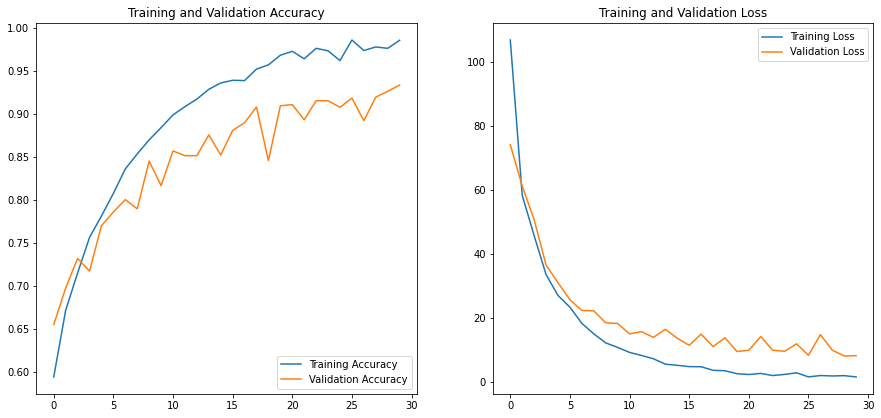

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions,target_names = ['NORMAL','COVID']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

      NORMAL       0.92      0.89      0.91      1106
       COVID       0.94      0.95      0.94      1803

    accuracy                           0.93      2909
   macro avg       0.93      0.92      0.93      2909
weighted avg       0.93      0.93      0.93      2909

